In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33971")
client

<Client: 'tcp://127.0.0.1:33971' processes=8 threads=40, memory=157.35 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import griddata
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
spec = '/tank/spectre/tuchida/NA-wavelets/'
diag = '/tank/spectre/tuchida/diagnostics/'

In [5]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -19.8
yNstart = 10
yend = 50

tchunk = 1
xchunk = 200
ychunk = 200

ntheta = 36
xo = 50e3

In [12]:
dnf = 2160
nfile = 73
years = np.arange(1963,2013,dtype=int)
ntimes = (np.arange(790560,8672400+dnf,dnf).reshape(len(years),nfile) 
          - dnf)
dd = 66
yystart = 4
ntimes[yystart,dd:][::3]

array([1561680, 1568160, 1574640])

In [13]:
critt = .7

# KE power spectra

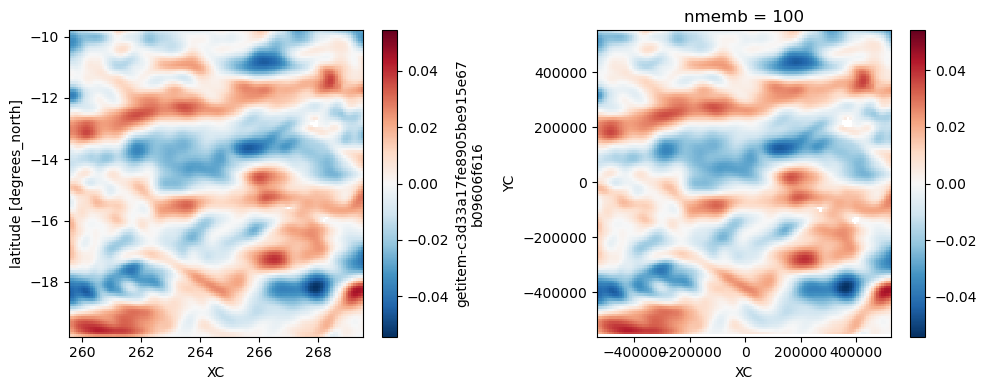

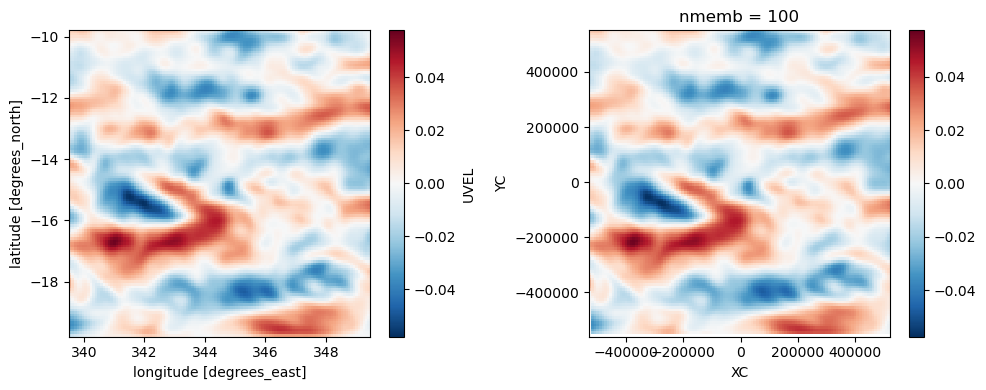

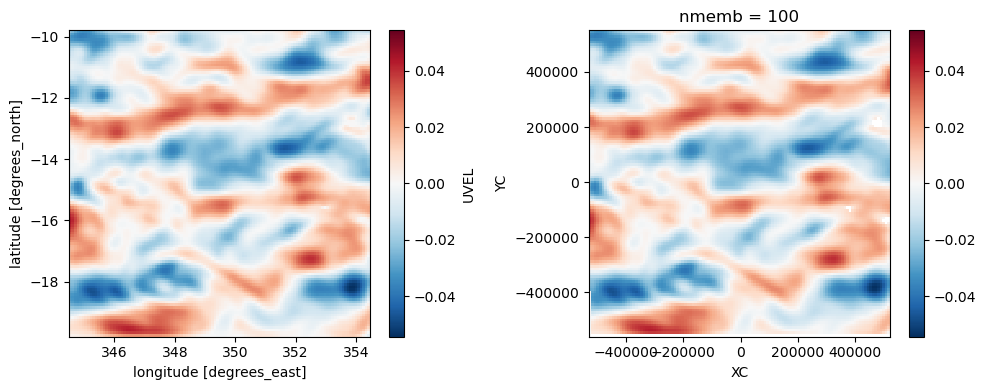

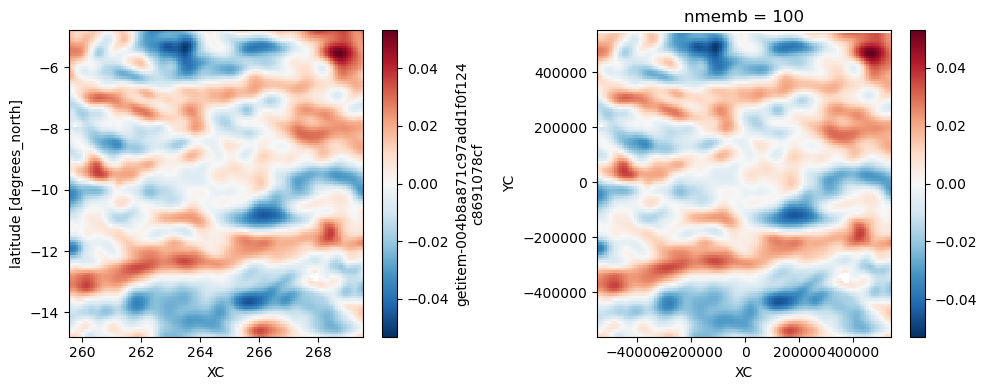

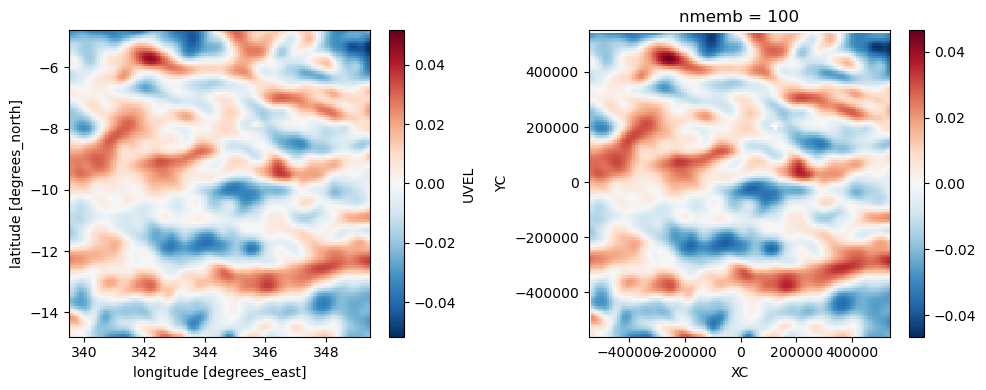

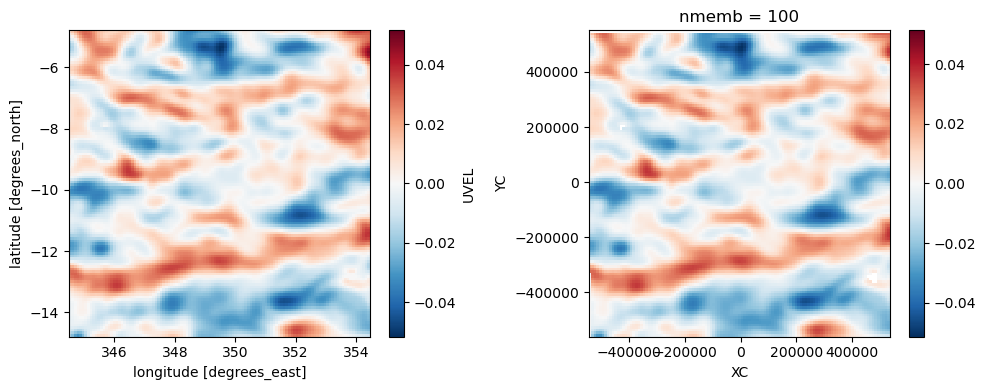

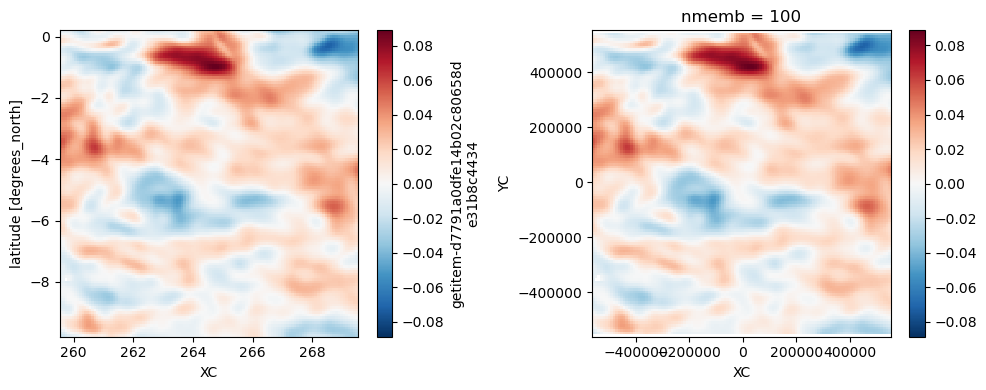

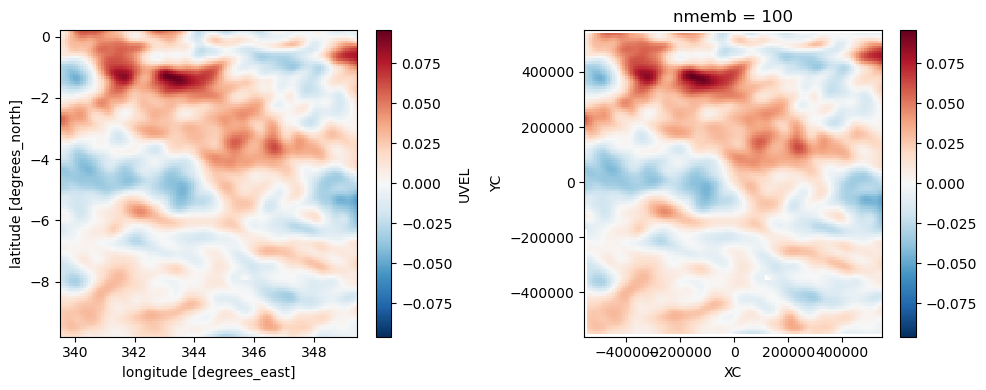

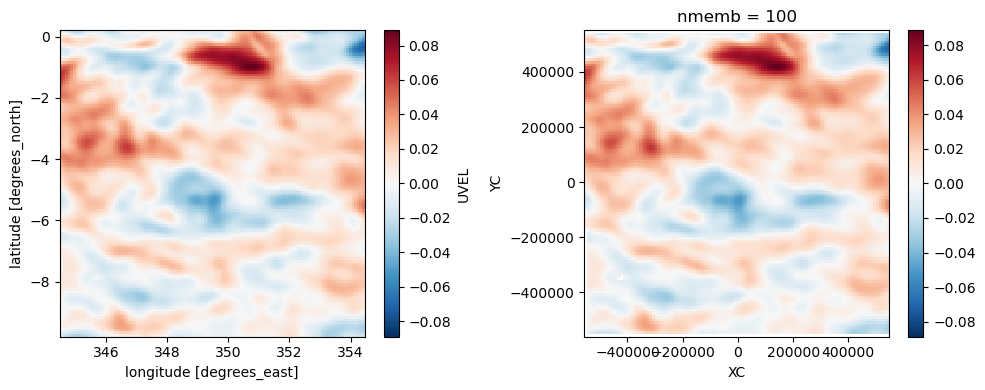

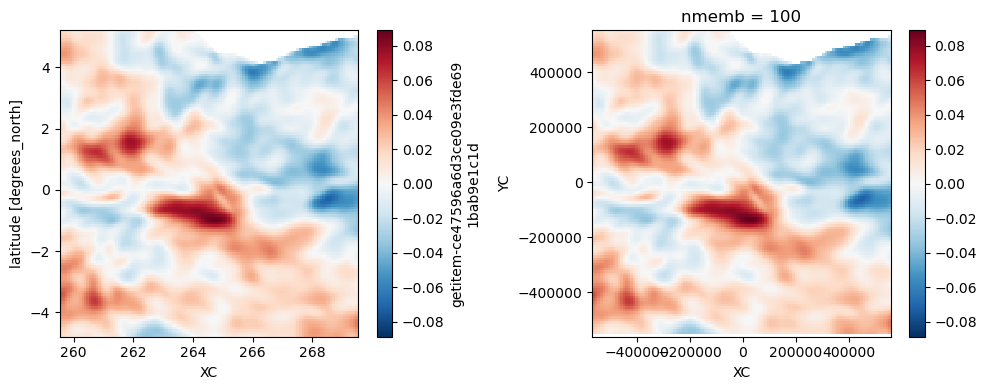

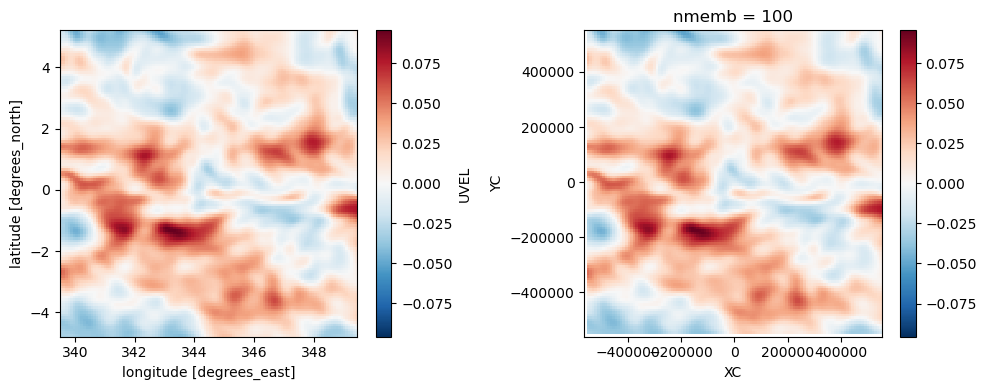

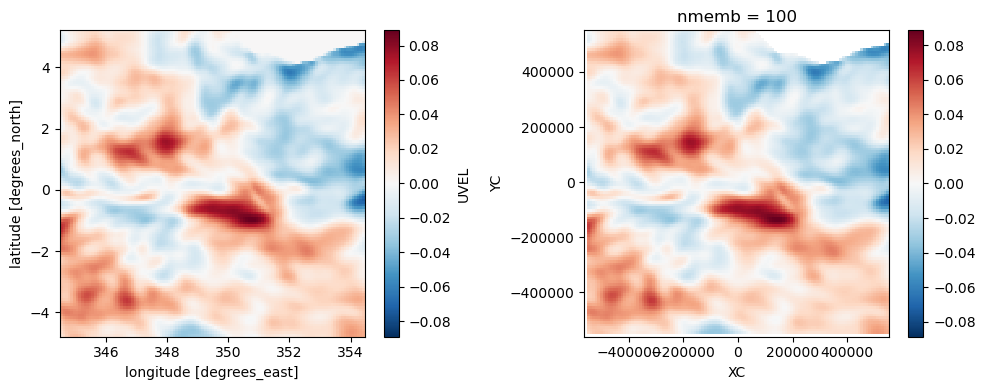

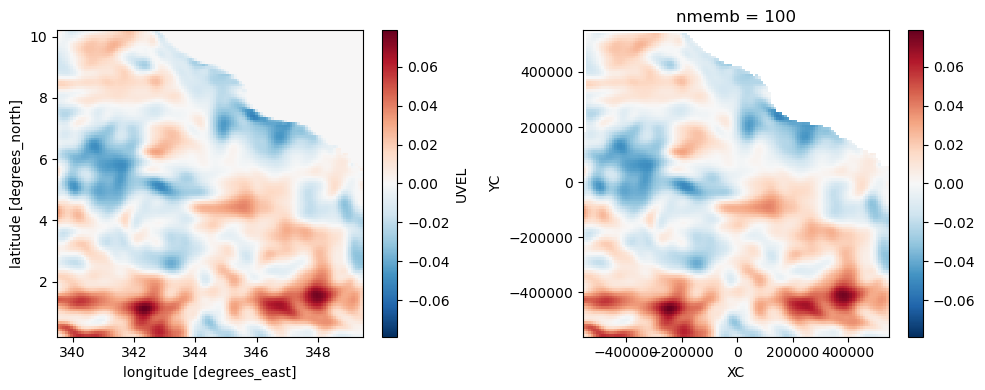

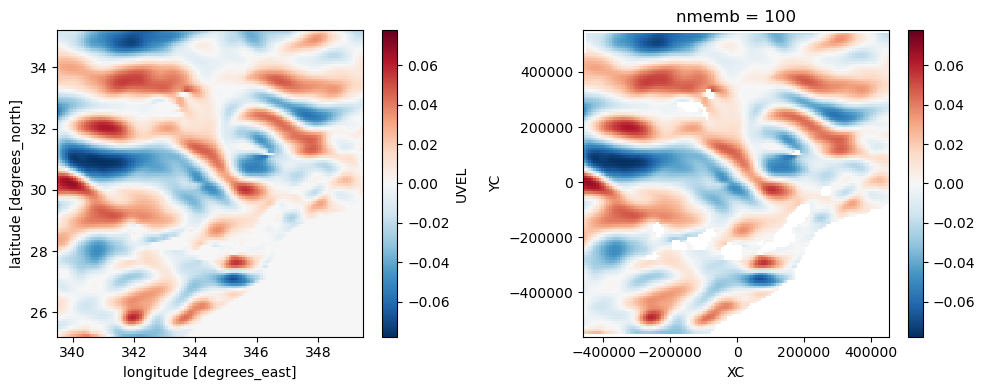

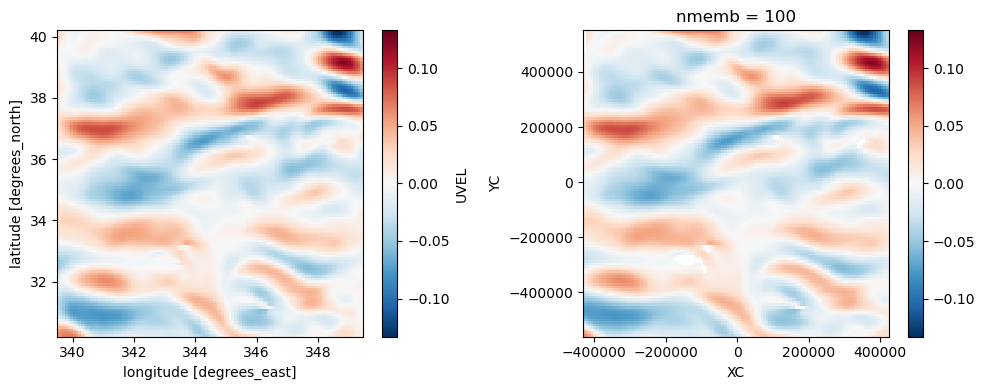

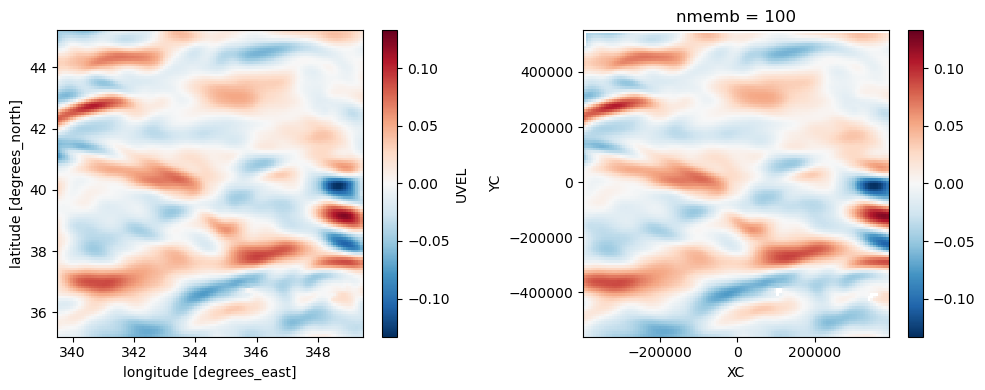

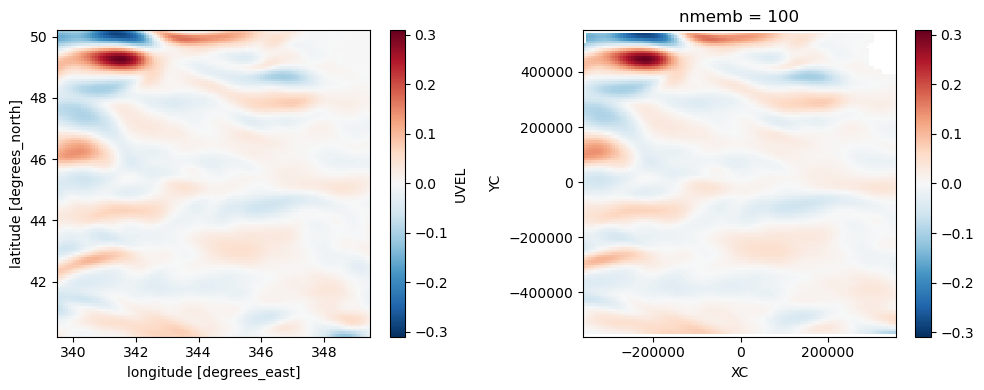

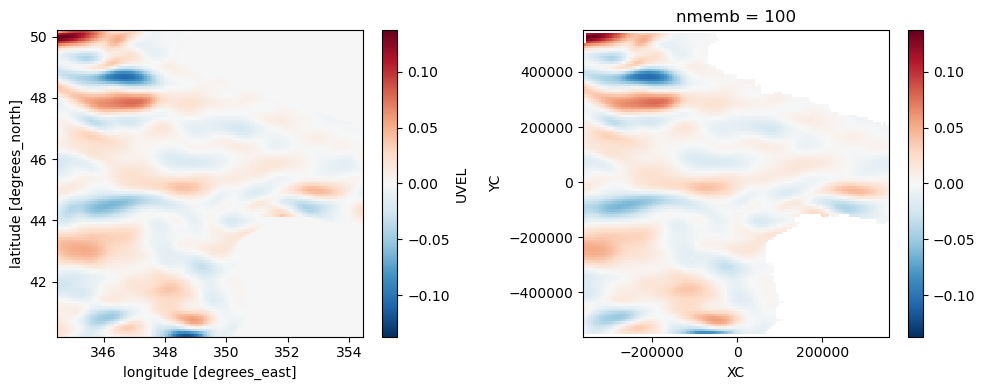

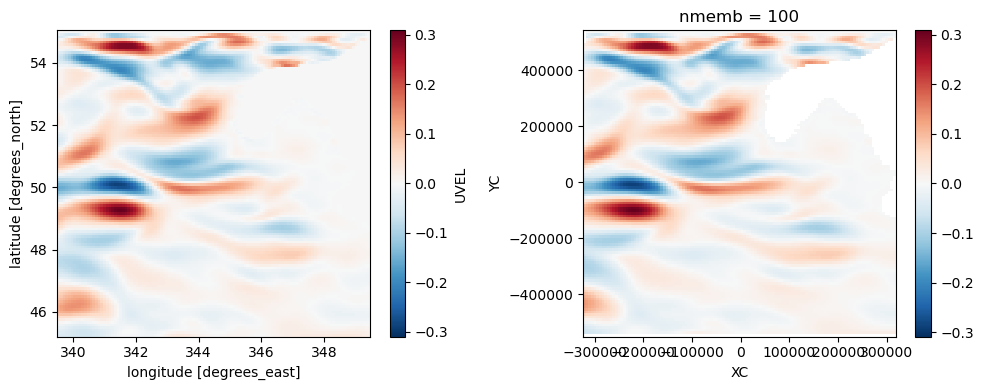

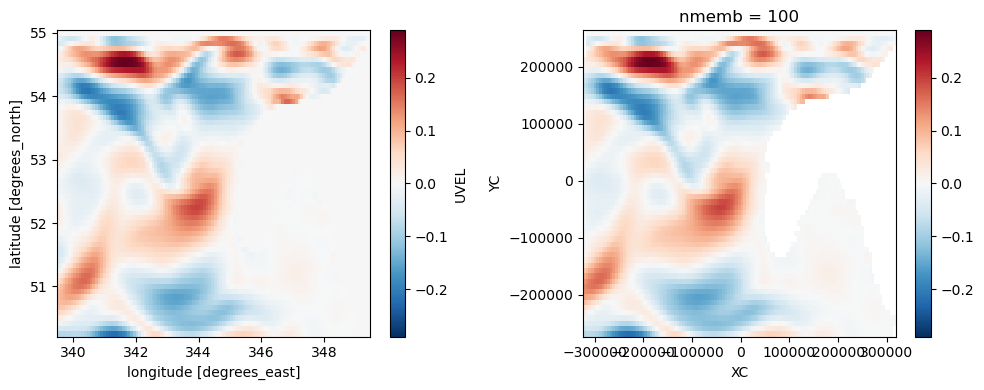

1419120


In [28]:
ystart = ySstart
nmembs = np.arange(100,148)

yys = yystart

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,dd:dd+1]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes:
        dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                                      % (year)), 
                              grid_dir=gdir,
                              prefix=['snap_diagOcn',], 
                              delta_t=2e2, iters=itime                              
                             ).isel(time=0,Z=slice(17,19),Zl=slice(17,19),
                                    Zp1=slice(17,20)
                                   ).chunk({'YC':ychunk,'YG':ychunk,
                                            'XC':xchunk,'XG':xchunk})
        coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",  "left" : "XG"},
        "Y": {"center": "YC",  "left" : "YG"},
        "Z": {"center": "Z",  "outer": "Zp1", 
              "left"  : "Zl", 
             }
       }
        grid = Grid(dsm, periodic=['X'],
                    coords=coords)
        
        for imemb in nmembs:
            if imemb == nmembs[0]:
                ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                             % (imemb,year)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn',], 
                                     delta_t=2e2, iters=itime                              
                                    ).isel(time=0,Z=slice(17,19),Zl=slice(17,19),
                                           Zp1=slice(17,20)
                                          ).chunk({'YC':ychunk,'YG':ychunk,
                                                   'XC':xchunk,'XG':xchunk})
            else:
                ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                                            % (imemb,year)), 
                                                    grid_dir=gdir,
                                                    prefix=['snap_diagOcn',], 
                                                    delta_t=2e2, iters=itime                              
                                                   ).isel(time=0,
                                                          Z=slice(17,19),
                                                          Zl=slice(17,19),
                                                          Zp1=slice(17,20)
                                                         ).chunk({'YC':ychunk,'YG':ychunk,
                                                                  'XC':xchunk,'XG':xchunk})
                               ], 'nmemb')
        
        dse = ds - dsm
        dse.coords['nmemb'] = nmembs
        xA = (dse.dyG * dse.drF).reset_coords(drop=True)
        yA = (dse.dxG * dse.drF).reset_coords(drop=True)
        
        UV = grid.interp(dse.UVEL,'X').isel(Z=1)
        VV = grid.interp(dse.VVEL,'Y',boundary='extend').isel(Z=1)
        XT = grid.cumsum(ds.dxC,'X').isel(Z=1)
        YT = grid.cumsum(ds.dyC,'Y',boundary='extend').isel(Z=1)
        
        for lat in np.arange(ystart,yend+5,5):
            
            U = UV.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            V = VV.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            X = XT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Y = YT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            mask = dse.maskC.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            for lon in np.arange(dsm.XC.min()-2.5,dsm.XC.max(),5):        
                xend = lon + 10
                if lon < dsm.XC.min():
                    dlon = dsm.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(dsm.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(lon,
                                                                           lon+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    if mmm.astype(float).sum()/np.array(mmm.shape).prod() > critt:
                        
                        u  = U.sel(XC=slice(None,xend))
                        v  = V.sel(XC=slice(None,xend))
                        x  = X.sel(XC=slice(None,xend))
                        y  = Y.sel(XC=slice(None,xend))
                        ddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                         ).reset_coords(drop=True)
                        ddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                         ).reset_coords(drop=True)
                        a   = dse.rA.sel(YC=slice(lat,lat+10),
                                         XC=slice(None,xend)).reset_coords(drop=True)
                        
                        uu  = U.sel(XC=slice(dsm.XC.max()-dlon,None))
                        vv  = V.sel(XC=slice(dsm.XC.max()-dlon,None))
                        xx  = (X.sel(XC=slice(dsm.XC.max()-dlon,None))
                               - X.sel(XC=slice(dsm.XC.max()-dlon,None)).isel(XC=0))
                        x = x + xx.isel(XC=-1)
                        # x.plot()
                        # plt.show()
                        yy  = Y.sel(XC=slice(dsm.XC.max()-dlon,None))
                        aa  = dse.rA.sel(YC=slice(lat,lat+10),
                                         XC=slice(dsm.XC.max()-dlon,None)
                                        ).reset_coords(drop=True)
                        dddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                          ).reset_coords(drop=True)
                        dddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                          ).reset_coords(drop=True)
                        
                        uuu = xr.concat([xr.DataArray(uu.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':U.YC,
                                                              'XC':np.linspace(lon,
                                                                               lon+dlon,
                                                                               num=len(uu.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     ),
                                         u
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        vvv = xr.concat([xr.DataArray(vv.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':V.YC,
                                                              'XC':np.linspace(lon,
                                                                               lon+dlon,
                                                                               num=len(vv.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     ),
                                         v
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        xT = xr.concat([xr.DataArray(xx.data, dims=['YC','XC'],
                                                     coords={'YC':X.YC,
                                                             'XC':np.linspace(lon,
                                                                              lon+dlon,
                                                                              num=len(xx.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        x
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([xr.DataArray(yy.data, dims=['YC','XC'],
                                                     coords={'YC':Y.YC,
                                                             'XC':np.linspace(lon,
                                                                              lon+dlon,
                                                                              num=len(yy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        y
                                       ], 'XC').sortby('XC')
                        A = xr.concat([xr.DataArray(aa.data, dims=['YC','XC'],
                                                    coords={'YC':a.YC,
                                                            'XC':np.linspace(lon,
                                                                             lon+dlon,
                                                                             num=len(aa.XC)+1,
                                                                             endpoint=False)[1:]}
                                                   ),
                                       a
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([xr.DataArray(dddx.data, dims=['YC','XG'],
                                                     coords={'YC':ddx.YC,
                                                             'XG':np.linspace(dsm.XG.min()-dlon,
                                                                              dsm.XG.min(),
                                                                              num=len(dddx.XG)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        ddx
                                       ], 'XG').min().values
                        dy = xr.concat([xr.DataArray(dddy.data, dims=['YG','XC'],
                                                     coords={'YG':ddy.YG,
                                                             'XC':np.linspace(lon,
                                                                              lon+dlon,
                                                                              num=len(dddy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        ddy
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T

                        Aterp = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Uterp  = Uterp / Aterp
                        Vterp  = Vterp / Aterp
                        if itime == mtimes[0]:
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            uuu.isel(nmemb=0).plot(ax=ax1)
                            Uterp.isel(nmemb=0).plot(ax=ax2)
                            plt.show()
                            
                elif xend > dsm.XC.max():
                    dlon = -dsm.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,dsm.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(dsm.XC.max(),
                                                                           dsm.XC.max()+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    if mmm.astype(float).sum().values/np.array(mmm.shape).prod() > critt:
                        
                        u = U.sel(XC=slice(lon,None))
                        v = V.sel(XC=slice(lon,None))
                        x = X.sel(XC=slice(lon,None))
                        y = Y.sel(XC=slice(lon,None))
                        ddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,None)
                                         ).reset_coords(drop=True)
                        ddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,None)
                                         ).reset_coords(drop=True)
                        a = dse.rA.sel(YC=slice(lat,lat+10),
                                       XC=slice(lon,None)).reset_coords(drop=True)
                        
                        uu = U.sel(XC=slice(None,dsm.XC.min()+dlon))
                        vv = V.sel(XC=slice(None,dsm.XC.min()+dlon))
                        xx = X.sel(XC=slice(None,dsm.XC.min()+dlon))+X.isel(XC=-1)
                        yy = Y.sel(XC=slice(None,dsm.XC.min()+dlon))
                        aa = dse.rA.sel(YC=slice(lat,lat+10),
                                        XC=slice(None,dsm.XC.min()+dlon)
                                       ).reset_coords(drop=True)
                        dddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,dsm.XG.min()+dlon)
                                          ).reset_coords(drop=True)
                        dddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,dsm.XG.min()+dlon)
                                          ).reset_coords(drop=True)
                        
                        uuu = xr.concat([u,
                                         xr.DataArray(uu.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':U.YC,
                                                              'XC':np.linspace(dsm.XC.max(),
                                                                               dsm.XC.max()+dlon,
                                                                               num=len(uu.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        vvv = xr.concat([v,
                                         xr.DataArray(vv.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':V.YC,
                                                              'XC':np.linspace(dsm.XC.max(),
                                                                               dsm.XC.max()+dlon,
                                                                               num=len(vv.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        xT = xr.concat([x,
                                        xr.DataArray(xx.data, dims=['YC','XC'],
                                                     coords={'YC':X.YC,
                                                             'XC':np.linspace(dsm.XC.max(),
                                                                              dsm.XC.max()+dlon,
                                                                              num=len(xx.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([y,
                                        xr.DataArray(yy.data, dims=['YC','XC'],
                                                     coords={'YC':Y.YC,
                                                             'XC':np.linspace(dsm.XC.max(),
                                                                              dsm.XC.max()+dlon,
                                                                              num=len(yy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        A = xr.concat([a,
                                       xr.DataArray(aa.data, dims=['YC','XC'],
                                                    coords={'YC':a.YC,
                                                            'XC':np.linspace(dsm.XC.max(),
                                                                             dsm.XC.max()+dlon,
                                                                             num=len(aa.XC)+1,
                                                                             endpoint=False)[1:]}
                                                   )
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([ddx,
                                        xr.DataArray(dddx.data, dims=['YC','XG'],
                                                     coords={'YC':ddx.YC,
                                                             'XG':np.linspace(dsm.XG.max(),
                                                                              dsm.XG.max()+dlon,
                                                                              num=len(dddx.XG)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XG').min().values
                        dy = xr.concat([ddy,
                                        xr.DataArray(dddy.data, dims=['YG','XC'],
                                                     coords={'YG':ddy.YG,
                                                             'XC':np.linspace(dsm.XC.max(),
                                                                              dsm.XC.max()+dlon,
                                                                              num=len(dddy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 

                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                        Aterp = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Uterp = Uterp / Aterp
                        Vterp = Vterp / Aterp
                        if itime == mtimes[0]:
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            uuu.isel(nmemb=0).plot(ax=ax1)
                            Uterp.isel(nmemb=0).plot(ax=ax2)
                            plt.show()
                else:
                    mmm = mask.sel(XC=slice(lon,xend))
                    if mmm.astype(float).sum().values/np.array(mmm.shape).prod() > critt:
                        
                        uuu = U.sel(XC=slice(lon,xend)).where(mmm!=0.)
                        vvv = V.sel(XC=slice(lon,xend)).where(mmm!=0.)
                        xT = X.sel(XC=slice(lon,xend))
                        yT = Y.sel(XC=slice(lon,xend))
                        A = dse.rA.sel(YC=slice(lat,lat+10),
                                       XC=slice(lon,xend)).where(mmm!=0.)
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,xend)
                                       ).min().values
                        dy = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,xend)
                                       ).min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)

                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):

                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu*A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv*A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                        Aterp = griddata((xT, yT), 
                                         ds.rA.sel(YC=slice(lat,lat+10),
                                                   XC=slice(lon,xend)).values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        AUterp = AUterp / Aterp
                        AVterp = AVterp / Aterp
                        AUherp = AUherp / Aterp
                        AVherp = AVherp / Aterp
                        Uterp = Uterp / Aterp
                        Vterp = Vterp / Aterp
                        if itime == mtimes[0] and lon == dsm.XC.min():
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            vvv.isel(nmemb=0).plot(ax=ax1)
                            Vterp.isel(nmemb=0).plot(ax=ax2)
                            plt.show()
                
                
                if mmm.astype(float).sum().values/np.array(mmm.shape).prod() > critt:
                    iso_psUf = xrft.isotropic_power_spectrum(
                                Uterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                                dim=["YC", "XC"], window='hann', 
                                window_correction=True, true_amplitude=True, truncate=True
                    ) 
                    iso_psVf = xrft.isotropic_power_spectrum(
                                Vterp.interpolate_na(dim='YC').interpolate_na(dim='XC').fillna(0.), 
                                dim=["YC", "XC"], window='hann', 
                                window_correction=True, true_amplitude=True, truncate=True
                    )
                    if itime == mtimes[0] and lon == dsm.XC.min():
                        fig, ax = plt.subplots()
                        ax.loglog(iso_psUf.freq_r*1e3, .5*(iso_psUf + iso_psVf).mean('nmemb'))
                        plt.show()
                    dsave = iso_psUf.to_dataset(name='U')
                    dsave['V'] = iso_psVf
                    la = A.YC.mean().values
                    lo = A.XC.mean().values
                    if la < 0.:
                        fname = ('Z0452/MOM/Snap/%010d/Fourier/Spectra/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = ('Z0452/MOM/Snap/%010d/Fourier/Spectra/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()

                    ss = xr.DataArray(np.linspace(iso_psUf.freq_r[-1].data**-1,
                                                  iso_psUf.freq_r[0].data**-1,40
                                                 )/xo,
                                      dims=['scale'], 
                                      coords={'scale':np.linspace(iso_psUf.freq_r[-1].data**-1,
                                                                  iso_psUf.freq_r[0].data**-1,40
                                                                 )/xo}
                    )
                    ssf = xr.DataArray(iso_psUf.freq_r.data**-1/xo, dims=['scale'], 
                                       coords={'scale':iso_psUf.freq_r.data**-1/xo}
                                      )
                    ssh = xr.concat([ss.where(ss>50e3/xo).dropna('scale')[::-1],
                                     ssf.where(ssf<50e3/xo).dropna('scale')
                                    ], 'scale')
                    iso_psUw = xwavelet.wvlt_power_spectrum(
                                    Uterp.chunk({'nmemb':1}), ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    ) 
                    iso_psVw = xwavelet.wvlt_power_spectrum(
                                    Vterp.chunk({'nmemb':1}), ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    )
                    if la < 0.:
                        fname = ('Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = ('Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave = iso_psUw.to_dataset(name='U')
                    dsave['V'] = iso_psVw
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()
        dse.close()
        dsm.close()
        ds.close()
        print(itime)
    yys += 1

In [31]:
ystart = ySstart
nmembs = np.arange(100,148)

yys = yystart
dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                              % (years[yystart])), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn',], 
                      delta_t=2e2, iters=ntimes[0,0]                              
                     ).isel(time=0
                           ).chunk({'YC':ychunk,'YG':ychunk,
                                    'XC':xchunk,'XG':xchunk})
coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",   "left" : "XG"},
        "Y": {"center": "YC",   "left" : "YG"},
        "Z": {"center": "Z" ,   "outer": "Zp1", 
              "left"  : "Zl",   "inner": "Zu"}
        }
grid = Grid(dsm, periodic=['X'],
            coords=coords)
KEslope_full = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
KEslope = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,dd:dd+1]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes:       
        iy = 0
        for lat in np.arange(ystart,yend+5,5):
            mask = dsm.maskC.isel(Z=18).sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            ix = 0
            for lon in np.arange(dsm.XC.min()-2.5,dsm.XC.max(),5):    
                xend = lon + 10
                if lon < dsm.XC.min():
                    dlon = dsm.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(dsm.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(lon,
                                                                           lon+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds_spec = xr.open_zarr(op.join(spec,fname))
                        _, slope, _ = xrft.fit_loglog((ds_spec.scale.sel(scale=slice(250e3,50e3))).values**-1,
                          (ds_spec.U + ds_spec.V
                          ).mean(['nmemb','angle']).sel(scale=slice(250e3,50e3)).values
                                                  )
                        if crit == 1.:
                            KEslope_full[dict(YC=iy,XC=ix)] = slope
                        else:
                            KEslope[dict(YC=iy,XC=ix)] = slope
                elif xend > dsm.XC.max():
                    dlon = -dsm.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,dsm.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(dsm.XC.max(),
                                                                           dsm.XC.max()+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds_spec = xr.open_zarr(op.join(spec,fname))
                        _, slope, _ = xrft.fit_loglog((ds_spec.scale.sel(scale=slice(250e3,50e3))).values**-1,
                          (ds_spec.U + ds_spec.V
                          ).mean(['nmemb','angle']).sel(scale=slice(250e3,50e3)).values
                                                  )
                        if crit == 1.:
                            KEslope_full[dict(YC=iy,XC=ix)] = slope
                        else:
                            KEslope[dict(YC=iy,XC=ix)] = slope
                else:
                    mmm = mask.sel(XC=slice(lon,xend))
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds_spec = xr.open_zarr(op.join(spec,fname))
                        _, slope, _ = xrft.fit_loglog((ds_spec.scale.sel(scale=slice(250e3,50e3))).values**-1,
                          (ds_spec.U + ds_spec.V
                          ).mean(['nmemb','angle']).sel(scale=slice(250e3,50e3)).values
                                                  )
                        if crit == 1.:
                            KEslope_full[dict(YC=iy,XC=ix)] = slope
                        else:
                            KEslope[dict(YC=iy,XC=ix)] = slope  
                
                ds_spec.close()
                ix += 1
            iy += 1

        dsm.close()
        print(itime)
    yys += 1

# KEflux[dict(XC=0)] = KEflux.isel(XC=-1)
KEslope

1419120


<xarray.DataArray (YC: 15, XC: 18)>
array([[-3.99740115, -3.49569423, -3.39623608,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan, -4.16496422,         nan,         nan,
                nan,         nan, -4.01047249],
       [-3.25475895, -3.65185612, -3.93114218, -3.09040612,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan, -4.46934654,         nan,
                nan, -2.94028763, -3.06393298],
       [-3.15409482, -3.26971986, -2.62875585, -2.88521973,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan, -3.63197075,         nan,
                nan, -3.05196244, -2.87511998],
       [-2.06492883, -2.29886344, -2.5869799 , -1.6784509 ,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan, -2.26983713, -2.97368418, -2.2342028 ,         nan,
                nan,         nan, -1.98021935],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
        -4.10304184, -3.47392119,         nan,         nan,         nan,
        -1.74302988, -2.78499519,         nan],
...
       [        nan,         nan,         nan,         nan,         nan,
        -3.88025109, -4.2535523 , -4.50120943,         nan, -4.16798457,
        -3.74484475,         nan, -3.62688358, -3.3860919 , -4.1006897 ,
        -4.35690674, -4.42138158,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan, -4.31870314, -4.59184229, -4.55323202,
        -4.36066302,         nan, -4.7752507 , -4.31275921, -4.07979979,
        -4.4155667 , -4.0425283 ,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
        -3.66957557, -3.9199134 ,         nan,         nan,         nan,
                nan, -4.40002107, -3.30094262],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
        -2.3507523 , -3.17999205,         nan,         nan,         nan,
                nan, -3.15628793,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
        -4.39894997,         nan,         nan,         nan,         nan,
                nan, -3.42085256,         nan]])
Coordinates:
  * YC       (YC) float64 -14.8 -9.8 -4.8 0.2 5.2 ... 35.2 40.2 45.2 50.2 55.2
  * XC       (XC) float64 264.5 269.5 274.5 279.5 ... 334.5 339.5 344.5 349.5

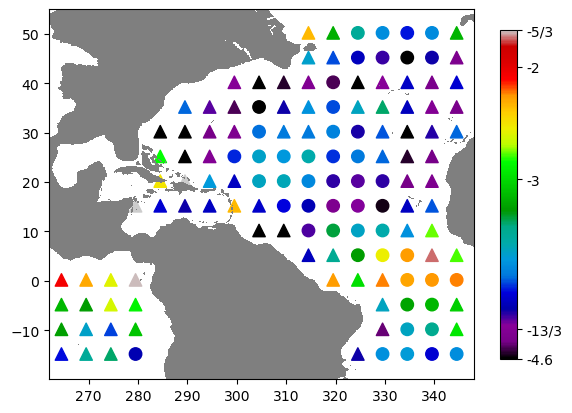

In [32]:
xx, yy = np.meshgrid(KEslope.XC, KEslope.YC.isel(YC=slice(None,-1)))

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
# im = ax.pcolormesh(KEflux.XC, KEflux.YC.isel(YC=slice(None,-1)), 
#                    KEflux.isel(YC=slice(None,-1)), cmap='RdBu_r',
#               vmin=-1e-9, vmax=1e-9, rasterized=True
#              )
im = ax.scatter(xx, yy, s=80,
                c=KEslope_full.isel(YC=slice(None,-1)), cmap='nipy_spectral',
                vmin=-4.6, vmax=-5/3, rasterized=True
               )
ax.scatter(xx, yy, s=80,
                c=KEslope.isel(YC=slice(None,-1)), cmap='nipy_spectral', 
           marker='^',
                vmin=-4.6, vmax=-5/3, rasterized=True
               )
ax.pcolormesh(dsm.XC, dsm.YC, dsm.maskC.where(dsm.maskC==0.).isel(Z=18),
              vmin=-2, vmax=2, cmap='binary', rasterized=True
             )
ax.set_xlim([dsm.XC.min(), dsm.XC.max()])
ax.set_ylim([dsm.YC.min(), dsm.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_ticks([-4.6,-13/3,-3,-2,-5/3])
cbar.set_ticklabels(['-4.6','-13/3','-3','-2','-5/3'])
plt.savefig(op.join(spec,'Figs/KEslope_Z0452_%010d.pdf' 
                    % (ntimes[0,0])))

1419120


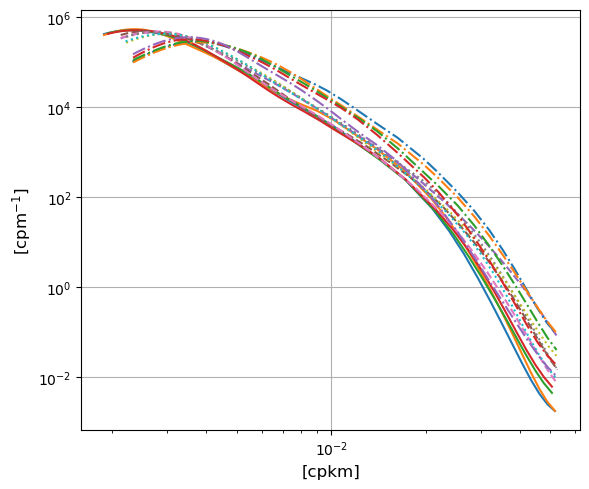

In [25]:
ystart = ySstart
nmembs = np.arange(100,148)

yys = yystart
dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                              % (years[yystart])), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn',], 
                      delta_t=2e2, iters=ntimes[0,0]                              
                     ).isel(time=0
                           ).chunk({'YC':ychunk,'YG':ychunk,
                                    'XC':xchunk,'XG':xchunk})

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,dd:dd+1]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes:       
        for lat in np.arange(ystart,yend+5,5):
            if lat > 20. and lat < 45:
                mask = dsm.maskC.isel(Z=18).sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
                for lon in np.arange(dsm.XC.min()-2.5,dsm.XC.max(),5):   
                    xend = lon + 10
                    mmm = mask.sel(XC=slice(lon,xend))
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    if lo > 290:
                        if lat < 30:
                            if lo < 300:
                                crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                                if crit > critt:
                                    fname = (
                                    'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat%03d_Lon%03d.zarr' 
                                                         % (itime,np.floor(la),np.floor(lo)))
                                    ds_spec = xr.open_zarr(op.join(spec,fname)) 
                                    ps = ((ds_spec.U + ds_spec.V).mean(['nmemb']).sum(['angle'])
                                          * 2 * np.pi/len(ds_spec.angle))
                                    dk = (ds_spec.scale**-1).diff('scale')
                                    energy = (.5*(ps.isel(scale=slice(1,None)).data
                                                  + ps.isel(scale=slice(None,-1)).data
                                                 )*dk).sum('scale')
                                    ax.plot(ds_spec.scale**-1*1e3, ps/energy)
                                    ds_spec.close()
                        elif lat < 35:
                            if lo < 305:
                                crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                                if crit > critt:
                                    fname = (
                                    'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat%03d_Lon%03d.zarr' 
                                                         % (itime,np.floor(la),np.floor(lo)))
                                    ds_spec = xr.open_zarr(op.join(spec,fname)) 
                                    ps = ((ds_spec.U + ds_spec.V).mean(['nmemb']).sum(['angle'])
                                          * 2 * np.pi/len(ds_spec.angle))
                                    dk = (ds_spec.scale**-1).diff('scale')
                                    energy = (.5*(ps.isel(scale=slice(1,None)).data
                                                  + ps.isel(scale=slice(None,-1)).data
                                                 )*dk).sum('scale')
                                    ax.plot(ds_spec.scale**-1*1e3, ps/energy, ls='--')
                                    ds_spec.close()
                        elif lat < 40:
                            if lo < 310:
                                crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                                if crit > critt:
                                    fname = (
                                    'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat%03d_Lon%03d.zarr' 
                                                         % (itime,np.floor(la),np.floor(lo)))
                                    ds_spec = xr.open_zarr(op.join(spec,fname)) 
                                    ps = ((ds_spec.U + ds_spec.V).mean(['nmemb']).sum(['angle'])
                                          * 2 * np.pi/len(ds_spec.angle))
                                    dk = (ds_spec.scale**-1).diff('scale')
                                    energy = (.5*(ps.isel(scale=slice(1,None)).data
                                                  + ps.isel(scale=slice(None,-1)).data
                                                 )*dk).sum('scale')
                                    ax.plot(ds_spec.scale**-1*1e3, ps/energy, ls=':')
                                    ds_spec.close()
                        else:
                            if lo < 335:
                                crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                                if crit > critt:
                                    fname = (
                                    'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat%03d_Lon%03d.zarr' 
                                                         % (itime,np.floor(la),np.floor(lo)))
                                    ds_spec = xr.open_zarr(op.join(spec,fname)) 
                                    ps = ((ds_spec.U + ds_spec.V).mean(['nmemb']).sum(['angle'])
                                          * 2 * np.pi/len(ds_spec.angle))
                                    dk = (ds_spec.scale**-1).diff('scale')
                                    energy = (.5*(ps.isel(scale=slice(1,None)).data
                                                  + ps.isel(scale=slice(None,-1)).data
                                                 )*dk).sum('scale')
                                    ax.plot(ds_spec.scale**-1*1e3, ps/energy, ls='-.')
                                    ds_spec.close()
        print(itime)
    yys += 1

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"[cpkm]", fontsize=12)
ax.set_ylabel(r"[cpm$^{-1}$]", fontsize=12)
ax.grid(True)

1419120


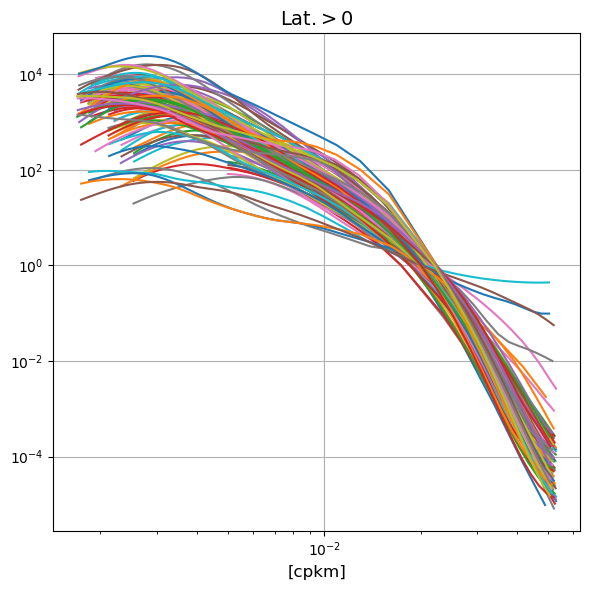

In [9]:
ystart = ySstart
nmembs = np.arange(100,148)

yys = yystart
dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                              % (years[yystart])), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn',], 
                      delta_t=2e2, iters=ntimes[0,0]                              
                     ).isel(time=0
                           ).chunk({'YC':ychunk,'YG':ychunk,
                                    'XC':xchunk,'XG':xchunk})

fig, ax = plt.subplots(figsize=(6,6))
fig.set_tight_layout(True)
for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,dd:dd+1]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes:       
        for lat in np.arange(yend,-5,-5):
        # for lat in np.arange(ystart,5,5):
            mask = dsm.maskC.isel(Z=18).sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            for lon in np.arange(dsm.XC.min()-2.5,dsm.XC.max(),5):    
                xend = lon + 10
                if lon < dsm.XC.min():
                    dlon = dsm.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(dsm.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(lon,
                                                                           lon+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds_spec = xr.open_zarr(op.join(spec,fname)) 
                        ps = ((ds_spec.U + ds_spec.V).mean(['nmemb']).sum(['angle'])
                              * 2 * np.pi/len(ds_spec.angle))
                        # dk = (ds_spec.scale**-1).diff('scale')
                        # energy = (.5*(ps.isel(scale=slice(1,None)).data
                        #               + ps.isel(scale=slice(None,-1)).data
                        #              )*dk).sum('scale')
                        # ax.plot(ds_spec.scale**-1*1e3, ps/energy)
                        ax.plot(ds_spec.scale**-1*1e3, 
                                ps/ps.sel(scale=50e3, method='nearest'))
                elif xend > dsm.XC.max():
                    dlon = -dsm.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,dsm.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(dsm.XC.max(),
                                                                           dsm.XC.max()+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds_spec = xr.open_zarr(op.join(spec,fname)) 
                        ps = ((ds_spec.U + ds_spec.V).mean(['nmemb']).sum(['angle'])
                              * 2 * np.pi/len(ds_spec.angle))
                        # dk = (ds_spec.scale**-1).diff('scale')
                        # energy = (.5*(ps.isel(scale=slice(1,None)).data
                        #               + ps.isel(scale=slice(None,-1)).data
                        #              )*dk).sum('scale')
                        # ax.plot(ds_spec.scale**-1*1e3, ps/energy)
                        ax.plot(ds_spec.scale**-1*1e3, 
                                ps/ps.sel(scale=50e3, method='nearest'))
                else:
                    mmm = mask.sel(XC=slice(lon,xend))
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Spectra/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds_spec = xr.open_zarr(op.join(spec,fname)) 
                        ps = ((ds_spec.U + ds_spec.V).mean(['nmemb']).sum(['angle'])
                              * 2 * np.pi/len(ds_spec.angle))
                        # dk = (ds_spec.scale**-1).diff('scale')
                        # energy = (.5*(ps.isel(scale=slice(1,None)).data
                        #               + ps.isel(scale=slice(None,-1)).data
                        #              )*dk).sum('scale')
                        # ax.plot(ds_spec.scale**-1*1e3, ps/energy)
                        ax.plot(ds_spec.scale**-1*1e3, 
                                ps/ps.sel(scale=50e3, method='nearest'))
                
                ds_spec.close()
        print(itime)
    yys += 1

ax.set_title(r"Lat.$>0$", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r"[cpkm]", fontsize=12)
# ax.set_ylabel(r"[cpm$^{-1}$]", fontsize=12)
ax.grid(True)

# KE spectral transfer

In [8]:
def advec_um(ds, u, cori=False, metr=False, xgcm_flag=True):

    '''
    Compute the 3D advection and advective fluxes
    of zonal momentum.

    Input:
       - u, v, w: three dimensional velocity field
       - grd: list of model grid varaibles
    Output:
       - ADVx_Um, ADVy_Um, ADVrE_Um: zonal, meridional and vertical u-momentum flux
       - Um_Advec: u-momentum flux divergence.
                   In MITgcm diagnostics, Um_Advec also includes 
                   Coriolis (Um_Cori) and metric term (Um_metr).
                   They can be computed and added with cori=True and metr=True (to be done)
    '''

    #-- grid --
    dxG = ds.dxG
    dyG = ds.dyG
    drF = ds.drF
    hW  = ds.hFacW
    hS  = ds.hFacS
    hC  = ds.hFacC
    rA  = ds.rA
    rAw = ds.rAw
    uuu = ds.UVEL
    vvv = ds.VVEL
    www = ds.WVEL
    #
    xA = (drF * dyG * hW)
    yA = (drF * dxG * hS)
    maskC = hC.load().data * 1.0
    maskC[ np.where(maskC > 0. ) ] = 1.0
    maskC = xr.DataArray(data=maskC,
                         dims=hC.dims, coords=hC.coords)

    #-- get and check dimensions --
    [nr, ny, nx] = hW.shape
    tmp = nr*ny*nx
    # if np.size(u)!=np.size(vvv) or np.size(u)!=np.size(ds.WVEL) or np.size(u)!=tmp:
    #     raise ValueError("advec_um: velocity field do not have the same/right dimension")
    #

    #-- zonal advective flux of U (from mom_u_adv_uu.F) --
    #- transport -
    uTrans = uuu * xA
    #- adv flux -
    if xgcm_flag:
        grid = Grid(ds, periodic=['X'])
        ADVx_Um = (grid.interp(uTrans, 'X')
                   * grid.interp(   u, 'X')
                  )
    else:
        ADVx_Um = np.zeros_like(hW.data)
        ADVx_Um[:, :, :-1] = \
                0.25 *(uTrans[:, :, :-1].data + uTrans[:, :, 1:].data ) \
                     *(   u[:, :, :-1].data +    u[:, :, 1:].data   )
    
    #-- meridional advective flux of U (from mom_u_adv_vu.F) --
    #- transport -
    vTrans = vvv * yA
    #- adv flux -
    if xgcm_flag:
        ADVy_Um = (grid.interp(vTrans, 'X') 
                   * grid.interp(   u, 'Y', boundary='extend')
                  )
    else:
        ADVy_Um = np.zeros_like(hW.data)
        ADVy_Um[:, 1:, 1:] = \
                0.25 *(vTrans[:, 1:, 1:].data + vTrans[:, 1:, :-1].data ) \
                     *(   u[:, 1:, 1:].data +    u[:, :-1, 1:].data   )
    
    #-- vertical advective flux of U (from mom_u_adv_wu.F) --
    #- transport -
    # rTransU :: vertical transport (above U point)
    if xgcm_flag:
        rTransU = grid.interp(ds.WVEL*rA, 'X')
        ADVrE_Um = xr.zeros_like(rTransU)
        ADVrE_Um[dict(Zl=0)] = rTransU.isel(Zl=0) * u.isel(Z=0)
        ADVrE_Um[dict(Zl=slice(1,None))] = (rTransU.isel(Zl=slice(1,None)) 
                          * grid.interp(u,'Z',boundary='extend').isel(Zl=slice(1,None))
                                           )
        ADVrE_Um[dict(Zl=slice(1,None))] += .5*(
              grid.interp(ds.WVEL * rA
                          * grid.diff(maskC,'Z',boundary='extend'),
                          'X'
                         ).isel(Zl=slice(1,None)) 
              * u.isel(Z=slice(1,None)).data
                                        )
    else:
        rTransU = np.zeros_like(hW.data)
        rTransU[:, :, 1:] = \
                0.5 * ( www[:, :, :-1].data * rA.data[np.newaxis, :, :-1] \
                       +www[:, :, 1: ].data * rA.data[np.newaxis, :, 1: ] )

        # - advective flux -
        # surface layer 
        ADVrE_Um = np.zeros_like(hW.data)
        ADVrE_Um[0, :, :] = rTransU[0, :, :] * u[0, :, :].data

        # ADVrE_Um[0, :, :] = 0.0         # rigid lid, for checking
        # interior flux
        ADVrE_Um[1:, :, :] = rTransU[1:, :, :] * \
                0.5 * ( u[1:, :, :].data + u[:-1, :, :].data)

        # (linear) Free-surface correction at k>1
        ADVrE_Um[1:, :, 1:] = ADVrE_Um[1:, :, 1:] \
                + 0.25 * (\
                  www[1:, :, 1:].data * rA.data[np.newaxis, :, 1:] *\
                    (maskC[1:, :, 1:].data - maskC[:-1, :, 1:].data) \
                 +www[1:, :, :-1].data * rA.data[np.newaxis, :, :-1] *\
                    (maskC[1:, :, :-1].data - maskC[:-1, :, :-1].data) \
                         ) * u[1:, :, 1:]
    
        
    
    #-- flux divergence (from mom_fluxform.F) --
    if xgcm_flag:
        gUx = - grid.diff(ADVx_Um, 'X') / (hW * drF * rAw)
        gUy = - grid.diff(ADVy_Um, 'Y', boundary='extend'
                         )/ (hW * drF * rAw)
        gUz = xr.zeros_like(ds.UVEL)
        gUz[dict(Z=slice(None,-1))] = - (-grid.diff(ADVrE_Um,'Z',boundary='extend'
                                                     ).isel(Z=slice(None,-1)) 
                                         / (hW * drF * rAw).isel(Z=slice(None,-1)) 
                                        )
        gUz[dict(Z=-1)] = - ((ADVrE_Um.isel(Zl=-1) - 0.0)
                             / (hW * drF * rAw).isel(Z=-1)
                            )
        Um_Advec = (gUx + gUy + gUz).reset_coords(drop=True)
    else:
        #- zonal -
        gUx = np.zeros_like(hW.data)
        gUx[:, :, 1:] = - 1 / (hW * drF * rAw).data[:, :, 1:] \
                * (ADVx_Um[:, :, 1:] - ADVx_Um[:, :, :-1])
        #- meridional -
        gUy = np.zeros_like(hW.data)
        gUy[:, :-1, :] = - 1 / (hW * drF * rAw).data[:, :-1, :] \
                * (ADVy_Um[:, 1:, :] - ADVy_Um[:, :-1, :])
        #- vertical -
        gUz = np.zeros_like(hW.data)
        gUz[:-1, :, :] = - 1 / (hW * drF * rAw).data[:-1, :, :] \
                * (ADVrE_Um[:-1, :, :] - ADVrE_Um[1:, :, :])
        gUz[-1, :, :] = - 1 / (hW * drF * rAw).data[-1, :, :] \
                * (ADVrE_Um[-1, :, :] - 0.0)     #no bottom flux at bottom cell
        if cori:
            print("Include Coriolis and metric terms in Um_Advec (following MITgcm diagnostic package convention)")
            print("TO BE DONE (07/21/2023)")
        #- total -
        Um_Advec = xr.DataArray(gUx + gUy + gUz, dims=ds.UVEL.dims, coords=ds.UVEL.coords
                               ).reset_coords(drop=True)

    return Um_Advec


def advec_vm(ds, v, cori=False, metr=False, xgcm_flag=True):

    '''
    Compute the 3D advection and advective fluxes
    of meridional momentum.

    Input:
       - u, v, w: three dimensional velocity field
       - grd: list of model grid varaibles
    Output:
       - ADVx_Vm, ADVy_Vm, ADVrE_Vm: zonal, meridional and vertical v-momentum flux
       - Vm_Advec: v-momentum flux divergence.
                   In MITgcm diagnostics, Vm_Advec also includes 
                   Coriolis (Vm_Cori) and metric term (Vm_metr).
                   They can be computed and added with cori=True and metr=True (to be done)
    '''

    #-- grid --
    dxG = ds.dxG
    dyG = ds.dyG
    drF = ds.drF
    hW  = ds.hFacW
    hS  = ds.hFacS
    hC  = ds.hFacC
    rA  = ds.rA
    rAs = ds.rAs
    uuu = ds.UVEL
    vvv = ds.VVEL
    www = ds.WVEL
    #
    xA = (drF * dyG * hW)
    yA = (drF * dxG * hS)
    maskC = hC.load().data * 1.0
    maskC[ np.where(maskC > 0. ) ] = 1.0
    maskC = xr.DataArray(data=maskC,
                         dims=hC.dims, coords=hC.coords)

    #-- get and check dimensions --
    [nr, ny, nx] = hS.shape
    tmp = nr*ny*nx
    # if np.size(uuu)!=np.size(v) or np.size(v)!=np.size(ds.WVEL) or np.size(v)!=tmp:
    #     raise ValueError("advec_vm: velocity field do not have the same/right dimension")
    #
    
    #-- zonal advective flux of V (mom_v_adv_uv.F) --
    #- transport -
    uTrans = uuu * xA
    #- adv flux -
    if xgcm_flag:
        grid = Grid(ds, periodic=['X'])
        ADVx_Vm = (grid.interp(uTrans, 'Y', boundary='extend') 
               * grid.interp(   v, 'X')
              )
    else:
        ADVx_Vm = np.zeros_like(hS.data)
        ADVx_Vm[:, 1:, 1:] = \
            0.25 *(uTrans[:, 1:, 1:].data + uTrans[:, :-1, 1:].data ) \
                 *(   v[:, 1:, 1:].data + v[:, 1:, :-1].data    )

    #-- meridional advective flux of V (from mom_v_adv_vv.F) --
    #- transport -
    vTrans = vvv * yA
    #- adv flux -
    if xgcm_flag:
        ADVy_Vm = (grid.interp(vTrans, 'Y', boundary='extend') 
               * grid.interp(   v, 'Y', boundary='extend')
              )
    else:
        ADVy_Vm = np.zeros_like(hS.data)
        ADVy_Vm[:, :-1, :] = \
                0.25 *(vTrans[:, :-1, :].data + vTrans[:, 1:, :].data ) \
                     *(   v[:, :-1, :].data + v[:, 1:, :].data   )

    #-- vertical advective flux of V (mom_v_adv_wv.F) --
    #- transport -
    # rTransV :: vertical transport (above V point) 
    if xgcm_flag:
        rTransV = grid.interp(ds.WVEL*rA, 'Y', boundary='extend')
        ADVrE_Vm = xr.zeros_like(rTransV)
        ADVrE_Vm[dict(Zl=0)] = rTransV.isel(Zl=0) * v.isel(Z=0)
        ADVrE_Vm[dict(Zl=slice(1,None))] = (rTransV.isel(Zl=slice(1,None)) 
                          * grid.interp(v,'Z',boundary='extend').isel(Zl=slice(1,None))
                                           )
        ADVrE_Vm[dict(Zl=slice(1,None))] += .5*(
              grid.interp(ds.WVEL * rA
                          * grid.diff(maskC,'Z',boundary='extend'),
                          'Y',boundary='extend'
                         ).isel(Zl=slice(1,None)) 
              * v.isel(Z=slice(1,None)).data
                                        )
    else:
        rTransV = np.zeros_like(hS.data)
        rTransV[:, 1:, :] = \
                0.5 * ( www[:, :-1, :].data * rA.data[np.newaxis, :-1, :] \
                       +www[:, 1: , :].data * rA.data[np.newaxis, 1: , :] )
        #- advective flux -
        # surface layer 
        ADVrE_Vm = np.zeros_like(hS.data)
        ADVrE_Vm[0, :, :] = rTransV[0, :, :] * v[0, :, :].data
        #ADVrE_Vm[0, :, :] = 0.0         # rigid lid, for checking
        # interior flux
        ADVrE_Vm[1:, :, :] = rTransV[1:, :, :] * \
                0.5 * ( v[1:, :, :].data + v[:-1, :, :].data)
        # (linear) Free-surface correction at k>1
        ADVrE_Vm[1:, 1:, :] = ADVrE_Vm[1:, 1:, :] \
                + 0.25 * (\
                  www[1:, 1:, :].data * rA.data[np.newaxis, 1:, :] *\
                    (maskC[1:, 1:, :].data - maskC[:-1, 1:, :].data) \
                 +www[1:, :-1, :].data * rA.data[np.newaxis, :-1, :] *\
                    (maskC[1:, :-1, :].data - maskC[:-1, :-1, :].data) \
                         ) * v[1:, 1:, :].data
        

    #-- flux divergence (mom_fluxform.F) --
    if xgcm_flag:
        gVx = - grid.diff(ADVx_Vm, 'X') / (hS * drF * rAs)
        gVy = - grid.diff(ADVy_Vm, 'Y', boundary='extend'
                         ) / (hS * drF * rAs)
        gVz = xr.zeros_like(ds.VVEL)
        gVz[dict(Z=slice(None,-1))] = - (-grid.diff(ADVrE_Vm,'Z',boundary='extend'
                                                   ).isel(Z=slice(None,-1)) 
                                         / (hS * drF * rAs).isel(Z=slice(None,-1))
                                        )
        gVz[dict(Z=-1)] = - ((ADVrE_Vm.isel(Zl=-1) - 0.0)
                             / (hS * drF * rAs).isel(Z=-1)
                            )
        Vm_Advec = (gVx + gVy + gVz).reset_coords(drop=True)
    else:
    #- zonal -
        gVx = np.zeros_like(hS.data)
        gVx[:, :, :-1] = - 1 / (hS * drF * rAs).data[:, :, :-1] \
                * (ADVx_Vm[:, :, 1:] - ADVx_Vm[:, :, :-1])
        #- meridional -
        gVy = np.zeros_like(hS.data)
        gVy[:, 1:, :] = - 1 / (hS * drF * rAs).data[:, 1:, :] \
                * (ADVy_Vm[:, 1:, :] - ADVy_Vm[:, :-1, :])
        #- vertical -
        gVz = np.zeros_like(hS.data)
        gVz[:-1, :, :] = - 1 / (hS * drF * rAs).data[:-1, :, :] \
                * (ADVrE_Vm[:-1, :, :] - ADVrE_Vm[1:, :, :])
        gVz[-1, :, :] = - 1 / (hS * drF * rAs).data[-1, :, :] \
                * (ADVrE_Vm[-1, :, :] - 0.0)     #no bottom flux at bottom cell
        if cori:
            print("Include Coriolis and metric terms in Vm_Advec (following MITgcm diagnostic package convention)")
            print("TO BE DONE (07/21/2023)")
        #- total -
        Vm_Advec = xr.DataArray(gVx + gVy + gVz, dims=ds.VVEL.dims, coords=ds.VVEL.coords
                               ).reset_coords(drop=True)

    return Vm_Advec

In [9]:
def hori_advec_um(ds, u, cori=False, metr=False, xgcm_flag=True):

    '''
    Compute the 2D advection and advective fluxes
    of zonal momentum.

    Input:
       - u, v, w: three dimensional velocity field
       - grd: list of model grid varaibles
    Output:
       - ADVx_Um, ADVy_Um, ADVrE_Um: zonal, meridional and vertical u-momentum flux
       - Um_Advec: u-momentum flux divergence.
                   In MITgcm diagnostics, Um_Advec also includes 
                   Coriolis (Um_Cori) and metric term (Um_metr).
                   They can be computed and added with cori=True and metr=True (to be done)
    '''

    #-- grid --
    dxG = ds.dxG
    dyG = ds.dyG
    drF = ds.drF
    hW  = ds.hFacW
    hS  = ds.hFacS
    hC  = ds.hFacC
    rA  = ds.rA
    rAw = ds.rAw
    uuu = ds.UVEL
    vvv = ds.VVEL
    # www = ds.WVEL
    #
    xA = (drF * dyG * hW)
    yA = (drF * dxG * hS)
    maskC = hC.load().data * 1.0
    maskC[ np.where(maskC > 0. ) ] = 1.0
    maskC = xr.DataArray(data=maskC,
                         dims=hC.dims, coords=hC.coords)

    #-- get and check dimensions --
    [nr, ny, nx] = hW.shape
    tmp = nr*ny*nx
    # if np.size(u)!=np.size(vvv) or np.size(u)!=np.size(ds.WVEL) or np.size(u)!=tmp:
    #     raise ValueError("advec_um: velocity field do not have the same/right dimension")
    #

    #-- zonal advective flux of U (from mom_u_adv_uu.F) --
    #- transport -
    uTrans = uuu * xA
    #- adv flux -
    if xgcm_flag:
        grid = Grid(ds, periodic=['X'])
        ADVx_Um = (grid.interp(uTrans, 'X')
                   * grid.interp(   u, 'X')
                  )
    else:
        ADVx_Um = np.zeros_like(hW.data)
        ADVx_Um[:, :, :-1] = \
                0.25 *(uTrans[:, :, :-1].data + uTrans[:, :, 1:].data ) \
                     *(   u[:, :, :-1].data +    u[:, :, 1:].data   )
    
    #-- meridional advective flux of U (from mom_u_adv_vu.F) --
    #- transport -
    vTrans = vvv * yA
    #- adv flux -
    if xgcm_flag:
        ADVy_Um = (grid.interp(vTrans, 'X') 
                   * grid.interp(   u, 'Y', boundary='extend')
                  )
    else:
        ADVy_Um = np.zeros_like(hW.data)
        ADVy_Um[:, 1:, 1:] = \
                0.25 *(vTrans[:, 1:, 1:].data + vTrans[:, 1:, :-1].data ) \
                     *(   u[:, 1:, 1:].data +    u[:, :-1, 1:].data   )
    
#     #-- vertical advective flux of U (from mom_u_adv_wu.F) --
#     #- transport -
#     # rTransU :: vertical transport (above U point)
#     if xgcm_flag:
#         rTransU = grid.interp(ds.WVEL*rA, 'X')
#         ADVrE_Um = xr.zeros_like(rTransU)
#         ADVrE_Um[dict(Zl=0)] = rTransU.isel(Zl=0) * u.isel(Z=0)
#         ADVrE_Um[dict(Zl=slice(1,None))] = (rTransU.isel(Zl=slice(1,None)) 
#                           * grid.interp(u,'Z',boundary='extend').isel(Zl=slice(1,None))
#                                            )
#         ADVrE_Um[dict(Zl=slice(1,None))] += .5*(
#               grid.interp(ds.WVEL * rA
#                           * grid.diff(maskC,'Z',boundary='extend'),
#                           'X'
#                          ).isel(Zl=slice(1,None)) 
#               * u.isel(Z=slice(1,None)).data
#                                         )
#     else:
#         rTransU = np.zeros_like(hW.data)
#         rTransU[:, :, 1:] = \
#                 0.5 * ( www[:, :, :-1].data * rA.data[np.newaxis, :, :-1] \
#                        +www[:, :, 1: ].data * rA.data[np.newaxis, :, 1: ] )

#         # - advective flux -
#         # surface layer 
#         ADVrE_Um = np.zeros_like(hW.data)
#         ADVrE_Um[0, :, :] = rTransU[0, :, :] * u[0, :, :].data

#         # ADVrE_Um[0, :, :] = 0.0         # rigid lid, for checking
#         # interior flux
#         ADVrE_Um[1:, :, :] = rTransU[1:, :, :] * \
#                 0.5 * ( u[1:, :, :].data + u[:-1, :, :].data)

#         # (linear) Free-surface correction at k>1
#         ADVrE_Um[1:, :, 1:] = ADVrE_Um[1:, :, 1:] \
#                 + 0.25 * (\
#                   www[1:, :, 1:].data * rA.data[np.newaxis, :, 1:] *\
#                     (maskC[1:, :, 1:].data - maskC[:-1, :, 1:].data) \
#                  +www[1:, :, :-1].data * rA.data[np.newaxis, :, :-1] *\
#                     (maskC[1:, :, :-1].data - maskC[:-1, :, :-1].data) \
#                          ) * u[1:, :, 1:]
    
        
    
    #-- flux divergence (from mom_fluxform.F) --
    if xgcm_flag:
        gUx = - grid.diff(ADVx_Um, 'X') / (hW * drF * rAw)
        gUy = - grid.diff(ADVy_Um, 'Y', boundary='extend'
                         ) / (hW * drF * rAw)
        # gUz = xr.zeros_like(ds.UVEL)
        # gUz[dict(Z=slice(None,-1))] = - (1 / (hW * drF * rAw).isel(Z=slice(None,-1)) 
        #                                  * -grid.diff(ADVrE_Um,'Z',boundary='extend'
        #                                              ).isel(Z=slice(None,-1)) 
        #                                 )
        # gUz[dict(Z=-1)] = - (1 / (hW * drF * rAw).isel(Z=-1) 
        #                      * (ADVrE_Um.isel(Zl=-1).data - 0.0)
        #                     )
        Um_Advec = (gUx + gUy).reset_coords(drop=True)
    else:
        #- zonal -
        gUx = np.zeros_like(hW.data)
        gUx[:, :, 1:] = - 1 / (hW * drF * rAw).data[:, :, 1:] \
                * (ADVx_Um[:, :, 1:] - ADVx_Um[:, :, :-1])
        #- meridional -
        gUy = np.zeros_like(hW.data)
        gUy[:, :-1, :] = - 1 / (hW * drF * rAw).data[:, :-1, :] \
                * (ADVy_Um[:, 1:, :] - ADVy_Um[:, :-1, :])
        # #- vertical -
        # gUz = np.zeros_like(hW.data)
        # gUz[:-1, :, :] = - 1 / (hW * drF * rAw).data[:-1, :, :] \
        #         * (ADVrE_Um[:-1, :, :] - ADVrE_Um[1:, :, :])
        # gUz[-1, :, :] = - 1 / (hW * drF * rAw).data[-1, :, :] \
        #         * (ADVrE_Um[-1, :, :] - 0.0)     #no bottom flux at bottom cell
        if cori:
            print("Include Coriolis and metric terms in Um_Advec (following MITgcm diagnostic package convention)")
            print("TO BE DONE (07/21/2023)")
        #- total -
        Um_Advec = xr.DataArray(gUx + gUy, dims=ds.UVEL.dims, coords=ds.UVEL.coords
                               ).reset_coords(drop=True)

    return (Um_Advec, 
            (ADVx_Um
             / grid.interp(drF * dyG * hW,'X')
            ).reset_coords(drop=True), 
            (ADVy_Um
             / grid.interp(drF * dxG * hS,'X')
            ).reset_coords(drop=True))


def hori_advec_vm(ds, v, cori=False, metr=False, xgcm_flag=True):

    '''
    Compute the 2D advection and advective fluxes
    of meridional momentum.

    Input:
       - u, v, w: three dimensional velocity field
       - grd: list of model grid varaibles
    Output:
       - ADVx_Vm, ADVy_Vm, ADVrE_Vm: zonal, meridional and vertical v-momentum flux
       - Vm_Advec: v-momentum flux divergence.
                   In MITgcm diagnostics, Vm_Advec also includes 
                   Coriolis (Vm_Cori) and metric term (Vm_metr).
                   They can be computed and added with cori=True and metr=True (to be done)
    '''

    #-- grid --
    dxG = ds.dxG
    dyG = ds.dyG
    drF = ds.drF
    hW  = ds.hFacW
    hS  = ds.hFacS
    hC  = ds.hFacC
    rA  = ds.rA
    rAs = ds.rAs
    uuu = ds.UVEL
    vvv = ds.VVEL
    # www = ds.WVEL
    #
    xA = (drF * dyG * hW)
    yA = (drF * dxG * hS)
    maskC = hC.load().data * 1.0
    maskC[ np.where(maskC > 0. ) ] = 1.0
    maskC = xr.DataArray(data=maskC,
                         dims=hC.dims, coords=hC.coords)

    #-- get and check dimensions --
    [nr, ny, nx] = hS.shape
    tmp = nr*ny*nx
    # if np.size(uuu)!=np.size(v) or np.size(v)!=np.size(ds.WVEL) or np.size(v)!=tmp:
    #     raise ValueError("advec_vm: velocity field do not have the same/right dimension")
    #
    
    #-- zonal advective flux of V (mom_v_adv_uv.F) --
    #- transport -
    uTrans = uuu * xA
    #- adv flux -
    if xgcm_flag:
        grid = Grid(ds, periodic=['X'])
        ADVx_Vm = (grid.interp(uTrans, 'Y', boundary='extend') 
               * grid.interp(   v, 'X')
              )
    else:
        ADVx_Vm = np.zeros_like(hS.data)
        ADVx_Vm[:, 1:, 1:] = \
            0.25 *(uTrans[:, 1:, 1:].data + uTrans[:, :-1, 1:].data ) \
                 *(   v[:, 1:, 1:].data + v[:, 1:, :-1].data    )

    #-- meridional advective flux of V (from mom_v_adv_vv.F) --
    #- transport -
    vTrans = vvv * yA
    #- adv flux -
    if xgcm_flag:
        ADVy_Vm = (grid.interp(vTrans, 'Y', boundary='extend') 
               * grid.interp(   v, 'Y', boundary='extend')
              )
    else:
        ADVy_Vm = np.zeros_like(hS.data)
        ADVy_Vm[:, :-1, :] = \
                0.25 *(vTrans[:, :-1, :].data + vTrans[:, 1:, :].data ) \
                     *(   v[:, :-1, :].data + v[:, 1:, :].data   )

    # #-- vertical advective flux of V (mom_v_adv_wv.F) --
    # #- transport -
    # # rTransV :: vertical transport (above V point) 
    # if xgcm_flag:
    #     rTransV = grid.interp(ds.WVEL*rA, 'Y', boundary='extend')
    #     ADVrE_Vm = xr.zeros_like(rTransV)
    #     ADVrE_Vm[dict(Zl=0)] = rTransV.isel(Zl=0) * v.isel(Z=0)
    #     ADVrE_Vm[dict(Zl=slice(1,None))] = (rTransV.isel(Zl=slice(1,None)) 
    #                       * grid.interp(v,'Z',boundary='extend').isel(Zl=slice(1,None))
    #                                        )
    #     ADVrE_Vm[dict(Zl=slice(1,None))] += .5*(
    #           grid.interp(ds.WVEL * rA
    #                       * grid.diff(maskC,'Z',boundary='extend'),
    #                       'Y',boundary='extend'
    #                      ).isel(Zl=slice(1,None)) 
    #           * v.isel(Z=slice(1,None)).data
    #                                     )
    # else:
    #     rTransV = np.zeros_like(hS.data)
    #     rTransV[:, 1:, :] = \
    #             0.5 * ( www[:, :-1, :].data * rA.data[np.newaxis, :-1, :] \
    #                    +www[:, 1: , :].data * rA.data[np.newaxis, 1: , :] )
    #     #- advective flux -
    #     # surface layer 
    #     ADVrE_Vm = np.zeros_like(hS.data)
    #     ADVrE_Vm[0, :, :] = rTransV[0, :, :] * v[0, :, :].data
    #     #ADVrE_Vm[0, :, :] = 0.0         # rigid lid, for checking
    #     # interior flux
    #     ADVrE_Vm[1:, :, :] = rTransV[1:, :, :] * \
    #             0.5 * ( v[1:, :, :].data + v[:-1, :, :].data)
    #     # (linear) Free-surface correction at k>1
    #     ADVrE_Vm[1:, 1:, :] = ADVrE_Vm[1:, 1:, :] \
    #             + 0.25 * (\
    #               www[1:, 1:, :].data * rA.data[np.newaxis, 1:, :] *\
    #                 (maskC[1:, 1:, :].data - maskC[:-1, 1:, :].data) \
    #              +www[1:, :-1, :].data * rA.data[np.newaxis, :-1, :] *\
    #                 (maskC[1:, :-1, :].data - maskC[:-1, :-1, :].data) \
    #                      ) * v[1:, 1:, :].data
        

    #-- flux divergence (mom_fluxform.F) --
    if xgcm_flag:
        gVx = - grid.diff(ADVx_Vm, 'X') / (hS * drF * rAs)
        gVy = - grid.diff(ADVy_Vm, 'Y', boundary='extend'
                         ) / (hS * drF * rAs)
        # gVz = xr.zeros_like(ds.VVEL)
        # gVz[dict(Z=slice(None,-1))] = - (1 / (hS * drF * rAs).isel(Z=slice(None,-1)) 
        #                                  * -grid.diff(ADVrE_Vm,'Z',boundary='extend'
        #                                              ).isel(Z=slice(None,-1)) 
        #                                 )
        # gVz[dict(Z=-1)] = - (1 / (hS * drF * rAs).isel(Z=-1) 
        #                      * (ADVrE_Vm.isel(Zl=-1).data - 0.0)
        #                     )
        Vm_Advec = (gVx + gVy).reset_coords(drop=True)
    else:
    #- zonal -
        gVx = np.zeros_like(hS.data)
        gVx[:, :, :-1] = - 1 / (hS * drF * rAs).data[:, :, :-1] \
                * (ADVx_Vm[:, :, 1:] - ADVx_Vm[:, :, :-1])
        #- meridional -
        gVy = np.zeros_like(hS.data)
        gVy[:, 1:, :] = - 1 / (hS * drF * rAs).data[:, 1:, :] \
                * (ADVy_Vm[:, 1:, :] - ADVy_Vm[:, :-1, :])
        # #- vertical -
        # gVz = np.zeros_like(hS.data)
        # gVz[:-1, :, :] = - 1 / (hS * drF * rAs).data[:-1, :, :] \
        #         * (ADVrE_Vm[:-1, :, :] - ADVrE_Vm[1:, :, :])
        # gVz[-1, :, :] = - 1 / (hS * drF * rAs).data[-1, :, :] \
        #         * (ADVrE_Vm[-1, :, :] - 0.0)     #no bottom flux at bottom cell
        if cori:
            print("Include Coriolis and metric terms in Vm_Advec (following MITgcm diagnostic package convention)")
            print("TO BE DONE (07/21/2023)")
        #- total -
        Vm_Advec = xr.DataArray(gVx + gVy, dims=ds.VVEL.dims, coords=ds.VVEL.coords
                               ).reset_coords(drop=True)

    return (Vm_Advec, 
            (ADVx_Vm 
             / grid.interp(drF * dyG * hW,'Y',boundary='extend')
            ).reset_coords(drop=True), 
            (ADVy_Vm 
             / grid.interp(drF * dxG * hS,'Y',boundary='extend')
            ).reset_coords(drop=True))

## 3D EKE advection and shear production

In [10]:
ystart = ySstart
nmembs = np.arange(100,148)

yys = yystart

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,dd:dd+1]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes:
        dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                                      % (year)), 
                              grid_dir=gdir,
                              prefix=['snap_diagOcn',], 
                              delta_t=2e2, iters=itime                              
                             ).isel(time=0
                                   ).chunk({'YC':ychunk,'YG':ychunk,
                                            'XC':xchunk,'XG':xchunk})
        coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",  "left" : "XG"},
        "Y": {"center": "YC",  "left" : "YG"},
        "Z": {"center": "Z" ,  "outer": "Zp1", 
              "left"  : "Zl",  "inner": "Zu"
             }
       }
        grid = Grid(dsm, periodic=['X'],
                    coords=coords
                   )

        for imemb in nmembs:
            if imemb == nmembs[0]:
                ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                             % (imemb,year)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn',], 
                                     delta_t=2e2, iters=itime                              
                                    ).isel(time=0
                                          ).chunk({'YC':ychunk,'YG':ychunk,
                                                   'XC':xchunk,'XG':xchunk})
            else:
                ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                                            % (imemb,year)), 
                                                    grid_dir=gdir,
                                                    prefix=['snap_diagOcn',], 
                                                    delta_t=2e2, iters=itime                              
                                                   ).isel(time=0
                                                         ).chunk({'YC':ychunk,'YG':ychunk,
                                                                  'XC':xchunk,'XG':xchunk})
                               ], 'nmemb')
        
        dse = ds - dsm
        dse.coords['nmemb'] = nmembs
        UV = grid.interp(dse.UVEL,'X').isel(Z=18)
        VV = grid.interp(dse.VVEL,'Y',boundary='extend').isel(Z=18)
        XT = grid.cumsum(ds.dxC,'X')
        YT = grid.cumsum(ds.dyC,'Y',boundary='extend')
        
        xA = (ds.dyG * ds.drF).reset_coords(drop=True)
        yA = (ds.dxG * ds.drF).reset_coords(drop=True)

        UTrans = ds.UVEL * xA * ds.hFacW
        VTrans = ds.VVEL * yA * ds.hFacS
        RTrans = grid.interp(ds.WVEL,'X',boundary='extend') * ds.rAw
        Auup = (grid.interp(UTrans,'X')
                * grid.interp(dse.UVEL,'X')
               )
        Avup = (grid.interp(VTrans,'X')
                * grid.interp(dse.UVEL,'Y',boundary='extend')
               )
        Awup = (RTrans
                * grid.interp(dse.UVEL,'Z',boundary='extend')
               )
        RTrans = grid.interp(ds.WVEL,'Y',boundary='extend') * ds.rAs
        Auvp = (grid.interp(UTrans,'Y',boundary='extend')
                * grid.interp(dse.VVEL,'X')
               )
        Avvp = (grid.interp(VTrans,'Y',boundary='extend')
                * grid.interp(dse.VVEL,'Y',boundary='extend')
               )
        Awvp = (RTrans
                * grid.interp(dse.VVEL,'Z',boundary='extend')
               )
        Aut = grid.interp(((grid.diff(Auup,'X')
                            + grid.diff(Avup,'Y',boundary='extend')
                            - grid.diff(Awup,'Z',boundary='extend')
                           ) / ds.drF/ds.rAw
                          ).where(ds.maskW!=0.).reset_coords(drop=True),
                          'X',boundary='extend').isel(Z=18).compute()
        Avt = grid.interp(((grid.diff(Auvp,'X')
                            + grid.diff(Avvp,'Y',boundary='extend')
                            - grid.diff(Awvp,'Z',boundary='extend')
                           ) / ds.drF/ds.rAs
                          ).where(ds.maskS!=0.).reset_coords(drop=True),
                          'Y',boundary='extend').isel(Z=18).compute()
        
        for lat in np.arange(ystart,yend+5,5):
            U  = UV.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            V  = VV.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            AU = Aut.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            AV = Avt.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            X  = XT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Y  = YT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            mask = dse.maskC.isel(Z=18).sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            for lon in np.arange(dsm.XC.min()-2.5,dsm.XC.max(),5):        
                xend = lon + 10
                if lon < dsm.XC.min():
                    dlon = dsm.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(dsm.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(lon,
                                                                           lon+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    if mmm.astype(float).sum()/np.array(mmm.shape).prod() > critt:
                        u  = U.sel(XC=slice(None,xend))
                        v  = V.sel(XC=slice(None,xend))
                        au = AU.sel(XC=slice(None,xend))
                        av = AV.sel(XC=slice(None,xend))
                        x  = X.sel(XC=slice(None,xend))
                        y  = Y.sel(XC=slice(None,xend))
                        ddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                         ).reset_coords(drop=True)
                        ddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                         ).reset_coords(drop=True)
                        a   = dse.rA.sel(YC=slice(lat,lat+10),
                                         XC=slice(None,xend)).reset_coords(drop=True)
                        uu  = U.sel(XC=slice(dsm.XC.max()-dlon,None))
                        vv  = V.sel(XC=slice(dsm.XC.max()-dlon,None))
                        auu = AU.sel(XC=slice(dsm.XC.max()-dlon,None))
                        avv = AV.sel(XC=slice(dsm.XC.max()-dlon,None))
                        xx  = (X.sel(XC=slice(dsm.XC.max()-dlon,None))
                               - X.sel(XC=slice(dsm.XC.max()-dlon,None)).isel(XC=0))
                        x = x + xx.isel(XC=-1)
                        x.plot()
                        plt.show()
                        yy  = Y.sel(XC=slice(dsm.XC.max()-dlon,None))
                        aa  = dse.rA.sel(YC=slice(lat,lat+10),
                                         XC=slice(dsm.XC.max()-dlon,None)
                                        ).reset_coords(drop=True)
                        dddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                          ).reset_coords(drop=True)
                        dddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                          ).reset_coords(drop=True)
                        uuu = xr.concat([xr.DataArray(uu.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':U.YC,
                                                              'XC':np.linspace(lon,
                                                                               lon+dlon,
                                                                               num=len(uu.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     ),
                                         u
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        vvv = xr.concat([xr.DataArray(vv.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':V.YC,
                                                              'XC':np.linspace(lon,
                                                                               lon+dlon,
                                                                               num=len(vv.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     ),
                                         v
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        aauu = xr.concat([xr.DataArray(auu.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':U.YC,
                                                              'XC':np.linspace(lon,
                                                                               lon+dlon,
                                                                               num=len(uu.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     ),
                                          au
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        aavv = xr.concat([xr.DataArray(avv.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':V.YC,
                                                              'XC':np.linspace(lon,
                                                                               lon+dlon,
                                                                               num=len(vv.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     ),
                                          av
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        xT = xr.concat([xr.DataArray(xx.data, dims=['YC','XC'],
                                                     coords={'YC':X.YC,
                                                             'XC':np.linspace(lon,
                                                                              lon+dlon,
                                                                              num=len(xx.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        x
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([xr.DataArray(yy.data, dims=['YC','XC'],
                                                     coords={'YC':Y.YC,
                                                             'XC':np.linspace(lon,
                                                                              lon+dlon,
                                                                              num=len(yy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        y
                                       ], 'XC').sortby('XC')
                        A = xr.concat([xr.DataArray(aa.data, dims=['YC','XC'],
                                                    coords={'YC':a.YC,
                                                            'XC':np.linspace(lon,
                                                                             lon+dlon,
                                                                             num=len(aa.XC)+1,
                                                                             endpoint=False)[1:]}
                                                   ),
                                       a
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([xr.DataArray(dddx.data, dims=['YC','XG'],
                                                     coords={'YC':ddx.YC,
                                                             'XG':np.linspace(dsm.XG.min()-dlon,
                                                                              dsm.XG.min(),
                                                                              num=len(dddx.XG)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        ddx
                                       ], 'XG').min().values
                        dy = xr.concat([xr.DataArray(dddy.data, dims=['YG','XC'],
                                                     coords={'YG':ddy.YG,
                                                             'XC':np.linspace(lon,
                                                                              lon+dlon,
                                                                              num=len(dddy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        ddy
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AUterp = xr.DataArray(np.zeros_like(aauu), dims=uuu.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        AVterp = xr.DataArray(np.zeros_like(aavv), dims=vvv.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            AUterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aauu.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aavv.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                        Aterp = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Uterp  = Uterp / Aterp
                        Vterp  = Vterp / Aterp
                        AUterp = AUterp / Aterp
                        AVterp = AVterp / Aterp
                        if itime == mtimes[0]:
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            aauu.isel(nmemb=0).plot(ax=ax1)
                            AUterp.isel(nmemb=0).plot(ax=ax2)
                            plt.show()
                            
                elif xend > dsm.XC.max():
                    dlon = -dsm.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,dsm.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(dsm.XC.max(),
                                                                           dsm.XC.max()+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    crit = mmm.astype(float).sum()/np.array(mmm.shape).prod()
                    if crit > critt:
                        u  = U.sel(XC=slice(lon,None))
                        v  = V.sel(XC=slice(lon,None))
                        au = AU.sel(XC=slice(lon,None))
                        av = AV.sel(XC=slice(lon,None))
                        x  = X.sel(XC=slice(lon,None))
                        y  = Y.sel(XC=slice(lon,None))
                        ddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,None)
                                         ).reset_coords(drop=True)
                        ddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,None)
                                         ).reset_coords(drop=True)
                        a   = dse.rA.sel(YC=slice(lat,lat+10),
                                         XC=slice(lon,None)).reset_coords(drop=True)
                        uu  = U.sel(XC=slice(None,dsm.XC.min()+dlon))
                        vv  = V.sel(XC=slice(None,dsm.XC.min()+dlon))
                        auu = AU.sel(XC=slice(None,dsm.XC.min()+dlon))
                        avv = AV.sel(XC=slice(None,dsm.XC.min()+dlon))
                        xx  = X.sel(XC=slice(None,dsm.XC.min()+dlon))+X.isel(XC=-1)
                        yy  = Y.sel(XC=slice(None,dsm.XC.min()+dlon))
                        aa  = dse.rA.sel(YC=slice(lat,lat+10),
                                         XC=slice(None,dsm.XC.min()+dlon)
                                        ).reset_coords(drop=True)
                        dddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,dsm.XG.min()+dlon)
                                          ).reset_coords(drop=True)
                        dddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,dsm.XC.min()+dlon)
                                          ).reset_coords(drop=True)
                        uuu = xr.concat([u,
                                         xr.DataArray(uu.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':U.YC,
                                                              'XC':np.linspace(dsm.XC.max(),
                                                                               dsm.XC.max()+dlon,
                                                                               num=len(uu.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     )
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        vvv = xr.concat([v,
                                         xr.DataArray(vv.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':V.YC,
                                                              'XC':np.linspace(dsm.XC.max(),
                                                                               dsm.XC.max()+dlon,
                                                                               num=len(vv.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     )
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        aauu = xr.concat([au,
                                         xr.DataArray(auu.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':U.YC,
                                                              'XC':np.linspace(dsm.XC.max(),
                                                                               dsm.XC.max()+dlon,
                                                                               num=len(uu.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     )
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        aavv = xr.concat([av,
                                         xr.DataArray(avv.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':V.YC,
                                                              'XC':np.linspace(dsm.XC.max(),
                                                                               dsm.XC.max()+dlon,
                                                                               num=len(vv.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     )
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        xT = xr.concat([x,
                                        xr.DataArray(xx.data, dims=['YC','XC'],
                                                     coords={'YC':X.YC,
                                                             'XC':np.linspace(dsm.XC.max(),
                                                                              dsm.XC.max()+dlon,
                                                                              num=len(xx.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([y,
                                        xr.DataArray(yy.data, dims=['YC','XC'],
                                                     coords={'YC':Y.YC,
                                                             'XC':np.linspace(dsm.XC.max(),
                                                                              dsm.XC.max()+dlon,
                                                                              num=len(yy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        A = xr.concat([a,
                                       xr.DataArray(aa.data, dims=['YC','XC'],
                                                    coords={'YC':a.YC,
                                                            'XC':np.linspace(dsm.XC.max(),
                                                                             dsm.XC.max()+dlon,
                                                                             num=len(aa.XC)+1,
                                                                             endpoint=False)[1:]}
                                                   )
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([ddx,
                                        xr.DataArray(dddx.data, dims=['YC','XG'],
                                                     coords={'YC':ddx.YC,
                                                             'XG':np.linspace(dsm.XG.max(),
                                                                              dsm.XG.max()+dlon,
                                                                              num=len(dddx.XG)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XG').min().values
                        dy = xr.concat([ddy,
                                        xr.DataArray(dddy.data, dims=['YG','XC'],
                                                     coords={'YG':ddy.YG,
                                                             'XC':np.linspace(dsm.XC.max(),
                                                                              dsm.XC.max()+dlon,
                                                                              num=len(dddy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AUterp = xr.DataArray(np.zeros_like(aauu), dims=uuu.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        AVterp = xr.DataArray(np.zeros_like(aavv), dims=vvv.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            AUterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aauu.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aavv.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                        Aterp = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Uterp  = Uterp / Aterp
                        Vterp  = Vterp / Aterp
                        AUterp = AUterp / Aterp
                        AVterp = AVterp / Aterp
                        if itime == mtimes[0]:
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            aauu.isel(nmemb=0).plot(ax=ax1)
                            AUterp.isel(nmemb=0).plot(ax=ax2)
                            plt.show()
                else:
                    mmm = mask.sel(XC=slice(lon,xend)) 
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        uuu  = U.sel(XC=slice(lon,xend)).where(mmm!=0.)
                        vvv  = V.sel(XC=slice(lon,xend)).where(mmm!=0.)
                        aauu = AU.sel(XC=slice(lon,xend)).where(mmm!=0.)
                        aavv = AV.sel(XC=slice(lon,xend)).where(mmm!=0.)
                        xT   = X.sel(XC=slice(lon,xend))
                        yT   = Y.sel(XC=slice(lon,xend))
                        A = dse.rA.sel(YC=slice(lat,lat+10),
                                       XC=slice(lon,xend)).where(mmm!=0.)
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,xend)
                                       ).min().values
                        dy = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,xend)
                                       ).min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AUterp = xr.DataArray(np.zeros_like(aauu), dims=uuu.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        AVterp = xr.DataArray(np.zeros_like(aavv), dims=vvv.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu*A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv*A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            AUterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aauu*A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aavv*A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                        Aterp = griddata((xT, yT), 
                                         ds.rA.sel(YC=slice(lat,lat+10),
                                                   XC=slice(lon,xend)).values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Uterp  = Uterp / Aterp
                        Vterp  = Vterp / Aterp
                        AUterp = AUterp / Aterp
                        AVterp = AVterp / Aterp
                        if itime == mtimes[0] and lon == dsm.XC.min():
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            aavv.isel(nmemb=0).plot(ax=ax1)
                            AVterp.isel(nmemb=0).plot(ax=ax2)
                            plt.show()
                
                if crit > critt:
                    iso_csUf = xrft.isotropic_cross_spectrum(
                                Uterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                                AUterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                                dim=["YC", "XC"], window='hann', 
                                window_correction=True, true_amplitude=True, truncate=True
                    ) 
                    iso_csVf = xrft.isotropic_cross_spectrum(
                                Vterp.interpolate_na(dim='YC').interpolate_na(dim='XC').fillna(0.), 
                                AVterp.interpolate_na(dim='YC').interpolate_na(dim='XC').fillna(0.), 
                                dim=["YC", "XC"], window='hann', 
                                window_correction=True, true_amplitude=True, truncate=True
                    )
                    if itime == mtimes[0] and lon == dsm.XC.min():
                        fig, ax = plt.subplots()
                        ax.plot(iso_csUf.freq_r*1e3, -.5*(iso_csUf + iso_csVf).mean('nmemb'))
                        ax.set_xscale('log')
                        plt.show()
                    dsave = iso_csUf.to_dataset(name='U')
                    dsave['V'] = iso_csVf
                    la = A.YC.mean().values
                    lo = A.XC.mean().values
                    if la < 0.:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Fourier/CrossSpectra/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Fourier/CrossSpectra/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()

                    ss = xr.DataArray(np.linspace(iso_csUf.freq_r[-1].data**-1,
                                                  iso_csUf.freq_r[0].data**-1,40
                                                 )/xo,
                                      dims=['scale'], 
                                      coords={'scale':np.linspace(iso_csUf.freq_r[-1].data**-1,
                                                                  iso_csUf.freq_r[0].data**-1,40
                                                                 )/xo}
                    )
                    ssf = xr.DataArray(iso_csUf.freq_r.data**-1/xo, dims=['scale'], 
                                       coords={'scale':iso_csUf.freq_r.data**-1/xo}
                                      )
                    ssh = xr.concat([ss.where(ss>50e3/xo).dropna('scale')[::-1],
                                     ssf.where(ssf<50e3/xo).dropna('scale')
                                    ], 'scale')
                    iso_csUw = xwavelet.wvlt_cross_spectrum(
                                    Uterp.chunk({'nmemb':1}), AUterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    ) 
                    iso_csVw = xwavelet.wvlt_cross_spectrum(
                                    Vterp.chunk({'nmemb':1}), AVterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    )
                    if la < 0.:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/CrossSpectra/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/CrossSpectra/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave = iso_csUw.to_dataset(name='U')
                    dsave['V'] = iso_csVw
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()
        dse.close()
        dsm.close()
        ds.close()
        print(itime)
    yys += 1

KeyboardInterrupt: 

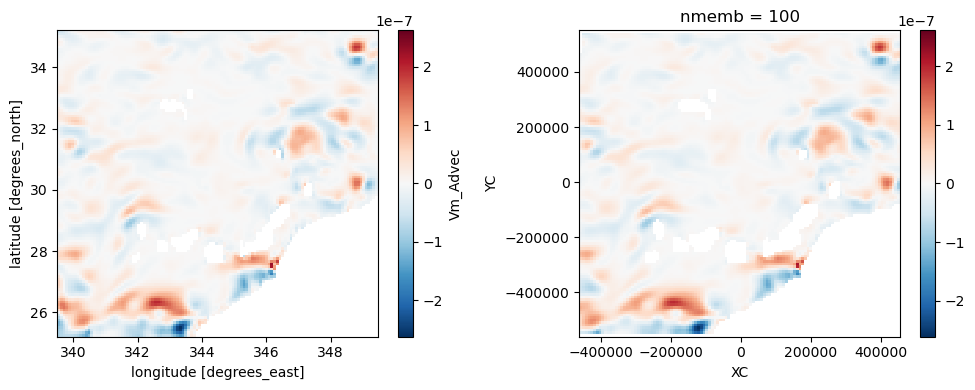

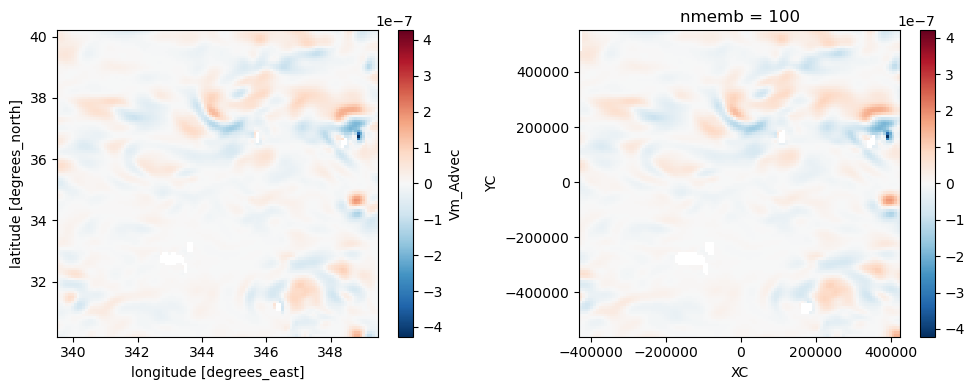

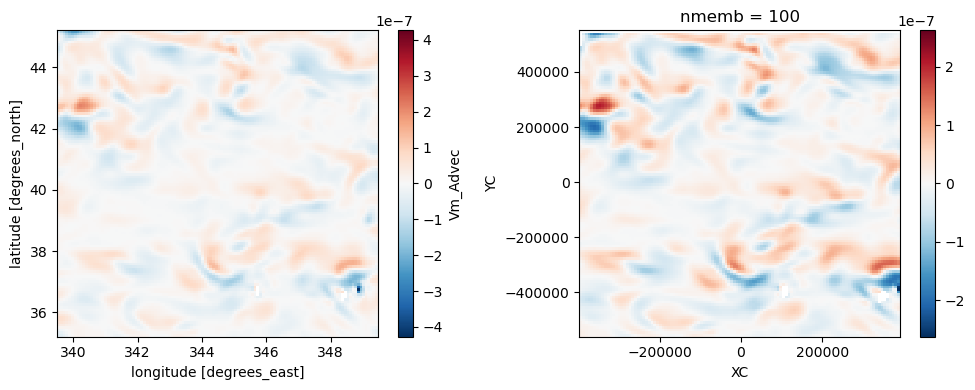

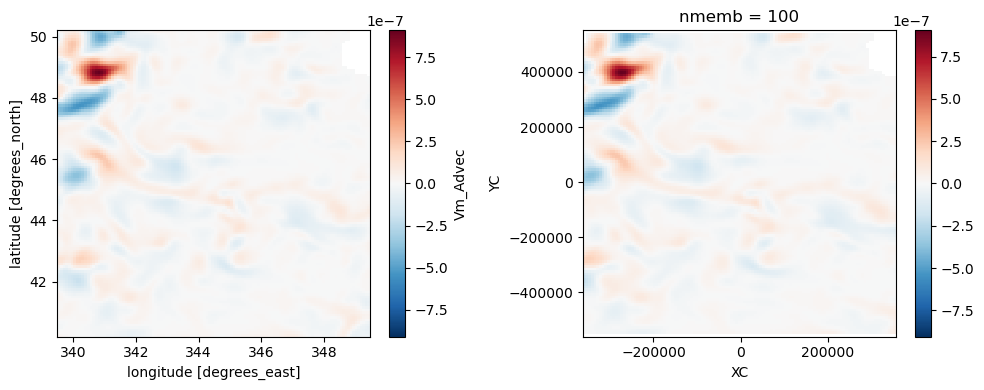

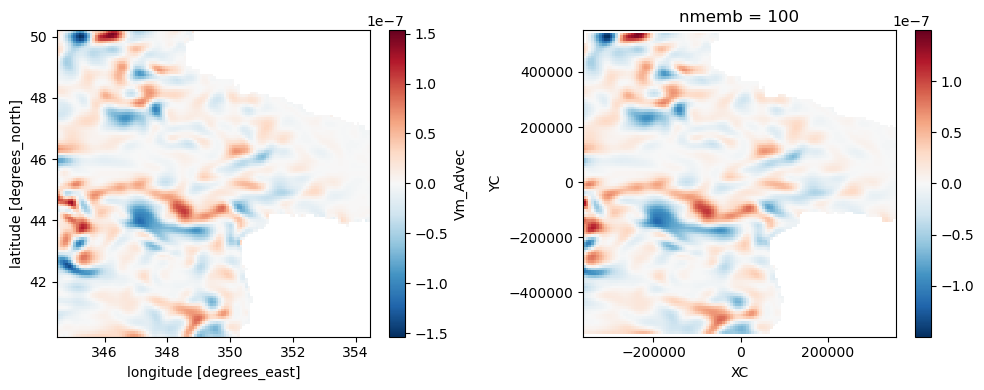

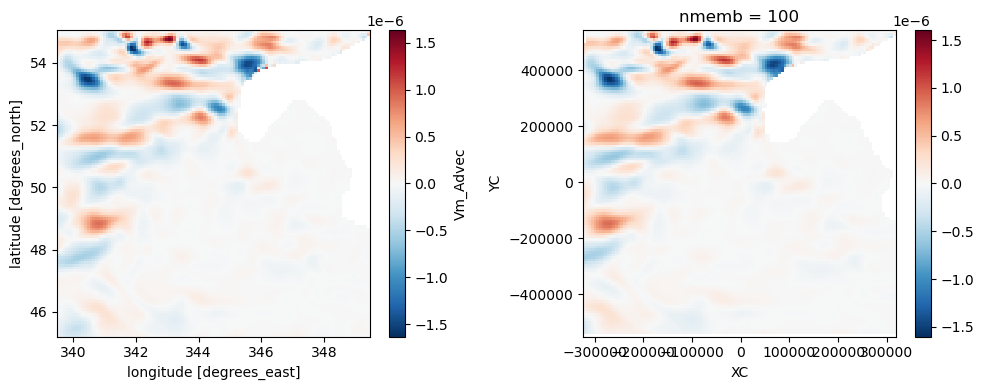

1568160


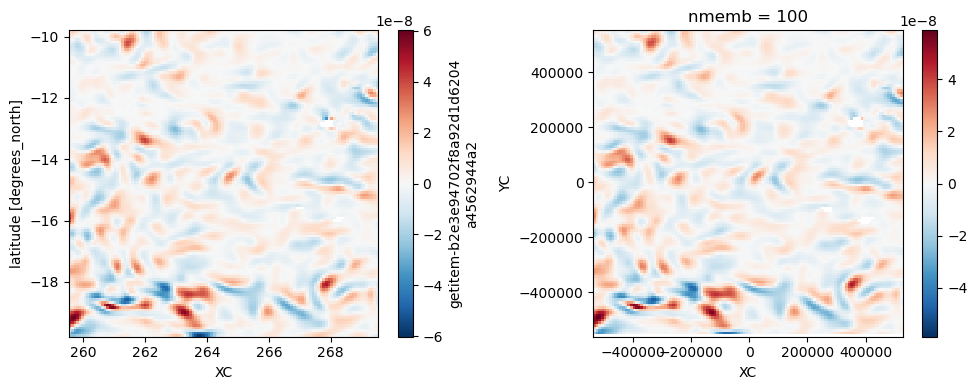

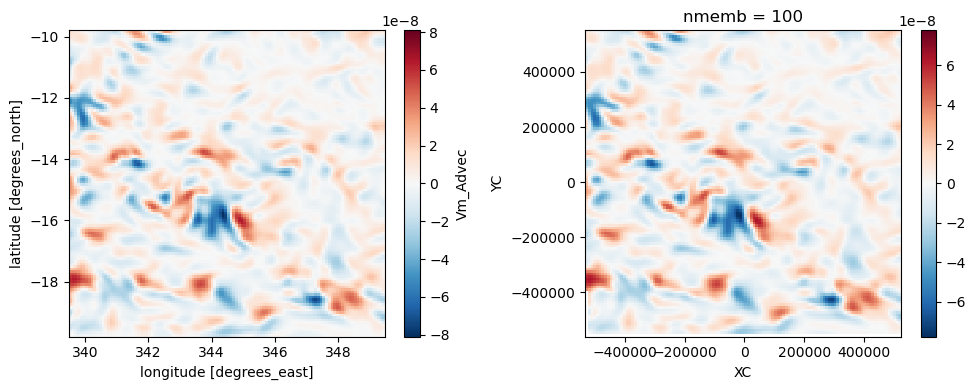

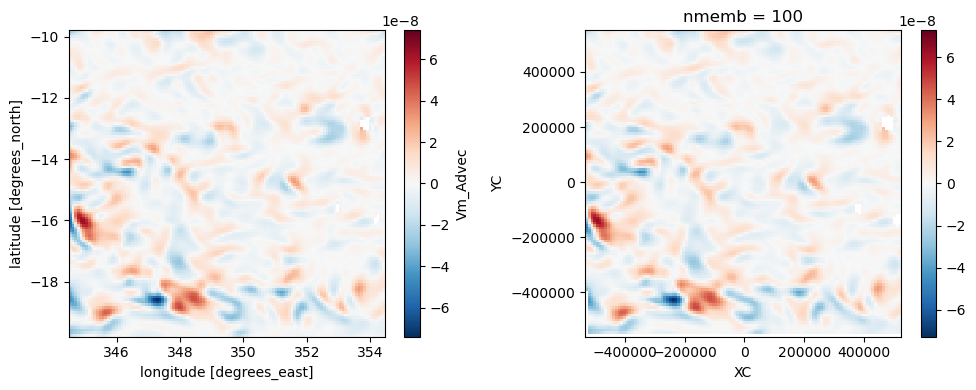

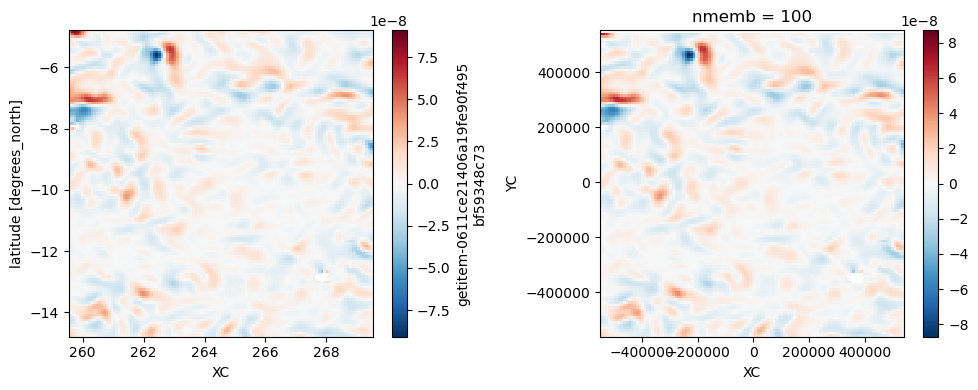

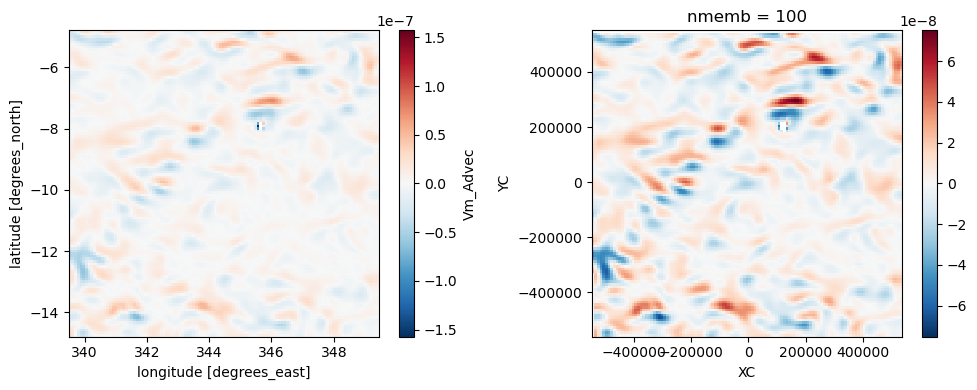

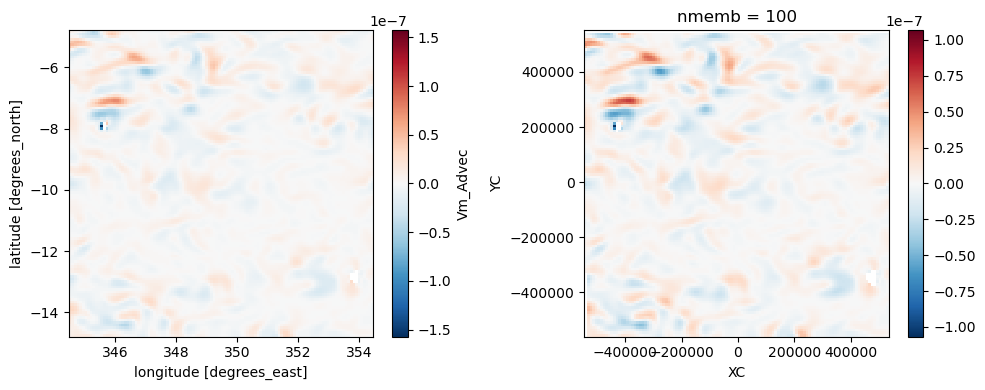

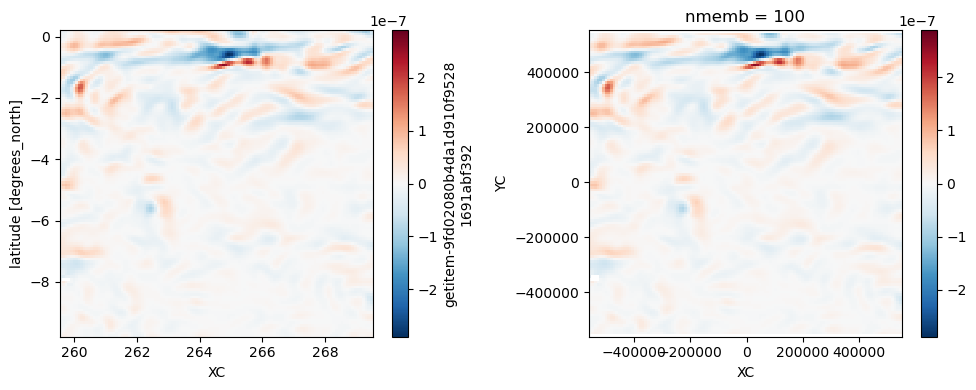

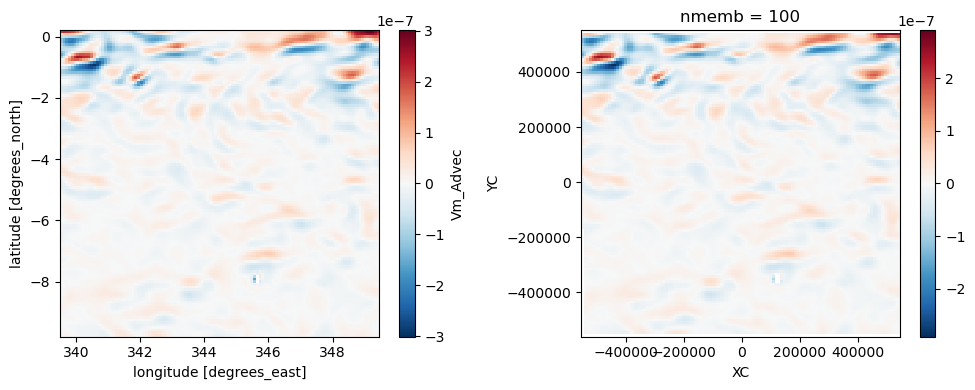

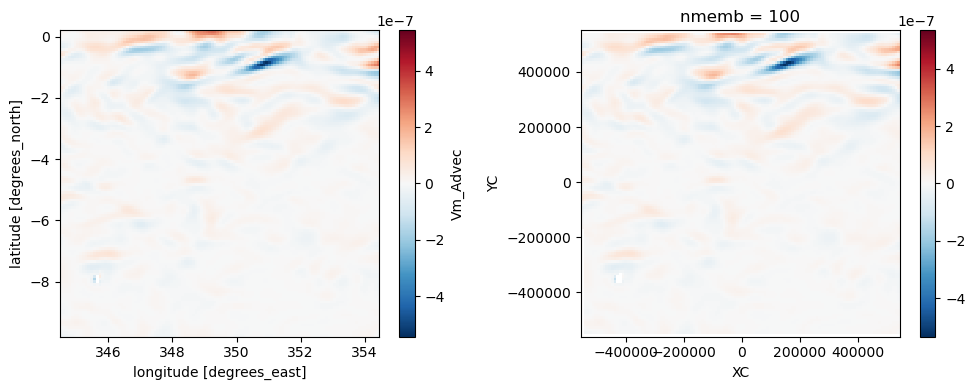

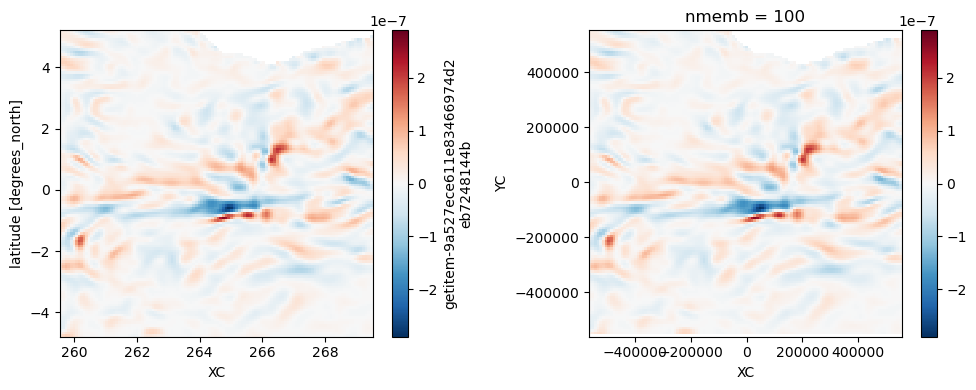

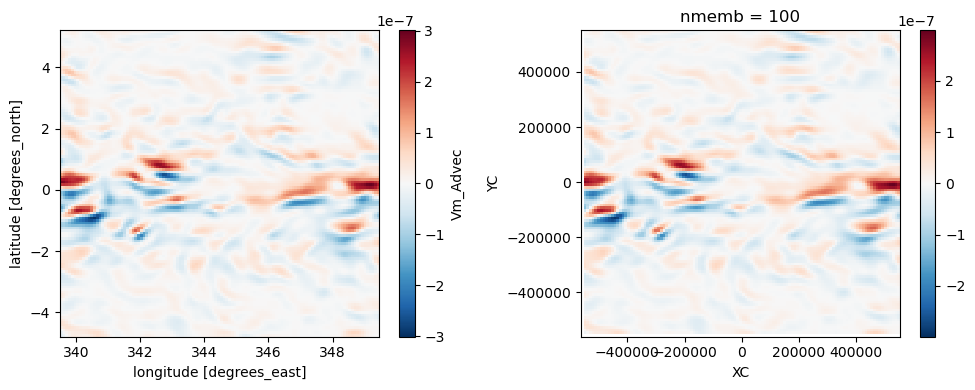

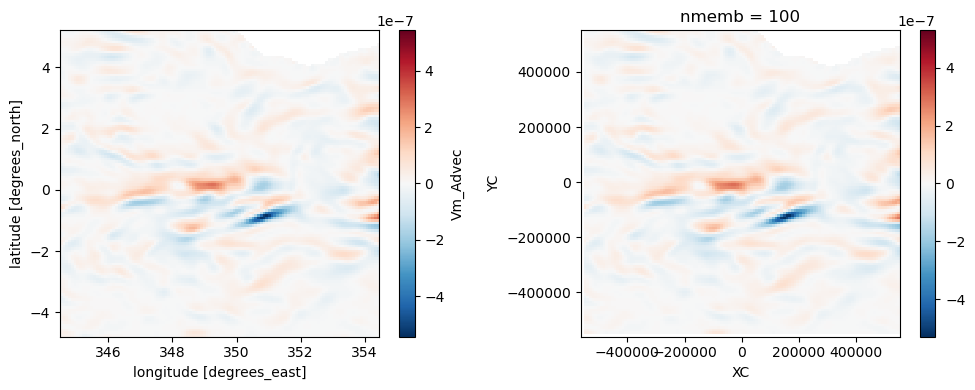

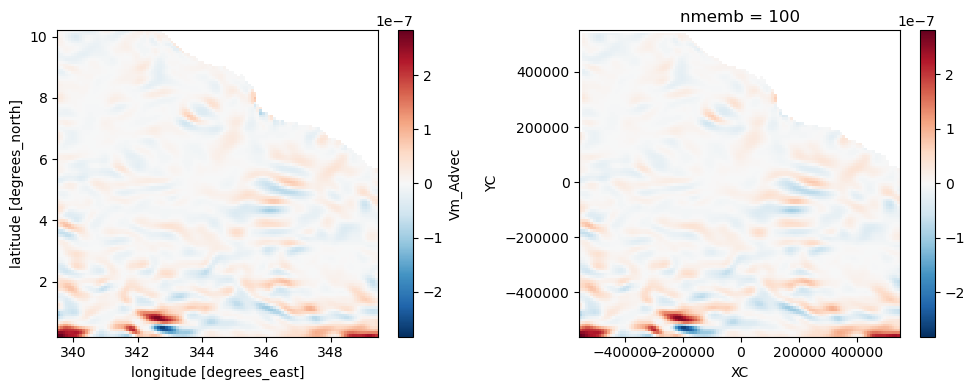

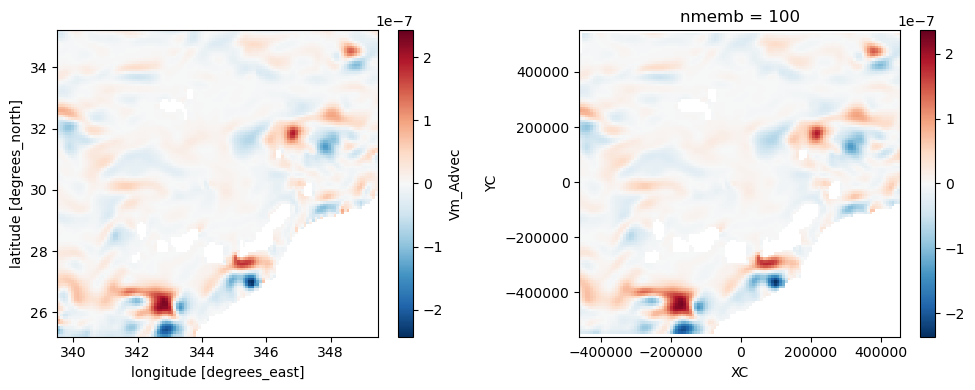

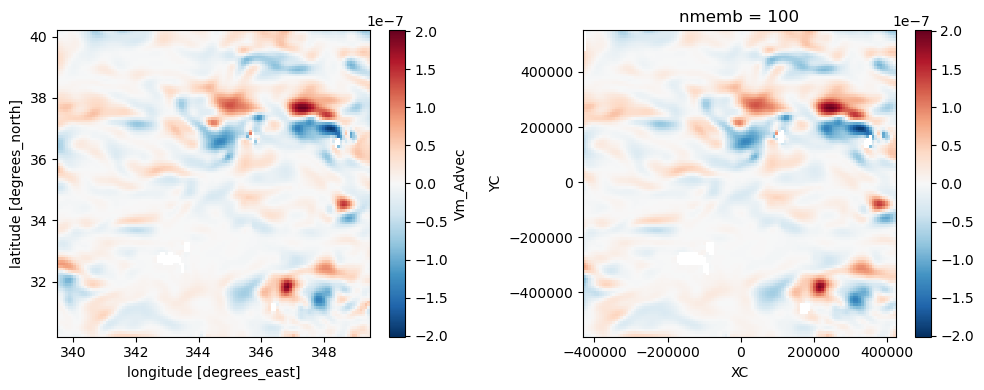

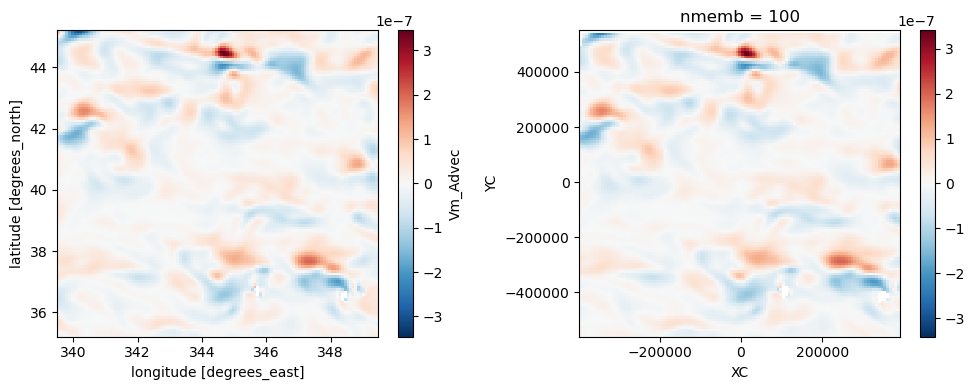

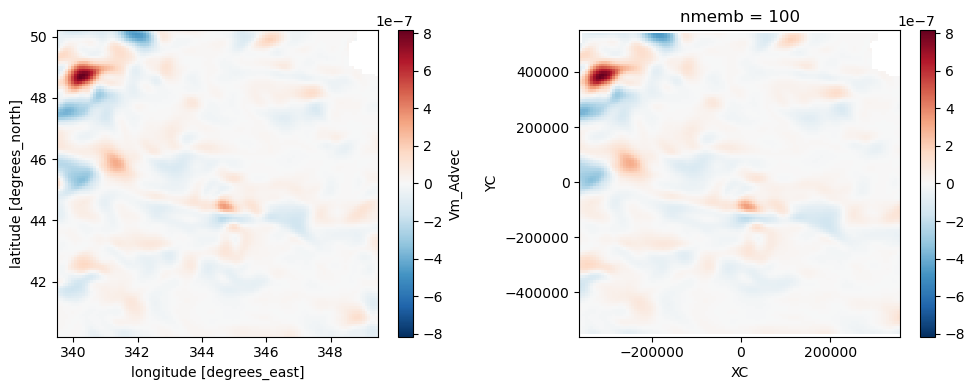

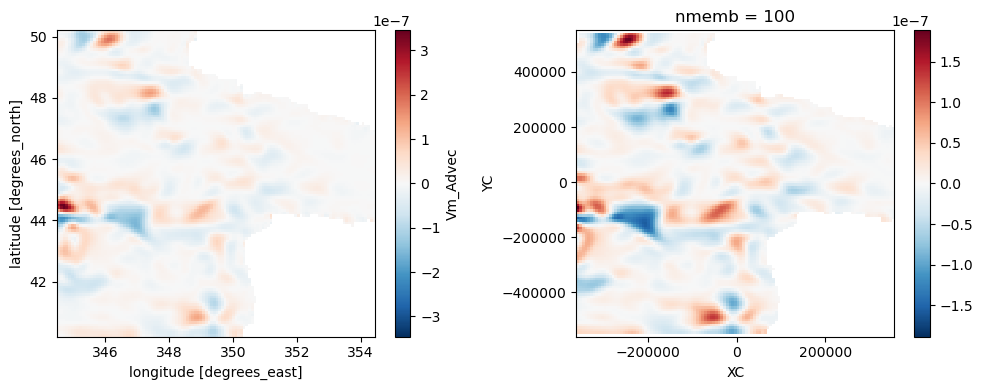

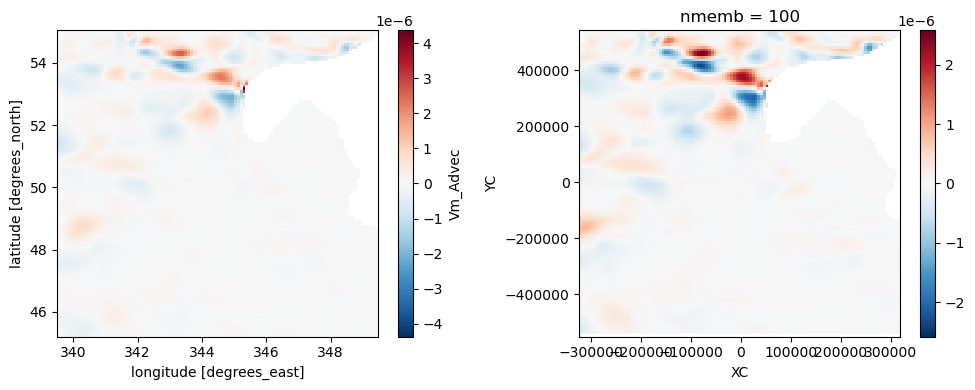

1574640


In [10]:
ystart = ySstart
nmembs = np.arange(100,148)
Zs = [18]

yys = yystart

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,dd:]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes[::3]:
        dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                                      % (year)), 
                              grid_dir=gdir,
                              prefix=['snap_diagOcn',], 
                              delta_t=2e2, iters=itime                              
                             ).isel(time=0,
                                    # Z=slice(17,19),
                                    # Zl=slice(17,19),
                                    # Zu=slice(17,19),
                                    # Zp1=slice(17,20)
                                   ).chunk({'YC':ychunk,'YG':ychunk,
                                            'XC':xchunk,'XG':xchunk})
        coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",  "left" : "XG"},
        "Y": {"center": "YC",  "left" : "YG"},
        # "Z": {"center": "Z",  "outer": "Zp1", 
        #       "left"  : "Zl", 
        #      }
        }
        grid = Grid(dsm, periodic=['X'],
                    coords=coords)
        
        dsu = xr.open_zarr(op.join(diag, 'Snap/Eddy_horiAdv/U_%010d.zarr' 
                                  % itime)
                         ).sel(
                               # YC=slice(15-dg/12,50+dg/12),
                               # YG=slice(15-dg/12,50+dg/12),
                               # XC=slice(273-dg/12,330+dg/12),
                               # XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'YC':ychunk,'YG':ychunk,
                                       'XC':xchunk,'XG':xchunk})
        dsv = xr.open_zarr(op.join(diag, 'Snap/Eddy_horiAdv/V_%010d.zarr' 
                                  % itime)
                         ).sel(
                               # YC=slice(15-dg/12,50+dg/12),
                               # YG=slice(15-dg/12,50+dg/12),
                               # XC=slice(273-dg/12,330+dg/12),
                               # XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'YC':ychunk,'YG':ychunk,
                                       'XC':xchunk,'XG':xchunk})
        
        # dsUVm = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
        #                 grid_dir=gdir,
        #                 prefix=['diagUm','diagVm'], delta_t=2e2,
        #                 iters=itime, 
        #                 ignore_unknown_vars=True
        #                ).isel(time=0,Z=slice(17,19),Zl=slice(17,19),
        #                       Zp1=slice(17,20)
        #                      ).chunk({'YC':ychunk,'YG':ychunk,
        #                               'XC':xchunk,'XG':xchunk})
        
        for imemb in nmembs:
            if imemb == nmembs[0]:
                ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                             % (imemb,year)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn',], 
                                     delta_t=2e2, iters=itime 
                                    ).isel(time=0,
                                           # Z=slice(17,19),
                                           # Zl=slice(17,19),
                                           # Zu=slice(17,19),
                                           # Zp1=slice(17,20)
                                          ).chunk({'YC':ychunk,'YG':ychunk,
                                                   'XC':xchunk,'XG':xchunk})
                dsUV = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                               % (imemb)), 
                               grid_dir=gdir,
                               prefix=['diagUm','diagVm'], delta_t=2e2,
                               iters=itime, 
                               ignore_unknown_vars=True
                              ).reset_coords(drop=True).isel(time=0, 
                                                             Z=Zs,
                                                             Zl=Zs,
                                                             Zu=Zs,
                                                             Zp1=[18,19]
                                                            ).chunk({'YC':ychunk,
                                                                     'YG':ychunk,
                                                                     'XC':xchunk,
                                                                     'XG':xchunk})
            else:
                ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                                            % (imemb,year)), 
                                                    grid_dir=gdir,
                                                    prefix=['snap_diagOcn',], 
                                                    delta_t=2e2, iters=itime
                                                   ).isel(time=0, 
                                                          # Z=slice(17,19),
                                                          # Zl=slice(17,19),
                                                          # Zu=slice(17,19),
                                                          # Zp1=slice(17,20)
                                                         ).chunk({'YC':ychunk,
                                                                  'YG':ychunk,
                                                                  'XC':xchunk,
                                                                  'XG':xchunk})
                               ], 'nmemb')
                dsUV = xr.concat([dsUV, open_mdsdataset(op.join(ddir,
                                                                'memb%03d/run1967/ocn/' 
                                                                % (imemb)), 
                                                        grid_dir=gdir,
                                                        prefix=['diagUm','diagVm'], 
                                                        delta_t=2e2,
                                                        iters=itime, 
                                                        ignore_unknown_vars=True
                                                       ).reset_coords(drop=True
                                                                     ).isel(time=0,
                                                                 Z=Zs,
                                                                 Zl=Zs,
                                                                 Zu=Zs,
                                                                 Zp1=[18,19]
                                                                ).chunk({'YC':ychunk,
                                                                         'YG':ychunk,
                                                                         'XC':xchunk,
                                                                         'XG':xchunk})
                               ], 'nmemb')
        
        ds.coords['nmemb'] = nmembs
        dse = ds - dsm
        dsUV.coords['nmemb'] = nmembs
        dsUVm = dsUV.mean('nmemb')
        dsUVp = dsUV - dsUVm
###########################
        xA = (dse.dyG * dse.drF).reset_coords(drop=True)
        yA = (dse.dxG * dse.drF).reset_coords(drop=True)
###########################
        # ub = dsm.UVEL
        # vb = dsm.VVEL
        # upTrans = dse.UVEL * xA
        # vpTrans = dse.VVEL * yA
        # rpTrans = grid.interp(dse.WVEL,'X'
        #                      ) * ds.rAw
        # Auub = (grid.interp(upTrans,'X')
        #     * grid.interp(ub,'X')
        #    )
        # Avub = (grid.interp(vpTrans,'X')
        #     * grid.interp(ub,'Y',boundary='extend')
        #    )
        # Awub = (rpTrans
        #     * grid.interp(ub,'Z',boundary='extend')
        #    )
        # rpTrans = grid.interp(dse.WVEL,'Y',boundary='extend'
        #                      ) * ds.rAs
        # Auvb = (grid.interp(upTrans,'Y',boundary='extend')
        #     * grid.interp(vb,'X')
        #    )
        # Avvb = (grid.interp(vpTrans,'Y',boundary='extend')
        #     * grid.interp(vb,'Y',boundary='extend')
        #    )
        # Awvb = (rpTrans
        #     * grid.interp(vb,'Z',boundary='extend')
        #    )
        # Autu = grid.interp(((grid.diff(Auub,'X')
        #                      + grid.diff(Avub,'Y',boundary='extend')
        #                      - grid.diff(Awub,'Z',boundary='extend')
        #                     ) / ds.drF/ds.rAw
        #                    ).reset_coords(drop=True),
        #                    'X'
        #                   ).where(ds.maskC!=0.).isel(Z=1)
        # Avtv = grid.interp(((grid.diff(Auvb,'X')
        #                      + grid.diff(Avvb,'Y',boundary='extend')
        #                      - grid.diff(Awvb,'Z',boundary='extend')
        #                     ) / ds.drF/ds.rAs
        #                    ).reset_coords(drop=True),
        #                    'Y',boundary='extend'
        #                   ).where(ds.maskC!=0.).isel(Z=1)
        Avtv = advec_vm(dse, dsm.VVEL)
        Autu = advec_um(dse, dsm.UVEL)

        # Avtv = Avtv.isel(Z=1)
        # Autu = Autu.isel(Z=1)
#         for imemb in nmembs:
#             if imemb == 100:
#                 Avtv = advec_vm(dse.sel(nmemb=imemb), 
#                                 dsm.VVEL.data)
#                 Autu = advec_um(dse.sel(nmemb=imemb), 
#                                 dsm.UVEL.data)

#                 Avtv = Avtv.isel(Z=1)
#                 Autu = Autu.isel(Z=1)
#             else:
#                 _Vm_Advec = advec_vm(dse.sel(nmemb=imemb), 
#                                      dsm.VVEL.data)
#                 _Um_Advec = advec_um(dse.sel(nmemb=imemb), 
#                                      dsm.UVEL.data)

#                 Avtv = xr.concat([Avtv, _Vm_Advec.isel(Z=1)], 'nmemb')
#                 Autu = xr.concat([Autu, _Um_Advec.isel(Z=1)], 'nmemb')

#                 del _Vm_Advec, _Um_Advec
#         Avtv.coords['nmemb'] = nmembs
#         Autu.coords['nmemb'] = nmembs
        Avtv = grid.interp(Avtv, 'Y', boundary='extend'
                          ).where(ds.maskC!=0.).isel(Z=Zs[0])
        Autu = grid.interp(Autu, 'X'
                          ).where(ds.maskC!=0.).isel(Z=Zs[0])
###########################
        # uTrans = ds.UVEL * xA
        # vTrans = ds.VVEL * yA
        # # rTrans = grid.interp(ds.WVEL,'X',boundary='extend') * ds.rAw
        # Auup = (grid.interp(uTrans,'X')
        #         * grid.interp(dse.UVEL,'X')
        #        )
        # Avup = (grid.interp(vTrans,'X')
        #         * grid.interp(dse.UVEL,'Y',boundary='extend')
        #        )
        # # Awup = (rTrans
        # #         * grid.interp(up,'Z',boundary='extend')
        # #        )
        # # rTrans = grid.interp(ds.WVEL,'Y',boundary='extend') * ds.rAs
        # Auvp = (grid.interp(uTrans,'Y',boundary='extend')
        #         * grid.interp(dse.VVEL,'X')
        #        )
        # Avvp = (grid.interp(vTrans,'Y',boundary='extend')
        #         * grid.interp(dse.VVEL,'Y',boundary='extend')
        #        )
        # # Awvp = (rTrans
        # #         * grid.interp(vp,'Z',boundary='extend')
        # #        )
        # Auhu = grid.interp(((grid.diff(Auup,'X')
        #                     + grid.diff(Avup,'Y',boundary='extend')
        #                     # - grid.diff(Awup,'Z',boundary='extend')
        #                    ) / ds.drF/ds.rAw
        #                   ).reset_coords(drop=True),
        #                   'X'
        #                  ).where(ds.maskC!=0.).isel(Z=1)
        # Avhv = grid.interp(((grid.diff(Auvp,'X')
        #                     + grid.diff(Avvp,'Y',boundary='extend')
        #                     # - grid.diff(Awvp,'Z',boundary='extend')
        #                    ) / ds.drF/ds.rAs
        #                   ).reset_coords(drop=True),
        #                   'Y',boundary='extend'
        #                  ).where(ds.maskC!=0.).isel(Z=1)
#         Avhv, _, _ = hori_advec_vm(ds, dse.VVEL)
#         Auhu, _, _ = hori_advec_um(ds, dse.UVEL)

#         Avhv = Avhv.isel(Z=1)
#         Auhu = Auhu.isel(Z=1)

#         for imemb in nmembs:
#             if imemb == 100:
#                 Avhv, _, _ = hori_advec_vm(ds.sel(nmemb=imemb), 
#                                            dse.VVEL.sel(nmemb=imemb).data)
#                 Auhu, _, _ = hori_advec_um(ds.sel(nmemb=imemb), 
#                                            dse.UVEL.sel(nmemb=imemb).data)

#                 Avhv = Avhv.isel(Z=1)
#                 Auhu = Auhu.isel(Z=1)
#             else:
#                 _Vm_Advec, _, _ = hori_advec_vm(ds.sel(nmemb=imemb), 
#                                                 dse.VVEL.sel(nmemb=imemb
#                                                             ).data)
#                 _Um_Advec, _, _ = hori_advec_um(ds.sel(nmemb=imemb), 
#                                                 dse.UVEL.sel(nmemb=imemb
#                                                             ).data)

#                 Avhv = xr.concat([Avhv, _Vm_Advec.isel(Z=1)], 'nmemb')
#                 Auhu = xr.concat([Auhu, _Um_Advec.isel(Z=1)], 'nmemb')

#                 del _Vm_Advec, _Um_Advec
#         Avhv.coords['nmemb'] = nmembs
#         Auhu.coords['nmemb'] = nmembs
        grid1 = Grid(dsm.isel(Z=Zs,Zl=Zs,Zu=Zs,Zp1=[18,19]), 
                     periodic=['X'],
                     coords=coords
                    )
        Avhv = grid1.interp(dsv.Vm_Advec, 'Y', boundary='extend'
                           ).where(ds.maskC.isel(Z=Zs)!=0.
                                  ).isel(Z=0)
        Auhu = grid1.interp(dsu.Um_Advec, 'X'
                           ).where(ds.maskC.isel(Z=Zs)!=0.
                                  ).isel(Z=0)
###########################
        Aupu = grid1.interp(dsUVp.Um_Advec,'X'
                           ).where(ds.maskC.isel(Z=Zs)!=0.
                                  ).isel(Z=0)
        Avpv = grid1.interp(dsUVp.Vm_Advec,'Y',boundary='extend'
                           ).where(ds.maskC.isel(Z=Zs)!=0.
                                  ).isel(Z=0)
###########################
        UV = grid.interp(dse.UVEL,'X').where(ds.maskC!=0.).isel(Z=Zs[0])
        VV = grid.interp(dse.VVEL,'Y',boundary='extend'
                        ).where(ds.maskC!=0.).isel(Z=Zs[0])
        XT = grid.cumsum(ds.dxC,'X')
        YT = grid.cumsum(ds.dyC,'Y',boundary='extend')
        area = ds.rA.where(ds.maskC.isel(Z=Zs[0])!=0.
                          ).reset_coords(drop=True)
        
        if itime == mtimes[0]:
            lat_range = np.arange(ystart,yend+5,5)[5:-1]
        else:
            lat_range = np.arange(ystart,yend+5,5)[:-1]
        for lat in lat_range:
            Aut = Autu.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Avt = Avtv.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Auh = Auhu.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Avh = Avhv.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Aup = Aupu.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Avp = Avpv.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Avp = Avp.where(np.isfinite(Avp)
                           )
            Aup = Aup.where(np.isfinite(Aup)
                           )
            Avt = Avt.where(np.isfinite(Avt)
                           )
            Aut = Aut.where(np.isfinite(Aut)
                           )
            Avh = Avh.where(np.isfinite(Avh)
                           )
            Auh = Auh.where(np.isfinite(Auh)
                           )
            U = UV.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            V = VV.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            X = XT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Y = YT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            mask = dse.maskC.isel(Z=Zs[0]).sel(YC=slice(lat,lat+10)
                                              ).reset_coords(drop=True)
            for lon in np.arange(dsm.XC.min()-2.5,dsm.XC.max(),5):        
                xend = lon + 10
                if lon < dsm.XC.min():
                    dlon = dsm.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(dsm.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                          coords={'YC':m.YC,
                                                  'XC':np.linspace(lon,
                                                                   lon+dlon,
                                                                   num=len(mm.XC)+1,
                                                                   endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    if mmm.astype(float).sum()/np.array(mmm.shape).prod() > critt:
                        aut = Aut.sel(XC=slice(None,xend))
                        avt = Avt.sel(XC=slice(None,xend))
                        auh = Auh.sel(XC=slice(None,xend))
                        avh = Avh.sel(XC=slice(None,xend))
                        aup = Aup.sel(XC=slice(None,xend))
                        avp = Avp.sel(XC=slice(None,xend))
                        u   = U.sel(XC=slice(None,xend))
                        v   = V.sel(XC=slice(None,xend))
                        x   = X.sel(XC=slice(None,xend))
                        y   = Y.sel(XC=slice(None,xend))
                        ddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                         ).reset_coords(drop=True)
                        ddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                         ).reset_coords(drop=True)
                        a   = area.sel(YC=slice(lat,lat+10),
                                       XC=slice(None,xend)
                                      )
                        auut = Aut.sel(XC=slice(dsm.XC.max()-dlon,None))
                        avvt = Avt.sel(XC=slice(dsm.XC.max()-dlon,None))
                        auuh = Auh.sel(XC=slice(dsm.XC.max()-dlon,None))
                        avvh = Avh.sel(XC=slice(dsm.XC.max()-dlon,None))
                        auup = Aup.sel(XC=slice(dsm.XC.max()-dlon,None))
                        avvp = Avp.sel(XC=slice(dsm.XC.max()-dlon,None))
                        uu   = U.sel(XC=slice(dsm.XC.max()-dlon,None))
                        vv   = V.sel(XC=slice(dsm.XC.max()-dlon,None))
                        xx   = (X.sel(XC=slice(dsm.XC.max()-dlon,None))
                                - X.sel(XC=slice(dsm.XC.max()-dlon,None)).isel(XC=0))
                        x    = x + xx.isel(XC=-1)
                        # x.plot()
                        # plt.show()
                        yy   = Y.sel(XC=slice(dsm.XC.max()-dlon,None))
                        aa   = area.sel(YC=slice(lat,lat+10),
                                        XC=slice(dsm.XC.max()-dlon,None)
                                       )
                        dddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                          ).reset_coords(drop=True)
                        dddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                          ).reset_coords(drop=True)
                        auuut = xr.concat([xr.DataArray(auut.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         aut
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        avvvt = xr.concat([xr.DataArray(avvt.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         avt
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        auuuh = xr.concat([xr.DataArray(auuh.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         auh
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        avvvh = xr.concat([xr.DataArray(avvh.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         avh
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        auuup = xr.concat([xr.DataArray(auup.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         aup
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        avvvp = xr.concat([xr.DataArray(avvp.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         avp
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        uuu = xr.concat([xr.DataArray(uu.data, 
                                                      dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         u
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        vvv = xr.concat([xr.DataArray(vv.data, 
                                                      dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         v
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        xT = xr.concat([xr.DataArray(xx.data, 
                                                     dims=['YC','XC'],
                                             coords={'YC':X.YC,
                                                     'XC':np.linspace(lon,
                                                                      lon+dlon,
                                                                      num=len(xx.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    ),
                                        x
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([xr.DataArray(yy.data, 
                                                     dims=['YC','XC'],
                                             coords={'YC':Y.YC,
                                                     'XC':np.linspace(lon,
                                                                      lon+dlon,
                                                                      num=len(yy.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    ),
                                        y
                                       ], 'XC').sortby('XC')
                        A = xr.concat([xr.DataArray(aa.data, 
                                                    dims=['YC','XC'],
                                            coords={'YC':a.YC,
                                                    'XC':np.linspace(lon,
                                                                     lon+dlon,
                                                                     num=len(aa.XC)+1,
                                                                     endpoint=False
                                                                    )[1:]}
                                                   ),
                                       a
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([xr.DataArray(dddx.data, 
                                                     dims=['YC','XG'],
                                             coords={'YC':ddx.YC,
                                                     'XG':np.linspace(dsm.XG.min()-dlon,
                                                                      dsm.XG.min(),
                                                                      num=len(dddx.XG)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    ),
                                        ddx
                                       ], 'XG').min().values
                        dy = xr.concat([xr.DataArray(dddy.data, 
                                                     dims=['YG','XC'],
                                             coords={'YG':ddy.YG,
                                                     'XC':np.linspace(lon,
                                                                      lon+dlon,
                                                                      num=len(dddy.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    ),
                                        ddy
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        AUterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AVterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AUherp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AVherp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AUperp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AVperp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            AUterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (auuut.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (avvvt.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            AUherp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (auuuh.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVherp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (avvvh.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            AUperp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (auuup.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVperp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (avvvp.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T

                        Aterp = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        AUterp  = AUterp / Aterp
                        AVterp  = AVterp / Aterp
                        AUherp  = AUherp / Aterp
                        AVherp  = AVherp / Aterp
                        AUperp  = AUperp / Aterp
                        AVperp  = AVperp / Aterp
                        Uterp  = Uterp / Aterp
                        Vterp  = Vterp / Aterp
                        # if itime == mtimes[0]:
                        fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, 
                                                      ncols=2)
                        fig.set_tight_layout(True)
                        auuuh.isel(nmemb=0).plot(ax=ax1, rasterized=True)
                        AUherp.isel(nmemb=0).plot(ax=ax2, rasterized=True)
                        plt.show()
                            
                elif xend > dsm.XC.max():
                    dlon = -dsm.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,dsm.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                              coords={'YC':m.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(mm.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    if mmm.astype(float).sum().values/np.array(mmm.shape).prod() > critt:
                        aut = Aut.sel(XC=slice(lon,None))
                        avt = Avt.sel(XC=slice(lon,None))
                        auh = Auh.sel(XC=slice(lon,None))
                        avh = Avh.sel(XC=slice(lon,None))
                        aup = Aup.sel(XC=slice(lon,None))
                        avp = Avp.sel(XC=slice(lon,None))
                        u   = U.sel(XC=slice(lon,None))
                        v   = V.sel(XC=slice(lon,None))
                        x   = X.sel(XC=slice(lon,None))
                        y   = Y.sel(XC=slice(lon,None))
                        ddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,None)
                                         ).reset_coords(drop=True)
                        ddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,None)
                                         ).reset_coords(drop=True)
                        a   = area.sel(YC=slice(lat,lat+10),
                                       XC=slice(lon,None)
                                      )
                        auut = Aut.sel(XC=slice(None,dsm.XC.min()+dlon))
                        avvt = Avt.sel(XC=slice(None,dsm.XC.min()+dlon))
                        auuh = Auh.sel(XC=slice(None,dsm.XC.min()+dlon))
                        avvh = Avh.sel(XC=slice(None,dsm.XC.min()+dlon))
                        auup = Aup.sel(XC=slice(None,dsm.XC.min()+dlon))
                        avvp = Avp.sel(XC=slice(None,dsm.XC.min()+dlon))
                        uu   = U.sel(XC=slice(None,dsm.XC.min()+dlon))
                        vv   = V.sel(XC=slice(None,dsm.XC.min()+dlon))
                        xx   = X.sel(XC=slice(None,dsm.XC.min()+dlon))+X.isel(XC=-1)
                        yy   = Y.sel(XC=slice(None,dsm.XC.min()+dlon))
                        aa   = area.sel(YC=slice(lat,lat+10),
                                        XC=slice(None,dsm.XC.min()+dlon)
                                       )
                        dddx = dse.dxC.sel(YC=slice(lat,lat+10),
                                           XG=slice(None,dsm.XG.min()+dlon)
                                          ).reset_coords(drop=True)
                        dddy = dse.dyC.sel(YG=slice(lat,lat+10),
                                           XC=slice(None,dsm.XG.min()+dlon)
                                          ).reset_coords(drop=True)
                        auuut = xr.concat([aut,
                                         xr.DataArray(auut.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        avvvt = xr.concat([avt,
                                         xr.DataArray(avvt.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        auuuh = xr.concat([auh,
                                         xr.DataArray(auuh.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        avvvh = xr.concat([avh,
                                         xr.DataArray(avvh.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        auuup = xr.concat([aup,
                                         xr.DataArray(auup.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        avvvp = xr.concat([avp,
                                         xr.DataArray(avvp.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        uuu = xr.concat([u,
                                         xr.DataArray(uu.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        vvv = xr.concat([v,
                                         xr.DataArray(vv.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        xT = xr.concat([x,
                                        xr.DataArray(xx.data, dims=['YC','XC'],
                                             coords={'YC':X.YC,
                                                     'XC':np.linspace(dsm.XC.max(),
                                                                      dsm.XC.max()+dlon,
                                                                      num=len(xx.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([y,
                                        xr.DataArray(yy.data, dims=['YC','XC'],
                                             coords={'YC':Y.YC,
                                                     'XC':np.linspace(dsm.XC.max(),
                                                                      dsm.XC.max()+dlon,
                                                                      num=len(yy.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        A = xr.concat([a,
                                       xr.DataArray(aa.data, dims=['YC','XC'],
                                            coords={'YC':a.YC,
                                                    'XC':np.linspace(dsm.XC.max(),
                                                                     dsm.XC.max()+dlon,
                                                                     num=len(aa.XC)+1,
                                                                     endpoint=False
                                                                    )[1:]}
                                                   )
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([ddx,
                                        xr.DataArray(dddx.data, dims=['YC','XG'],
                                             coords={'YC':ddx.YC,
                                                     'XG':np.linspace(dsm.XG.max(),
                                                                      dsm.XG.max()+dlon,
                                                                      num=len(dddx.XG)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    )
                                       ], 'XG').min().values
                        dy = xr.concat([ddy,
                                        xr.DataArray(dddy.data, dims=['YG','XC'],
                                             coords={'YG':ddy.YG,
                                                     'XC':np.linspace(dsm.XC.max(),
                                                                      dsm.XC.max()+dlon,
                                                                      num=len(dddy.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    )
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        AUterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AVterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AUherp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AVherp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AUperp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AVperp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            AUterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (auuut.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (avvvt.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            AUherp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (auuuh.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVherp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (avvvh.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            AUperp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (auuup.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVperp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (avvvp.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 

                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                        Aterp = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        AUterp = AUterp / Aterp
                        AVterp = AVterp / Aterp
                        AUherp = AUherp / Aterp
                        AVherp = AVherp / Aterp
                        AUperp = AUperp / Aterp
                        AVperp = AVperp / Aterp
                        Uterp = Uterp / Aterp
                        Vterp = Vterp / Aterp
                        # if itime == mtimes[dd]:
                        fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, 
                                                      ncols=2)
                        fig.set_tight_layout(True)
                        avvvh.isel(nmemb=0).plot(ax=ax1, rasterized=True)
                        AVherp.isel(nmemb=0).plot(ax=ax2, rasterized=True)
                        plt.show()
                else:
                    mmm = mask.sel(XC=slice(lon,xend))
                    if mmm.astype(float).sum().values/np.array(mmm.shape).prod() > critt:
                        auuut = Aut.sel(XC=slice(lon,xend))
                        avvvt = Avt.sel(XC=slice(lon,xend))
                        auuuh = Auh.sel(XC=slice(lon,xend))
                        avvvh = Avh.sel(XC=slice(lon,xend))
                        auuup = Aup.sel(XC=slice(lon,xend))
                        avvvp = Avp.sel(XC=slice(lon,xend))
                        uuu   = U.sel(XC=slice(lon,xend))
                        vvv   = V.sel(XC=slice(lon,xend))
                        xT    = X.sel(XC=slice(lon,xend))
                        yT    = Y.sel(XC=slice(lon,xend))
                        A     = area.sel(YC=slice(lat,lat+10),
                                         XC=slice(lon,xend)
                                        )
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,xend)
                                       ).min().values
                        dy = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,xend)
                                       ).min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        AUterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AVterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AUherp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AVherp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AUperp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AVperp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            AUterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (auuut*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (avvvt*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            AUherp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (auuuh*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVherp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (avvvh*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            AUperp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (auuup*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVperp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (avvvp*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                        Aterp = griddata((xT, yT), 
                                         ds.rA.sel(YC=slice(lat,lat+10),
                                                   XC=slice(lon,xend)).values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        AUterp = AUterp / Aterp
                        AVterp = AVterp / Aterp
                        AUherp = AUherp / Aterp
                        AVherp = AVherp / Aterp
                        AUperp = AUperp / Aterp
                        AVperp = AVperp / Aterp
                        Uterp = Uterp / Aterp
                        Vterp = Vterp / Aterp
                        if lon == dsm.XC.min():
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), 
                                                          nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            avvvh.isel(nmemb=0).plot(ax=ax1, rasterized=True)
                            AVherp.isel(nmemb=0).plot(ax=ax2, rasterized=True)
                            plt.show()
                
                
                if mmm.astype(float).sum().values/np.array(mmm.shape).prod() > critt:
                    iso_csUf = xrft.isotropic_power_spectrum(
                                Uterp.interpolate_na(dim='XC'
                                                    ).interpolate_na(dim='YC').fillna(0.),  
                                dim=["YC", "XC"], window='hann', 
                                window_correction=True, true_amplitude=True, 
                                truncate=True
                    )
                    # iso_csUf = xrft.isotropic_cross_spectrum(
                                # Uterp.interpolate_na(dim='XC'
                                #                     ).interpolate_na(dim='YC'
                                #                                     ).fillna(0.), 
                                # AUterp.interpolate_na(dim='XC'
                                #                      ).interpolate_na(dim='YC'
                                #                                      ).fillna(0.), 
                    #             dim=["YC", "XC"], window='hann', 
                    #         window_correction=True, true_amplitude=True, truncate=True
                    # ) 
                    # iso_csVf = xrft.isotropic_cross_spectrum(
                    #             Vterp.interpolate_na(dim='YC'
                    #                                 ).interpolate_na(dim='XC'
                    #                                                 ).fillna(0.), 
                    #             AVterp.interpolate_na(dim='YC'
                    #                                  ).interpolate_na(dim='XC'
                    #                                                  ).fillna(0.), 
                    #             dim=["YC", "XC"], window='hann', 
                    #         window_correction=True, true_amplitude=True, truncate=True
                    # )
                    # if itime == mtimes[0] and lon == dsm.XC.min():
                    #     fig, ax = plt.subplots()
                    #     ax.plot(iso_csUf.freq_r*1e3, 
                    #             -.5*(iso_csUf + iso_csVf).mean('nmemb'))
                    #     ax.set_xscale('log')
                    #     plt.show()
                    # dsave = iso_csUf.to_dataset(name='U')
                    # dsave['V'] = iso_csVf
                    la = A.YC.mean().values
                    lo = A.XC.mean().values
                    # if la < 0.:
                    #     fname = (
                    #   'Z0452/MOM/Snap/%010d/Fourier/CrossSpectra/Lat-%03d_Lon%03d.zarr' 
                    #              % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    # else:
                    #     fname = (
                    #   'Z0452/MOM/Snap/%010d/Fourier/CrossSpectra/Lat%03d_Lon%03d.zarr' 
                    #              % (itime,np.floor(la),np.floor(lo)))
                    # dsave.attrs['Lat'] = la
                    # dsave.attrs['Lon'] = lo
                    # dsave.to_zarr(op.join(spec,fname), mode='w')
                    # dsave.close()

                    ss = xr.DataArray(np.linspace(iso_csUf.freq_r[-1].data**-1,
                                                  iso_csUf.freq_r[0].data**-1,40
                                                 )/xo,
                                      dims=['scale'], 
                              coords={'scale':np.linspace(iso_csUf.freq_r[-1].data**-1,
                                                          iso_csUf.freq_r[0].data**-1,40
                                                         )/xo}
                    )
                    ssf = xr.DataArray(iso_csUf.freq_r.data**-1/xo, dims=['scale'], 
                                       coords={'scale':iso_csUf.freq_r.data**-1/xo}
                                      )
                    ssh = xr.concat([ss.where(ss>50e3/xo).dropna('scale')[::-1],
                                     ssf.where(ssf<50e3/xo).dropna('scale')
                                    ], 'scale')
                    iso_csUw = xwavelet.wvlt_cross_spectrum(
                                    Uterp.chunk({'nmemb':1}), AUterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    ) 
                    iso_csVw = xwavelet.wvlt_cross_spectrum(
                                    Vterp.chunk({'nmemb':1}), AVterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    )
                    if la < 0.:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/ShProd/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/ShProd/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave = iso_csUw.to_dataset(name='U')
                    dsave['V'] = iso_csVw
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()
                    del iso_csUw, iso_csVw, AUterp, AVterp
                    iso_csUw = xwavelet.wvlt_cross_spectrum(
                                    Uterp.chunk({'nmemb':1}), AUperp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    ) 
                    iso_csVw = xwavelet.wvlt_cross_spectrum(
                                    Vterp.chunk({'nmemb':1}), AVperp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    )
                    if la < 0.:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/Adv/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/Adv/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave = iso_csUw.to_dataset(name='U')
                    dsave['V'] = iso_csVw
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()
                    del iso_csUw, iso_csVw, AUperp, AVperp
                    iso_csUw = xwavelet.wvlt_cross_spectrum(
                                    Uterp.chunk({'nmemb':1}), AUherp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    ) 
                    iso_csVw = xwavelet.wvlt_cross_spectrum(
                                    Vterp.chunk({'nmemb':1}), AVherp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    )
                    if la < 0.:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/HorAdv/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/HorAdv/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave = iso_csUw.to_dataset(name='U')
                    dsave['V'] = iso_csVw
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()
                    del iso_csUw, iso_csVw, AUherp, AVherp
                    del Uterp, Vterp
        dse.close()
        dsm.close()
        ds.close()
        dsUVp.close()
        dsUVm.close()
        dsUV.close()
        
        print(itime)
    yys += 1

## Horizontal EKE advection

In [13]:
ystart = ySstart
nmembs = np.arange(100,148)
Zs = [18]

yys = yystart

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,:]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes[::3]:
        dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                                      % (year)), 
                              grid_dir=gdir,
                              prefix=['snap_diagOcn',], 
                              delta_t=2e2, iters=itime                              
                             ).isel(time=0,
                                    # Z=slice(17,19),
                                    # Zl=slice(17,19),
                                    # Zu=slice(17,19),
                                    # Zp1=slice(17,20)
                                   ).chunk({'YC':ychunk,'YG':ychunk,
                                            'XC':xchunk,'XG':xchunk})
        coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",  "left" : "XG"},
        "Y": {"center": "YC",  "left" : "YG"},
        # "Z": {"center": "Z",  "outer": "Zp1", 
        #       "left"  : "Zl", 
        #      }
        }
        grid = Grid(dsm, periodic=['X'],
                    coords=coords)
        
        dsu = xr.open_zarr(op.join(diag, 'Snap/Eddy_horiAdv/U_%010d.zarr' 
                                  % itime)
                         ).sel(
                               # YC=slice(15-dg/12,50+dg/12),
                               # YG=slice(15-dg/12,50+dg/12),
                               # XC=slice(273-dg/12,330+dg/12),
                               # XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'YC':ychunk,'YG':ychunk,
                                       'XC':xchunk,'XG':xchunk})
        dsv = xr.open_zarr(op.join(diag, 'Snap/Eddy_horiAdv/V_%010d.zarr' 
                                  % itime)
                         ).sel(
                               # YC=slice(15-dg/12,50+dg/12),
                               # YG=slice(15-dg/12,50+dg/12),
                               # XC=slice(273-dg/12,330+dg/12),
                               # XG=slice(273-dg/12,330+dg/12)
                              ).chunk({'YC':ychunk,'YG':ychunk,
                                       'XC':xchunk,'XG':xchunk})
        
        # dsUVm = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
        #                 grid_dir=gdir,
        #                 prefix=['diagUm','diagVm'], delta_t=2e2,
        #                 iters=itime, 
        #                 ignore_unknown_vars=True
        #                ).isel(time=0,Z=slice(17,19),Zl=slice(17,19),
        #                       Zp1=slice(17,20)
        #                      ).chunk({'YC':ychunk,'YG':ychunk,
        #                               'XC':xchunk,'XG':xchunk})
        
        for imemb in nmembs:
            if imemb == nmembs[0]:
                ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                             % (imemb,year)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn',], 
                                     delta_t=2e2, iters=itime                              
                                    ).isel(time=0,
                                           # Z=slice(17,19),
                                           # Zl=slice(17,19),
                                           # Zu=slice(17,19),
                                           # Zp1=slice(17,20)
                                          ).chunk({'YC':ychunk,'YG':ychunk,
                                                   'XC':xchunk,'XG':xchunk})
                
            else:
                ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                                            % (imemb,year)), 
                                                    grid_dir=gdir,
                                                    prefix=['snap_diagOcn',], 
                                                    delta_t=2e2, iters=itime                              
                                                   ).isel(time=0, 
                                                          # Z=slice(17,19),
                                                          # Zl=slice(17,19),
                                                          # Zu=slice(17,19),
                                                          # Zp1=slice(17,20)
                                                         ).chunk({'YC':ychunk,
                                                                  'YG':ychunk,
                                                                  'XC':xchunk,
                                                                  'XG':xchunk})
                               ], 'nmemb')
                
        
        ds.coords['nmemb'] = nmembs
        dse = ds - dsm
###########################
        xA = (dse.dyG * dse.drF).reset_coords(drop=True)
        yA = (dse.dxG * dse.drF).reset_coords(drop=True)
###########################
        grid1 = Grid(dsm.isel(Z=Zs,Zl=Zs,Zu=Zs,Zp1=[18,19]), 
                     periodic=['X'],
                     coords=coords
                    )
        Avhv = grid1.interp(dsv.Vm_Advec, 'Y', boundary='extend'
                           ).fillna(0.).where(ds.maskC.isel(Z=Zs)!=0.
                                             ).isel(Z=0)
        Auhu = grid1.interp(dsu.Um_Advec, 'X'
                           ).fillna(0.).where(ds.maskC.isel(Z=Zs)!=0.
                                             ).isel(Z=0)
        Avhv = Avhv.where(np.isfinite(Avhv)
                         )
        Auhu = Auhu.where(np.isfinite(Auhu)
                         )
###########################
        UV = grid.interp(dse.UVEL,'X').where(ds.maskC!=0.).isel(Z=Zs[0])
        VV = grid.interp(dse.VVEL,'Y',boundary='extend'
                        ).where(ds.maskC!=0.).isel(Z=Zs[0])
        XT = grid.cumsum(ds.dxC,'X')
        YT = grid.cumsum(ds.dyC,'Y',boundary='extend')
        area = ds.rA.where(ds.maskC.isel(Z=Zs[0])!=0.)
        
        for lat in np.arange(ystart,yend+5,5):
            Auh = Auhu.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Avh = Avhv.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            U = UV.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            V = VV.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            X = XT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Y = YT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            mask = dse.maskC.isel(Z=Zs[0]).sel(YC=slice(lat,lat+10)
                                              ).reset_coords(drop=True)
            for lon in np.arange(dsm.XC.min()-2.5,dsm.XC.max(),5):        
                xend = lon + 10
                if lon < dsm.XC.min():
                    dlon = dsm.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(dsm.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                          coords={'YC':m.YC,
                                                  'XC':np.linspace(lon,
                                                                   lon+dlon,
                                                                   num=len(mm.XC)+1,
                                                                   endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    if mmm.astype(float).sum()/np.array(mmm.shape).prod() > critt:
                        auh  = Auh.sel(XC=slice(None,xend))
                        avh  = Avh.sel(XC=slice(None,xend))
                        u  = U.sel(XC=slice(None,xend))
                        v  = V.sel(XC=slice(None,xend))
                        x  = X.sel(XC=slice(None,xend))
                        y  = Y.sel(XC=slice(None,xend))
                        ddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                         ).reset_coords(drop=True)
                        ddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                         ).reset_coords(drop=True)
                        a   = area.sel(YC=slice(lat,lat+10),
                                       XC=slice(None,xend)).reset_coords(drop=True)
                        auuh  = Auh.sel(XC=slice(dsm.XC.max()-dlon,None))
                        avvh  = Avh.sel(XC=slice(dsm.XC.max()-dlon,None))
                        uu  = U.sel(XC=slice(dsm.XC.max()-dlon,None))
                        vv  = V.sel(XC=slice(dsm.XC.max()-dlon,None))
                        xx  = (X.sel(XC=slice(dsm.XC.max()-dlon,None))
                               - X.sel(XC=slice(dsm.XC.max()-dlon,None)).isel(XC=0))
                        x = x + xx.isel(XC=-1)
                        # x.plot()
                        # plt.show()
                        yy  = Y.sel(XC=slice(dsm.XC.max()-dlon,None))
                        aa  = area.sel(YC=slice(lat,lat+10),
                                       XC=slice(dsm.XC.max()-dlon,None)
                                      ).reset_coords(drop=True)
                        dddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                          ).reset_coords(drop=True)
                        dddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                          ).reset_coords(drop=True)
                        auuuh = xr.concat([xr.DataArray(auuh.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         auh
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        avvvh = xr.concat([xr.DataArray(avvh.data, 
                                                        dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         avh
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        uuu = xr.concat([xr.DataArray(uu.data, 
                                                      dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         u
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        vvv = xr.concat([xr.DataArray(vv.data, 
                                                      dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(lon,
                                                                       lon+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     ),
                                         v
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        xT = xr.concat([xr.DataArray(xx.data, 
                                                     dims=['YC','XC'],
                                             coords={'YC':X.YC,
                                                     'XC':np.linspace(lon,
                                                                      lon+dlon,
                                                                      num=len(xx.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    ),
                                        x
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([xr.DataArray(yy.data, 
                                                     dims=['YC','XC'],
                                             coords={'YC':Y.YC,
                                                     'XC':np.linspace(lon,
                                                                      lon+dlon,
                                                                      num=len(yy.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    ),
                                        y
                                       ], 'XC').sortby('XC')
                        A = xr.concat([xr.DataArray(aa.data, 
                                                    dims=['YC','XC'],
                                            coords={'YC':a.YC,
                                                    'XC':np.linspace(lon,
                                                                     lon+dlon,
                                                                     num=len(aa.XC)+1,
                                                                     endpoint=False
                                                                    )[1:]}
                                                   ),
                                       a
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([xr.DataArray(dddx.data, 
                                                     dims=['YC','XG'],
                                             coords={'YC':ddx.YC,
                                                     'XG':np.linspace(dsm.XG.min()-dlon,
                                                                      dsm.XG.min(),
                                                                      num=len(dddx.XG)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    ),
                                        ddx
                                       ], 'XG').min().values
                        dy = xr.concat([xr.DataArray(dddy.data, 
                                                     dims=['YG','XC'],
                                             coords={'YG':ddy.YG,
                                                     'XC':np.linspace(lon,
                                                                      lon+dlon,
                                                                      num=len(dddy.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    ),
                                        ddy
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        AUherp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AVherp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            AUherp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (auuuh.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVherp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (avvvh.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T

                        Aterp = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        AUherp  = AUherp / Aterp
                        AVherp  = AVherp / Aterp
                        Uterp  = Uterp / Aterp
                        Vterp  = Vterp / Aterp
                            
                elif xend > dsm.XC.max():
                    dlon = -dsm.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,dsm.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                              coords={'YC':m.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(mm.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    if mmm.astype(float).sum().values/np.array(mmm.shape).prod() > critt:
                        auh = Auh.sel(XC=slice(lon,None))
                        avh = Avh.sel(XC=slice(lon,None))
                        u = U.sel(XC=slice(lon,None))
                        v = V.sel(XC=slice(lon,None))
                        x = X.sel(XC=slice(lon,None))
                        y = Y.sel(XC=slice(lon,None))
                        ddx = dse.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,None)
                                         ).reset_coords(drop=True)
                        ddy = dse.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,None)
                                         ).reset_coords(drop=True)
                        a = area.sel(YC=slice(lat,lat+10),
                                     XC=slice(lon,None)).reset_coords(drop=True)
                        auuh = Auh.sel(XC=slice(None,dsm.XC.min()+dlon))
                        avvh = Avh.sel(XC=slice(None,dsm.XC.min()+dlon))
                        uu = U.sel(XC=slice(None,dsm.XC.min()+dlon))
                        vv = V.sel(XC=slice(None,dsm.XC.min()+dlon))
                        xx = X.sel(XC=slice(None,dsm.XC.min()+dlon))+X.isel(XC=-1)
                        yy = Y.sel(XC=slice(None,dsm.XC.min()+dlon))
                        aa = area.sel(YC=slice(lat,lat+10),
                                      XC=slice(None,dsm.XC.min()+dlon)
                                     ).reset_coords(drop=True)
                        dddx = dse.dxC.sel(YC=slice(lat,lat+10),
                                           XG=slice(None,dsm.XG.min()+dlon)
                                          ).reset_coords(drop=True)
                        dddy = dse.dyC.sel(YG=slice(lat,lat+10),
                                           XC=slice(None,dsm.XG.min()+dlon)
                                          ).reset_coords(drop=True)
                        auuuh = xr.concat([auh,
                                         xr.DataArray(auuh.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        avvvh = xr.concat([avh,
                                         xr.DataArray(avvh.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        uuu = xr.concat([u,
                                         xr.DataArray(uu.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':U.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(uu.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        vvv = xr.concat([v,
                                         xr.DataArray(vv.data, dims=['nmemb','YC','XC'],
                                              coords={'YC':V.YC,
                                                      'XC':np.linspace(dsm.XC.max(),
                                                                       dsm.XC.max()+dlon,
                                                                       num=len(vv.XC)+1,
                                                                       endpoint=False
                                                                      )[1:]}
                                                     )
                                        ], 'XC').sortby('XC')
                        xT = xr.concat([x,
                                        xr.DataArray(xx.data, dims=['YC','XC'],
                                             coords={'YC':X.YC,
                                                     'XC':np.linspace(dsm.XC.max(),
                                                                      dsm.XC.max()+dlon,
                                                                      num=len(xx.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([y,
                                        xr.DataArray(yy.data, dims=['YC','XC'],
                                             coords={'YC':Y.YC,
                                                     'XC':np.linspace(dsm.XC.max(),
                                                                      dsm.XC.max()+dlon,
                                                                      num=len(yy.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        A = xr.concat([a,
                                       xr.DataArray(aa.data, dims=['YC','XC'],
                                            coords={'YC':a.YC,
                                                    'XC':np.linspace(dsm.XC.max(),
                                                                     dsm.XC.max()+dlon,
                                                                     num=len(aa.XC)+1,
                                                                     endpoint=False
                                                                    )[1:]}
                                                   )
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([ddx,
                                        xr.DataArray(dddx.data, dims=['YC','XG'],
                                             coords={'YC':ddx.YC,
                                                     'XG':np.linspace(dsm.XG.max(),
                                                                      dsm.XG.max()+dlon,
                                                                      num=len(dddx.XG)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    )
                                       ], 'XG').min().values
                        dy = xr.concat([ddy,
                                        xr.DataArray(dddy.data, dims=['YG','XC'],
                                             coords={'YG':ddy.YG,
                                                     'XC':np.linspace(dsm.XC.max(),
                                                                      dsm.XC.max()+dlon,
                                                                      num=len(dddy.XC)+1,
                                                                      endpoint=False
                                                                     )[1:]}
                                                    )
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        AUherp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AVherp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            AUherp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (auuuh.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVherp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (avvvh.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 

                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv.where(mmm!=0.)
                                                          * A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                        Aterp = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        AUherp = AUherp / Aterp
                        AVherp = AVherp / Aterp
                        Uterp = Uterp / Aterp
                        Vterp = Vterp / Aterp
                        # if itime == mtimes[dd]:
                else:
                    mmm = mask.sel(XC=slice(lon,xend))
                    if mmm.astype(float).sum().values/np.array(mmm.shape).prod() > critt:
                        auuuh = Auh.sel(XC=slice(lon,xend))
                        avvvh = Avh.sel(XC=slice(lon,xend))
                        uuu = U.sel(XC=slice(lon,xend))
                        vvv = V.sel(XC=slice(lon,xend))
                        xT = X.sel(XC=slice(lon,xend))
                        yT = Y.sel(XC=slice(lon,xend))
                        A = area.sel(YC=slice(lat,lat+10),
                                     XC=slice(lon,xend)).where(mmm!=0.)
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,xend)
                                       ).min().values
                        dy = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,xend)
                                       ).min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        AUherp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AVherp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Uterp = xr.DataArray(np.zeros_like(uuu), dims=uuu.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Vterp = xr.DataArray(np.zeros_like(vvv), dims=vvv.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            AUherp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (auuuh*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AVherp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (avvvh*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            Uterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (uuu*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            Vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (vvv*A
                                                         ).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                        Aterp = griddata((xT, yT), 
                                         ds.rA.sel(YC=slice(lat,lat+10),
                                                   XC=slice(lon,xend)).values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        AUherp = AUherp / Aterp
                        AVherp = AVherp / Aterp
                        Uterp = Uterp / Aterp
                        Vterp = Vterp / Aterp
                
                
                if mmm.astype(float).sum().values/np.array(mmm.shape).prod() > critt:
                    iso_csUf = xrft.isotropic_power_spectrum(
                                Uterp.interpolate_na(dim='XC'
                                                    ).interpolate_na(dim='YC').fillna(0.),  
                                dim=["YC", "XC"], window='hann', 
                                window_correction=True, true_amplitude=True, 
                                truncate=True
                    )
                    # iso_csUf = xrft.isotropic_cross_spectrum(
                                # Uterp.interpolate_na(dim='XC'
                                #                     ).interpolate_na(dim='YC'
                                #                                     ).fillna(0.), 
                                # AUterp.interpolate_na(dim='XC'
                                #                      ).interpolate_na(dim='YC'
                                #                                      ).fillna(0.), 
                    #             dim=["YC", "XC"], window='hann', 
                    #         window_correction=True, true_amplitude=True, truncate=True
                    # ) 
                    # iso_csVf = xrft.isotropic_cross_spectrum(
                    #             Vterp.interpolate_na(dim='YC'
                    #                                 ).interpolate_na(dim='XC'
                    #                                                 ).fillna(0.), 
                    #             AVterp.interpolate_na(dim='YC'
                    #                                  ).interpolate_na(dim='XC'
                    #                                                  ).fillna(0.), 
                    #             dim=["YC", "XC"], window='hann', 
                    #         window_correction=True, true_amplitude=True, truncate=True
                    # )
                    # if itime == mtimes[0] and lon == dsm.XC.min():
                    #     fig, ax = plt.subplots()
                    #     ax.plot(iso_csUf.freq_r*1e3, 
                    #             -.5*(iso_csUf + iso_csVf).mean('nmemb'))
                    #     ax.set_xscale('log')
                    #     plt.show()
                    # dsave = iso_csUf.to_dataset(name='U')
                    # dsave['V'] = iso_csVf
                    la = A.YC.mean().values
                    lo = A.XC.mean().values
                    # if la < 0.:
                    #     fname = (
                    #   'Z0452/MOM/Snap/%010d/Fourier/CrossSpectra/Lat-%03d_Lon%03d.zarr' 
                    #              % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    # else:
                    #     fname = (
                    #   'Z0452/MOM/Snap/%010d/Fourier/CrossSpectra/Lat%03d_Lon%03d.zarr' 
                    #              % (itime,np.floor(la),np.floor(lo)))
                    # dsave.attrs['Lat'] = la
                    # dsave.attrs['Lon'] = lo
                    # dsave.to_zarr(op.join(spec,fname), mode='w')
                    # dsave.close()

                    ss = xr.DataArray(np.linspace(iso_csUf.freq_r[-1].data**-1,
                                                  iso_csUf.freq_r[0].data**-1,40
                                                 )/xo,
                                      dims=['scale'], 
                              coords={'scale':np.linspace(iso_csUf.freq_r[-1].data**-1,
                                                          iso_csUf.freq_r[0].data**-1,40
                                                         )/xo}
                    )
                    ssf = xr.DataArray(iso_csUf.freq_r.data**-1/xo, dims=['scale'], 
                                       coords={'scale':iso_csUf.freq_r.data**-1/xo}
                                      )
                    ssh = xr.concat([ss.where(ss>50e3/xo).dropna('scale')[::-1],
                                     ssf.where(ssf<50e3/xo).dropna('scale')
                                    ], 'scale')
                    iso_csUw = xwavelet.wvlt_cross_spectrum(
                                    Uterp.chunk({'nmemb':1}), AUherp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    ) 
                    iso_csVw = xwavelet.wvlt_cross_spectrum(
                                    Vterp.chunk({'nmemb':1}), AVherp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    )
                    if lo > 290 and lo < 300:
                        fig, (ax1,ax2) = plt.subplots(figsize=(10,4), 
                                                      nrows=1, ncols=2)
                        fig.set_tight_layout(True)
                        avvvh.isel(nmemb=1).plot(ax=ax1, rasterized=True)
                        AVherp.isel(nmemb=1).plot(ax=ax2, rasterized=True)
                        plt.show()
                        print(iso_csUw.values, iso_csVw.values)
                    if la < 0.:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/HorAdv/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = (
                        'Z0452/MOM/Snap/%010d/Wavelet/HorAdv/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave = iso_csUw.to_dataset(name='U')
                    dsave['V'] = iso_csVw
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()
                    del iso_csUw, iso_csVw, AUherp, AVherp
                    del Uterp, Vterp
        dse.close()
        dsm.close()
        ds.close()
        
        print(itime)
    yys += 1

KeyboardInterrupt: 

## Year 1967

In [ ]:
ystart = ySstart
nmembs = np.arange(100,148)

yys = yystart
dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                              % (years[yystart])), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn',], 
                      delta_t=2e2, iters=ntimes[0,0]                              
                     ).isel(time=0
                           ).chunk({'YC':ychunk,'YG':ychunk,
                                    'XC':xchunk,'XG':xchunk})
coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",     "left" : "XG"},
        "Y": {"center": "YC",     "left" : "YG"},
        "Z": {"center": "Z" ,     "outer": "Zp1", 
              "left"  : "Zl",     "right": "Zu"}
        }
grid = Grid(dsm, periodic=['X'],
            coords=coords)
KEflux_full = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
KEflux = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
length = 400e3

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes[::3]:       
        iy = 0
        for lat in np.arange(ystart,yend+5,5)[:-1]:
            mask = dsm.maskC.isel(Z=18).sel(YC=slice(lat,lat+10)
                                           ).reset_coords(drop=True)
            ix = 0
            for lon in np.arange(dsm.XC.min()-2.5,dsm.XC.max(),5):    
                xend = lon + 10
                if lon < dsm.XC.min():
                    dlon = dsm.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(dsm.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                          coords={'YC':m.YC,
                                                  'XC':np.linspace(lon,
                                                                   lon+dlon,
                                                                   num=len(mm.XC)+1,
                                                                   endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Adv/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/ShProd/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Adv/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/ShProd/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds0_trans = xr.open_zarr(op.join(spec,fname0))
                        ds1_trans = xr.open_zarr(op.join(spec,fname1))
                        dks = xr.DataArray(np.abs(np.diff(ds0_trans.scale**-1)).data, 
                                           dims='scale',
                                       coords={'scale':.5*(ds0_trans.scale[1:].data 
                                                           + ds0_trans.scale[:-1].data)}
                                          ).interp(scale=ds0_trans.scale, 
                                                   kwargs={"fill_value": "extrapolate"})
                        Ak = ((ds0_trans.U + ds0_trans.V)
                              - (ds1_trans.U + ds1_trans.V)
                             )

                        piw = ((Ak * dks
                               ).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                               * np.diff(ds0_trans.angle)[0]*2
                              ).mean('nmemb')
                        if crit == 1.:
                            KEflux_full[dict(YC=iy,XC=ix)
                                       ] = piw.sel(scale=length, method='nearest'
                                                  )   
                        else:
                            KEflux[dict(YC=iy,XC=ix)] = piw.sel(scale=length, method='nearest'
                                                               )   
                elif xend > dsm.XC.max():
                    dlon = -dsm.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,dsm.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                          coords={'YC':m.YC,
                                                  'XC':np.linspace(dsm.XC.max(),
                                                                   dsm.XC.max()+dlon,
                                                                   num=len(mm.XC)+1,
                                                                   endpoint=False)[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Adv/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/ShProd/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Adv/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/ShProd/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds0_trans = xr.open_zarr(op.join(spec,fname0))
                        ds1_trans = xr.open_zarr(op.join(spec,fname1))
                        dks = xr.DataArray(np.abs(np.diff(ds0_trans.scale**-1)).data, 
                                           dims='scale',
                                       coords={'scale':.5*(ds0_trans.scale[1:].data 
                                                           + ds0_trans.scale[:-1].data)}
                                          ).interp(scale=ds0_trans.scale, 
                                                   kwargs={"fill_value": "extrapolate"})
                        Ak = ((ds0_trans.U + ds0_trans.V)
                              - (ds1_trans.U + ds1_trans.V)
                             )

                        piw = ((Ak * dks
                               ).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                               * np.diff(ds0_trans.angle)[0]*2
                              ).mean('nmemb')
                        if crit == 1.:
                            KEflux_full[dict(YC=iy,XC=ix)
                                       ] = piw.sel(scale=length, method='nearest'
                                                  )   
                        else:
                            KEflux[dict(YC=iy,XC=ix)] = piw.sel(scale=length, method='nearest'
                                                               )   
                else:
                    mmm = mask.sel(XC=slice(lon,xend))
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Adv/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/ShProd/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname0 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/Adv/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                            fname1 = (
                            'Z0452/MOM/Snap/%010d/Wavelet/ShProd/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        ds0_trans = xr.open_zarr(op.join(spec,fname0))
                        ds1_trans = xr.open_zarr(op.join(spec,fname1))
                        dks = xr.DataArray(np.abs(np.diff(ds0_trans.scale**-1)).data, 
                                           dims='scale',
                                           coords={'scale':.5*(ds0_trans.scale[1:].data 
                                                               + ds0_trans.scale[:-1].data)}
                                          ).interp(scale=ds0_trans.scale, 
                                                   kwargs={"fill_value": "extrapolate"})
                        Ak = ((ds0_trans.U + ds0_trans.V)
                              - (ds1_trans.U + ds1_trans.V)
                             )

                        piw = ((Ak * dks
                               ).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                               * np.diff(ds0_trans.angle)[0]*2
                              ).mean('nmemb')
                        if crit == 1.:
                            KEflux_full[dict(YC=iy,XC=ix)
                                       ] = piw.sel(scale=length, method='nearest'
                                                  )   
                        else:
                            KEflux[dict(YC=iy,XC=ix)] = piw.sel(scale=length, method='nearest'
                                                               )   
                
                ds0_trans.close()
                ds1_trans.close()
                ix += 1
            iy += 1

        dsm.close()
        print(itime)
    yys += 1

# KEflux[dict(XC=0)] = KEflux.isel(XC=-1)
KEflux

# Enstrophy spectral transfer

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * outer    Zp1 --> center
  * left     Zl --> center
  * inner    Zu --> center
<xarray.DataArray 'XC' ()>
array(347.9725, dtype=float32)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days <xarray.DataArray 'XC' ()>
array(349.50003052)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days


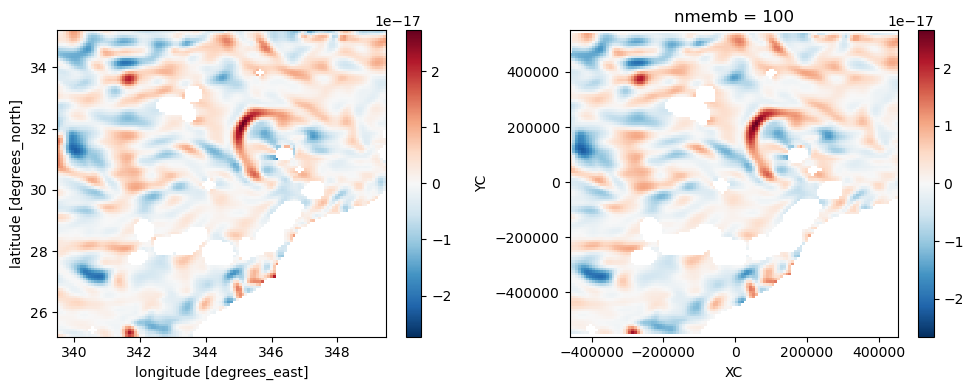

<xarray.DataArray 'XC' ()>
array(347.9725, dtype=float32)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days <xarray.DataArray 'XC' ()>
array(349.50003052)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days


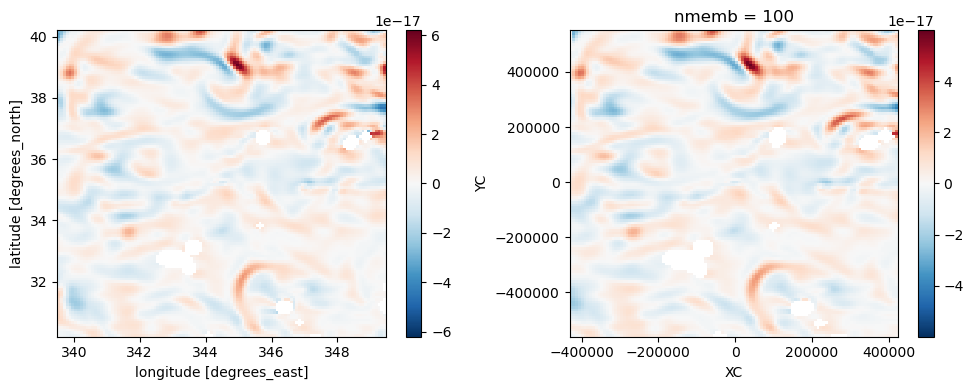

<xarray.DataArray 'XC' ()>
array(347.9725, dtype=float32)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days <xarray.DataArray 'XC' ()>
array(349.50003052)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days


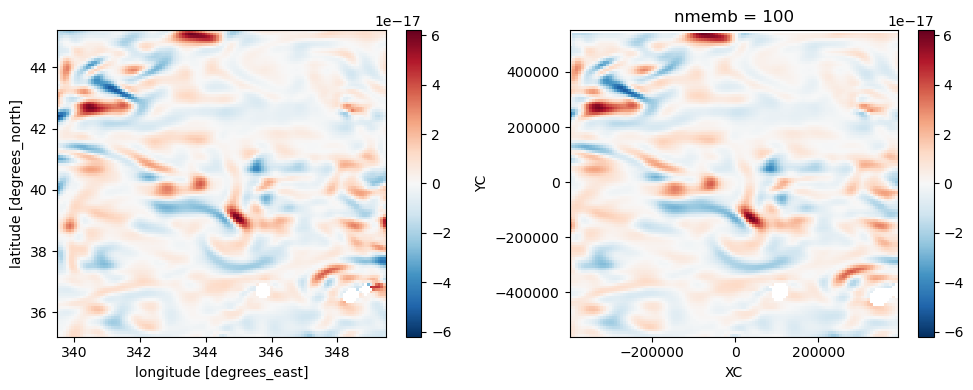

<xarray.DataArray 'XC' ()>
array(347.9725, dtype=float32)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days <xarray.DataArray 'XC' ()>
array(349.50003052)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days


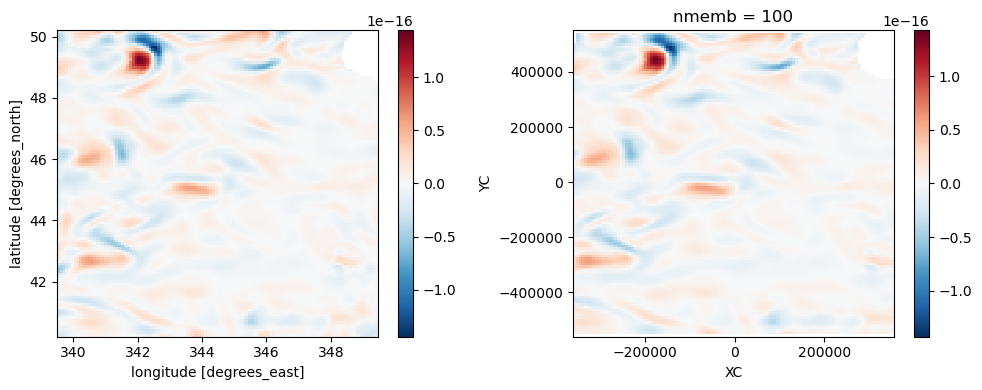

<xarray.DataArray 'XC' ()>
array(347.9725, dtype=float32)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days <xarray.DataArray 'XC' ()>
array(354.50003052)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days


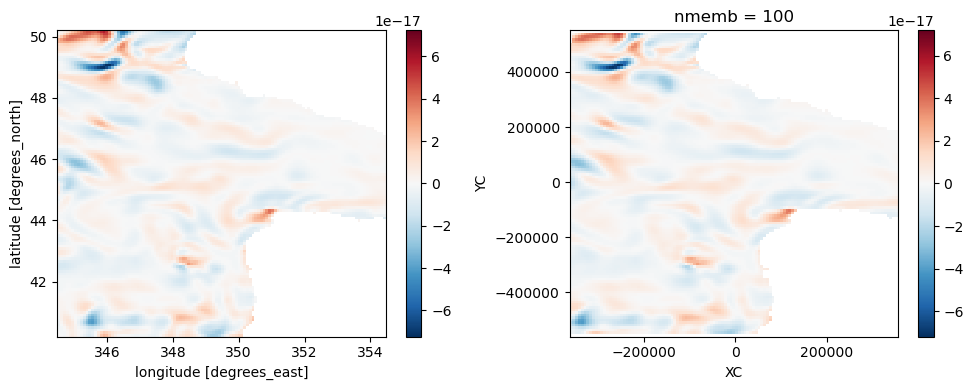

<xarray.DataArray 'XC' ()>
array(347.9725, dtype=float32)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days <xarray.DataArray 'XC' ()>
array(349.50003052)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days


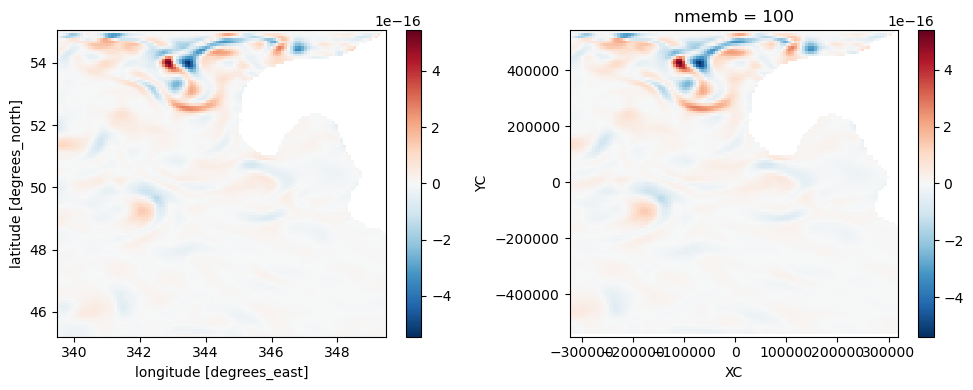

<xarray.DataArray 'XC' ()>
array(347.9725, dtype=float32)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days <xarray.DataArray 'XC' ()>
array(349.50003052)
Coordinates:
    iter     int64 1419120
    time     timedelta64[ns] 3285 days


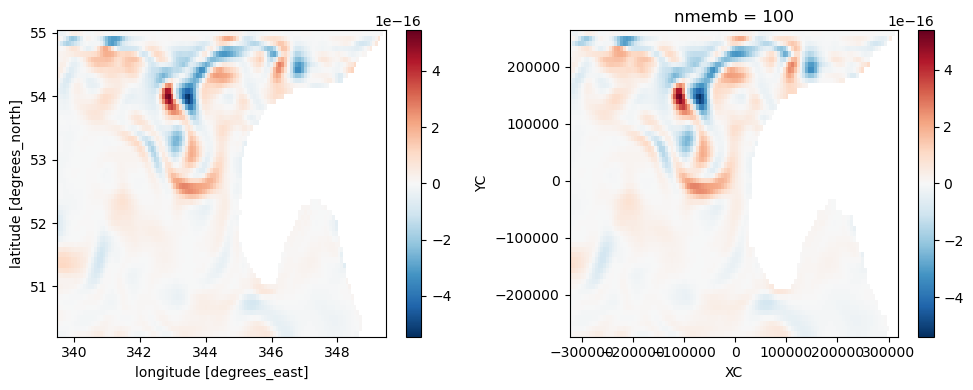

1419120


In [7]:
ystart = ySstart
nmembs = np.arange(100,148)

yys = yystart

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,dd:dd+1]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes:
        
        for imemb in nmembs:
            if imemb == nmembs[0]:
                ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                             % (imemb,year)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn',], 
                                     delta_t=2e2, iters=itime                              
                                    ).isel(time=0
                                          ).chunk({'YC':ychunk,'YG':ychunk,
                                                   'XC':xchunk,'XG':xchunk})
            else:
                ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                                            % (imemb,year)), 
                                                    grid_dir=gdir,
                                                    prefix=['snap_diagOcn',], 
                                                    delta_t=2e2, iters=itime                              
                                                   ).isel(time=0
                                                         ).chunk({'YC':ychunk,'YG':ychunk,
                                                                  'XC':xchunk,'XG':xchunk})
                               ], 'nmemb')
        coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",  "left" : "XG"},
        "Y": {"center": "YC",  "left" : "YG"},
        "Z": {"center": "Z" ,  "outer": "Zp1", 
              "left"  : "Zl",  "inner": "Zu"
             }
        }
        grid = Grid(ds, periodic=['X'],
                    coords=coords)
        if itime == mtimes[0]:
            print(grid)
        
        dsq = xr.open_zarr(
            '/tank/topog/tuchida/Wavelet-spectrum/SnapErtelPV/%2dmembers/%010d.zarr'
                           % (len(nmembs),itime)
                          )
        PVb = (dsq.bEPVh + dsq.bEPVv)
        PVp = (dsq.pEPVh + dsq.pEPVv)
        
        XT = grid.cumsum(ds.dxC,'X')
        YT = grid.cumsum(ds.dyC,'Y',boundary='extend')
        
        xA = (ds.dyG * ds.drF).reset_coords(drop=True)
        yA = (ds.dxG * ds.drF).reset_coords(drop=True)

        UTrans  = (ds.UVEL * xA * ds.hFacW).reset_coords(drop=True)
        VTrans  = (ds.VVEL * yA * ds.hFacS).reset_coords(drop=True)
        RtTrans = (ds.WVEL * ds.rA).reset_coords(drop=True)
        AUq = (UTrans
               * grid.interp(PVp,'X')
              )
        AVq = (VTrans
               * grid.interp(PVp,'Y',boundary='extend')
              )
        AWq = (RtTrans
               * grid.interp(PVp,'Z',boundary='extend')
              )

        Aq = ((grid.diff(AUq,'X')
               + grid.diff(AVq,'Y',boundary='extend')
               - grid.diff(AWq,'Z',boundary='extend')
              ) / ds.drF/ds.rA/ds.hFacC
             ).isel(Z=18)
        
        for lat in np.arange(ystart,yend+5,5)[8:]:
            Q    = PVp.isel(Z=18).sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            AQ   = Aq.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            X    = XT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Y    = YT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            mask = ds.maskC.isel(Z=18).sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            for lon in np.arange(ds.XC.min()-2.5,ds.XC.max(),5):        
                xend = lon + 10
                if lon < ds.XC.min():
                    dlon = ds.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(ds.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(lon,
                                                                           lon+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    crit = mmm.astype(float).sum()/np.array(mmm.shape).prod()
                    if crit > critt:
                        q   = Q.sel(XC=slice(None,xend))
                        aq  = AQ.sel(XC=slice(None,xend))
                        x   = X.sel(XC=slice(None,xend))
                        y   = Y.sel(XC=slice(None,xend))
                        ddx = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                        ).reset_coords(drop=True)
                        ddy = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                        ).reset_coords(drop=True)
                        a   = ds.rA.sel(YC=slice(lat,lat+10),
                                        XC=slice(None,xend)).reset_coords(drop=True)
                        qq  = Q.sel(XC=slice(ds.XC.max()-dlon,None))
                        aqq = AQ.sel(XC=slice(ds.XC.max()-dlon,None))
                        xx  = (X.sel(XC=slice(ds.XC.max()-dlon,None))
                               - X.sel(XC=slice(ds.XC.max()-dlon,None)).isel(XC=0)
                              )
                        x   = x + xx.isel(XC=-1)
                        # x.plot()
                        # plt.show()
                        yy  = Y.sel(XC=slice(ds.XC.max()-dlon,None))
                        aa  = ds.rA.sel(YC=slice(lat,lat+10),
                                        XC=slice(ds.XC.max()-dlon,None)
                                       ).reset_coords(drop=True)
                        dddx = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                         ).reset_coords(drop=True)
                        dddy = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                         ).reset_coords(drop=True)
                        qqq = xr.concat([xr.DataArray(qq.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':Q.YC,
                                                              'XC':np.linspace(lon,
                                                                               lon+dlon,
                                                                               num=len(qq.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     ),
                                         q
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        aaqq = xr.concat([xr.DataArray(aqq.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':AQ.YC,
                                                              'XC':np.linspace(lon,
                                                                               lon+dlon,
                                                                               num=len(aqq.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     ),
                                          aq
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        xT = xr.concat([xr.DataArray(xx.data, dims=['YC','XC'],
                                                     coords={'YC':X.YC,
                                                             'XC':np.linspace(lon,
                                                                              lon+dlon,
                                                                              num=len(xx.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        x
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([xr.DataArray(yy.data, dims=['YC','XC'],
                                                     coords={'YC':Y.YC,
                                                             'XC':np.linspace(lon,
                                                                              lon+dlon,
                                                                              num=len(yy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        y
                                       ], 'XC').sortby('XC')
                        A = xr.concat([xr.DataArray(aa.data, dims=['YC','XC'],
                                                    coords={'YC':a.YC,
                                                            'XC':np.linspace(lon,
                                                                             lon+dlon,
                                                                             num=len(aa.XC)+1,
                                                                             endpoint=False)[1:]}
                                                   ),
                                       a
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([xr.DataArray(dddx.data, dims=['YC','XG'],
                                                     coords={'YC':ddx.YC,
                                                             'XG':np.linspace(ds.XG.min()-dlon,
                                                                              ds.XG.min(),
                                                                              num=len(dddx.XG)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        ddx
                                       ], 'XG').min().values
                        dy = xr.concat([xr.DataArray(dddy.data, dims=['YG','XC'],
                                                     coords={'YG':ddy.YG,
                                                             'XC':np.linspace(lon,
                                                                              lon+dlon,
                                                                              num=len(dddy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        ddy
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        Qterp = xr.DataArray(np.zeros_like(qqq), dims=qqq.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AQterp = xr.DataArray(np.zeros_like(aaqq), dims=aaqq.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            Qterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (qqq.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AQterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aaqq.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                        Aterp[:] = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Qterp  = Qterp / Aterp
                        AQterp = AQterp / Aterp
                        if itime == mtimes[0]:
                            print(lon, lon+dlon)
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            aaqq.isel(nmemb=0).plot(ax=ax1)
                            AQterp.isel(nmemb=0).plot(ax=ax2)
                            plt.show()
                            
                elif xend > ds.XC.max():
                    dlon = -ds.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,ds.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(ds.XC.max(),
                                                                           ds.XC.max()+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    crit = mmm.astype(float).sum()/np.array(mmm.shape).prod()
                    if crit > critt:
                        q   = Q.sel(XC=slice(lon,None))
                        aq  = AQ.sel(XC=slice(lon,None))
                        x   = X.sel(XC=slice(lon,None))
                        y   = Y.sel(XC=slice(lon,None))
                        ddx = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,None)
                                        ).reset_coords(drop=True)
                        ddy = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,None)
                                        ).reset_coords(drop=True)
                        a   = ds.rA.sel(YC=slice(lat,lat+10),
                                        XC=slice(lon,None)).reset_coords(drop=True)
                        qq  = Q.sel(XC=slice(None,ds.XC.min()+dlon))
                        aqq = AQ.sel(XC=slice(None,ds.XC.min()+dlon))
                        xx  = X.sel(XC=slice(None,ds.XC.min()+dlon))+X.isel(XC=-1)
                        yy  = Y.sel(XC=slice(None,ds.XC.min()+dlon))
                        aa  = ds.rA.sel(YC=slice(lat,lat+10),
                                        XC=slice(None,ds.XC.min()+dlon)
                                       ).reset_coords(drop=True)
                        dddx = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,ds.XG.min()+dlon)
                                         ).reset_coords(drop=True)
                        dddy = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,ds.XC.min()+dlon)
                                         ).reset_coords(drop=True)
                        qqq = xr.concat([q,
                                         xr.DataArray(qq.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':Q.YC,
                                                              'XC':np.linspace(ds.XC.max(),
                                                                               ds.XC.max()+dlon,
                                                                               num=len(qq.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     )
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        aaqq = xr.concat([aq,
                                         xr.DataArray(aqq.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':AQ.YC,
                                                              'XC':np.linspace(ds.XC.max(),
                                                                               ds.XC.max()+dlon,
                                                                               num=len(aqq.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     )
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        xT = xr.concat([x,
                                        xr.DataArray(xx.data, dims=['YC','XC'],
                                                     coords={'YC':X.YC,
                                                             'XC':np.linspace(ds.XC.max(),
                                                                              ds.XC.max()+dlon,
                                                                              num=len(xx.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([y,
                                        xr.DataArray(yy.data, dims=['YC','XC'],
                                                     coords={'YC':Y.YC,
                                                             'XC':np.linspace(ds.XC.max(),
                                                                              ds.XC.max()+dlon,
                                                                              num=len(yy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        A = xr.concat([a,
                                       xr.DataArray(aa.data, dims=['YC','XC'],
                                                    coords={'YC':a.YC,
                                                            'XC':np.linspace(ds.XC.max(),
                                                                             ds.XC.max()+dlon,
                                                                             num=len(aa.XC)+1,
                                                                             endpoint=False)[1:]}
                                                   )
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([ddx,
                                        xr.DataArray(dddx.data, dims=['YC','XG'],
                                                     coords={'YC':ddx.YC,
                                                             'XG':np.linspace(ds.XG.max(),
                                                                              ds.XG.max()+dlon,
                                                                              num=len(dddx.XG)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XG').min().values
                        dy = xr.concat([ddy,
                                        xr.DataArray(dddy.data, dims=['YG','XC'],
                                                     coords={'YG':ddy.YG,
                                                             'XC':np.linspace(ds.XC.max(),
                                                                              ds.XC.max()+dlon,
                                                                              num=len(dddy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        Qterp = xr.DataArray(np.zeros_like(qqq), dims=qqq.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AQterp = xr.DataArray(np.zeros_like(aaqq), dims=aaqq.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            Qterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (qqq.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AQterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aaqq.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                        Aterp[:] = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Qterp  = Qterp / Aterp
                        AQterp = AQterp / Aterp
                        if itime == mtimes[0]:
                            print(ds.XC.max(), ds.XC.max()+dlon)
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            aaqq.isel(nmemb=0).plot(ax=ax1)
                            AQterp.isel(nmemb=0).plot(ax=ax2)
                            plt.show()
                else:
                    mmm = mask.sel(XC=slice(lon,xend))
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        qqq  = Q.sel(XC=slice(lon,xend)).where(mmm!=0.)
                        aaqq = AQ.sel(XC=slice(lon,xend)).where(mmm!=0.)
                        xT   = X.sel(XC=slice(lon,xend))
                        yT   = Y.sel(XC=slice(lon,xend))
                        A    = ds.rA.sel(YC=slice(lat,lat+10),
                                         XC=slice(lon,xend)).where(mmm!=0.)
                        ny, nx = xT.shape
                        xT   = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT   = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx   = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,xend)
                                         ).min().values
                        dy   = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,xend)
                                         ).min().values
                        yy   = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx   = np.arange(-nx*dx/2,nx*dx/2,dx)
                        Qterp = xr.DataArray(np.zeros_like(qqq), dims=qqq.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AQterp = xr.DataArray(np.zeros_like(aaqq), dims=aaqq.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            Qterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (qqq*A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AQterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aaqq*A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                        Aterp[:] = griddata((xT, yT), 
                                         ds.rA.sel(YC=slice(lat,lat+10),
                                                   XC=slice(lon,xend)).values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Qterp  = Qterp / Aterp
                        AQterp = AQterp / Aterp
                        if itime == mtimes[0] and lon == ds.XC.min():
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            aaqq.isel(nmemb=0).plot(ax=ax1)
                            AQterp.isel(nmemb=0).plot(ax=ax2)
                            plt.show()
                
                
                if crit > critt:
                    iso_csQf = xrft.isotropic_cross_spectrum(
                                Qterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                                AQterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                                dim=["YC", "XC"], window='hann', 
                                window_correction=True, true_amplitude=True, truncate=True
                    ) 
                    if itime == mtimes[0] and lon == ds.XC.min():
                        fig, ax = plt.subplots()
                        ax.plot(iso_csQf.freq_r*1e3, -(iso_csQf).mean('nmemb'))
                        ax.set_xscale('log')
                        plt.show()
                    dsave = iso_csQf.to_dataset(name='Q')
                    la = A.YC.mean().values
                    lo = A.XC.mean().values
                    if la < 0.:
                        fname = (
                        'Z0452/EPV/Snap/%010d/Fourier/CrossSpectra/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = (
                        'Z0452/EPV/Snap/%010d/Fourier/CrossSpectra/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()
            
                    ss = xr.DataArray(np.linspace(iso_csQf.freq_r[-1].data**-1,
                                                  iso_csQf.freq_r[0].data**-1,40
                                                 )/xo,
                                      dims=['scale'], 
                                      coords={'scale':np.linspace(iso_csQf.freq_r[-1].data**-1,
                                                                  iso_csQf.freq_r[0].data**-1,40
                                                                 )/xo}
                    )
                    ssf = xr.DataArray(iso_csQf.freq_r.data**-1/xo, dims=['scale'], 
                                       coords={'scale':iso_csQf.freq_r.data**-1/xo}
                                      )
                    ssh = xr.concat([ss.where(ss>50e3/xo).dropna('scale')[::-1],
                                     ssf.where(ssf<50e3/xo).dropna('scale')
                                    ], 'scale')
                    iso_csQw = xwavelet.wvlt_cross_spectrum(
                                    Qterp.chunk({'nmemb':1}), AQterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    ) 
                    if la < 0.:
                        fname = (
                        'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = (
                        'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave = iso_csQw.to_dataset(name='Q')
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()
                    del Qterp, AQterp
        dsq.close()
        ds.close()
        print(itime)
    yys += 1

In [21]:
ystart = ySstart
nmembs = np.arange(100,148)

yys = yystart
dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                              % (years[yystart])), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn',], 
                      delta_t=2e2, iters=ntimes[0,0]                              
                     ).isel(time=0
                           ).chunk({'YC':ychunk,'YG':ychunk,
                                    'XC':xchunk,'XG':xchunk})
coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",     "left" : "XG"},
        "Y": {"center": "YC",     "left" : "YG"},
        "Z": {"center": "Z" ,     "outer": "Zp1", 
              "left"  : "Zl",     "inner": "Zu"}
        }
grid = Grid(dsm, periodic=['X'],
            coords=coords)
Ensflux_full = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
Ensflux = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
length = 50e3

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,dd:dd+1]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes:       
        iy = 0
        for lat in np.arange(ystart,yend+5,5):
            mask = dsm.maskC.isel(Z=18).sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            ix = 0
            for lon in np.arange(dsm.XC.min()-2.5,dsm.XC.max(),5):    
                xend = lon + 10
                if lon < dsm.XC.min():
                    dlon = dsm.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(dsm.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(lon,
                                                                           lon+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname = (
                            'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname = (
                            'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        try:
                            ds_trans = xr.open_zarr(op.join(spec,fname))
                            dks = xr.DataArray(np.abs(np.diff(ds_trans.scale**-1)).data, 
                                               dims='scale',
                                               coords={'scale':.5*(ds_trans.scale[1:].data 
                                                                   + ds_trans.scale[:-1].data)}
                                              ).interp(scale=ds_trans.scale, 
                                                       kwargs={"fill_value": "extrapolate"})

                            etaw = ((-ds_trans.Q * dks).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                                   * np.diff(ds_trans.angle)[0]*2
                                  ).mean('nmemb')
                            if crit == 1.:
                                Ensflux_full[dict(YC=iy,XC=ix)] = etaw.sel(scale=slice(length+10e03,length-10e3)
                                                               ).mean('scale')
                            else:
                                Ensflux[dict(YC=iy,XC=ix)] = etaw.sel(scale=slice(length+10e03,length-10e3)
                                                               ).mean('scale')
                            ds_trans.close()
                        except:
                            pass
                elif xend > dsm.XC.max():
                    dlon = -dsm.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,dsm.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(dsm.XC.max(),
                                                                           dsm.XC.max()+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname = (
                            'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname = (
                            'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        try:
                            ds_trans = xr.open_zarr(op.join(spec,fname))
                            dks = xr.DataArray(np.abs(np.diff(ds_trans.scale**-1)).data, 
                                               dims='scale',
                                               coords={'scale':.5*(ds_trans.scale[1:].data 
                                                                   + ds_trans.scale[:-1].data)}
                                              ).interp(scale=ds_trans.scale, 
                                                       kwargs={"fill_value": "extrapolate"})

                            etaw = ((-ds_trans.Q * dks).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                                   * np.diff(ds_trans.angle)[0]*2
                                  ).mean('nmemb')
                            if crit == 1.:
                                Ensflux_full[dict(YC=iy,XC=ix)] = etaw.sel(scale=slice(length+10e03,length-10e3)
                                                               ).mean('scale')
                            else:
                                Ensflux[dict(YC=iy,XC=ix)] = etaw.sel(scale=slice(length+10e03,length-10e3)
                                                               ).mean('scale')
                            ds_trans.close()
                        except:
                            pass
                else:
                    mmm = mask.sel(XC=slice(lon,xend))
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname = (
                            'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname = (
                            'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        try:
                            ds_trans = xr.open_zarr(op.join(spec,fname))
                            dks = xr.DataArray(np.abs(np.diff(ds_trans.scale**-1)).data, 
                                               dims='scale',
                                               coords={'scale':.5*(ds_trans.scale[1:].data 
                                                                   + ds_trans.scale[:-1].data)}
                                              ).interp(scale=ds_trans.scale, 
                                                       kwargs={"fill_value": "extrapolate"})

                            etaw = ((-ds_trans.Q * dks).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                                   * np.diff(ds_trans.angle)[0]*2
                                  ).mean('nmemb')
                            if crit == 1.:
                                Ensflux_full[dict(YC=iy,XC=ix)] = etaw.sel(scale=slice(length+10e03,length-10e3)
                                                               ).mean('scale')
                            else:
                                Ensflux[dict(YC=iy,XC=ix)] = etaw.sel(scale=slice(length+10e03,length-10e3)
                                                               ).mean('scale')  
                            ds_trans.close()
                        except:
                            pass
                
                ix += 1
            iy += 1

        dsm.close()
        print(itime)
    yys += 1

# KEflux[dict(XC=0)] = KEflux.isel(XC=-1)
Ensflux

1419120


<xarray.DataArray (YC: 15, XC: 18)>
array([[ 2.50563215e-34,  8.14382574e-34,  5.31916839e-34,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
         2.31913802e-30,             nan,             nan,
                    nan,             nan,  1.01152758e-33],
       [ 3.27748326e-34,  3.36908009e-34,  6.47792814e-35,
         3.98651050e-35,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,  1.82909176e-33,             nan,
                    nan,  4.20710930e-35,  9.59077526e-35],
       [ 3.66475558e-34, -6.07634488e-35,  1.07554917e-34,
        -1.40767812e-34,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,  2.21412486e-32,             nan,
                    nan, -8.10144387e-34,  2.28717324e-33],
       [ 2.21752644e-32,  1.72037065e-32,  3.43243184e-33,
         2.09330176e-32,             nan,             nan,
...
         1.29707075e-30,  5.59671475e-31,  2.16133406e-30,
         8.49874122e-31,  1.19217413e-30,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,  8.25801993e-30,  5.20587236e-30,
                    nan,             nan,             nan,
                    nan,  9.29027127e-31,  4.99872264e-31],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,  1.14777015e-31,  1.23514181e-31,
                    nan,             nan,             nan,
                    nan,  1.23642914e-29,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,  2.37714771e-32,             nan,
                    nan,             nan,             nan,
                    nan,  1.07666443e-28,             nan]])
Coordinates:
  * YC       (YC) float64 -14.8 -9.8 -4.8 0.2 5.2 ... 35.2 40.2 45.2 50.2 55.2
  * XC       (XC) float64 264.5 269.5 274.5 279.5 ... 334.5 339.5 344.5 349.5

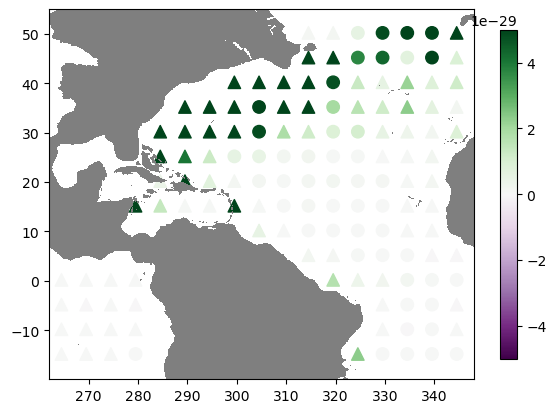

In [22]:
xx, yy = np.meshgrid(Ensflux.XC, Ensflux.YC.isel(YC=slice(None,-1)))
vlim = 1e-28*.5

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
# im = ax.pcolormesh(KEflux.XC, KEflux.YC.isel(YC=slice(None,-1)), 
#                    KEflux.isel(YC=slice(None,-1)), cmap='RdBu_r',
#               vmin=-1e-9, vmax=1e-9, rasterized=True
#              )
im = ax.scatter(xx, yy, 
                s=80, marker='^',
                c=Ensflux.isel(YC=slice(None,-1))*1e1, cmap='PRGn',
              vmin=-vlim, vmax=vlim, rasterized=True
             )
ax.scatter(xx, yy, 
                s=80,
                c=Ensflux_full.isel(YC=slice(None,-1))*1e1, cmap='PRGn',
              vmin=-vlim, vmax=vlim, rasterized=True
             )
ax.pcolormesh(dsm.XC, dsm.YC, dsm.maskC.where(dsm.maskC==0.).isel(Z=18),
              vmin=-2, vmax=2, cmap='binary', rasterized=True
             )
ax.set_xlim([dsm.XC.min(), dsm.XC.max()])
ax.set_ylim([dsm.YC.min(), dsm.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
plt.savefig(op.join(spec,'Figs/Ensflux_Z0452_s=%03dkm_%010d.pdf' 
                    % (int(length*1e-3),ntimes[0,0])))

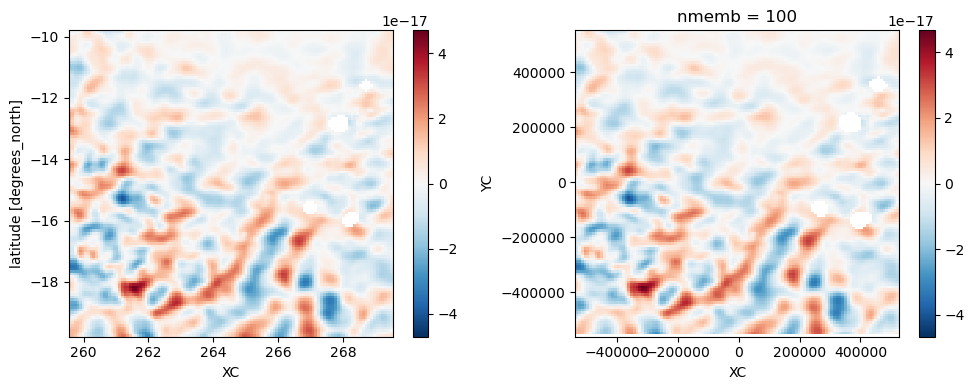

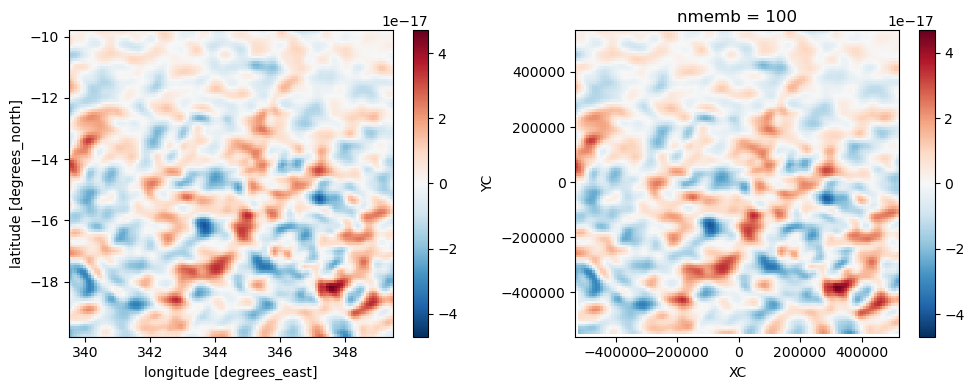

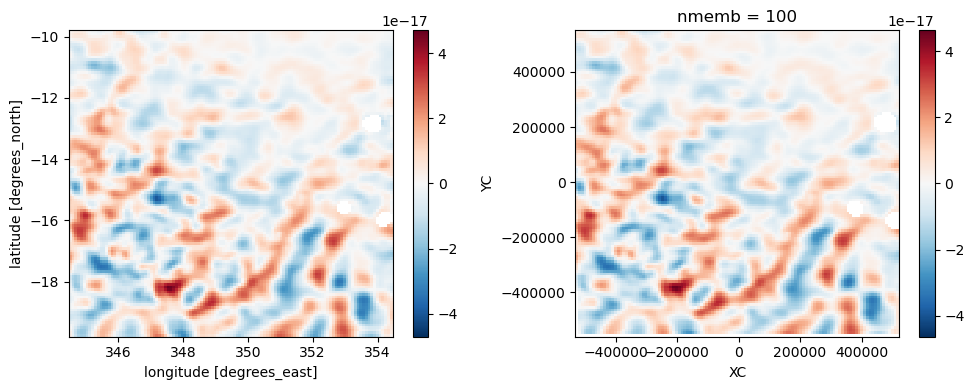

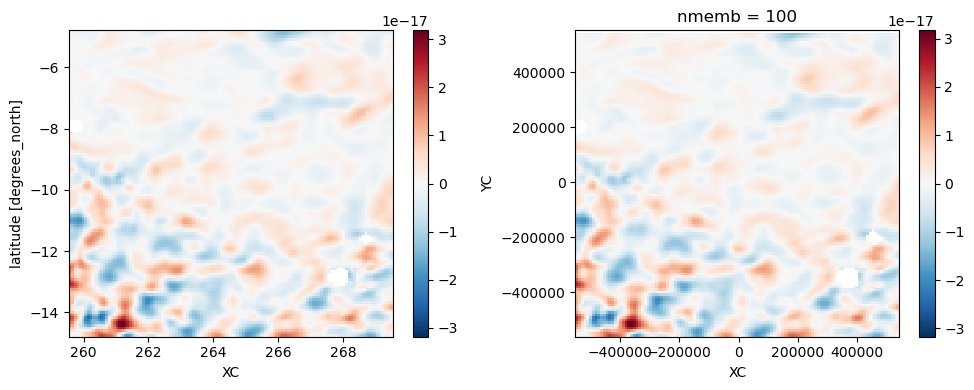

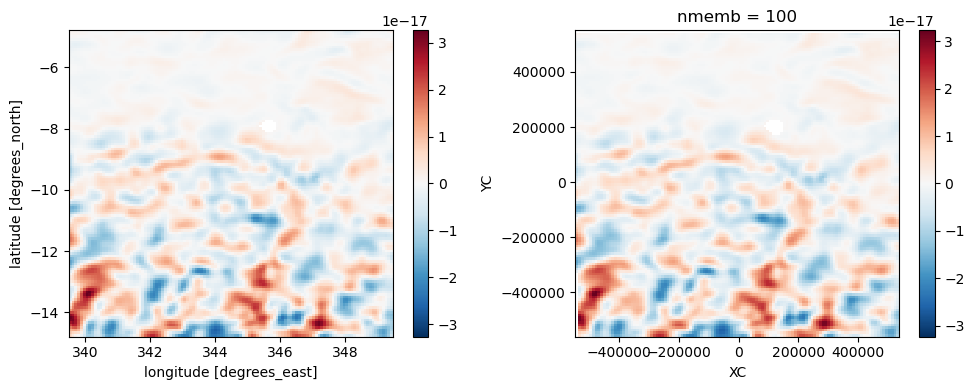

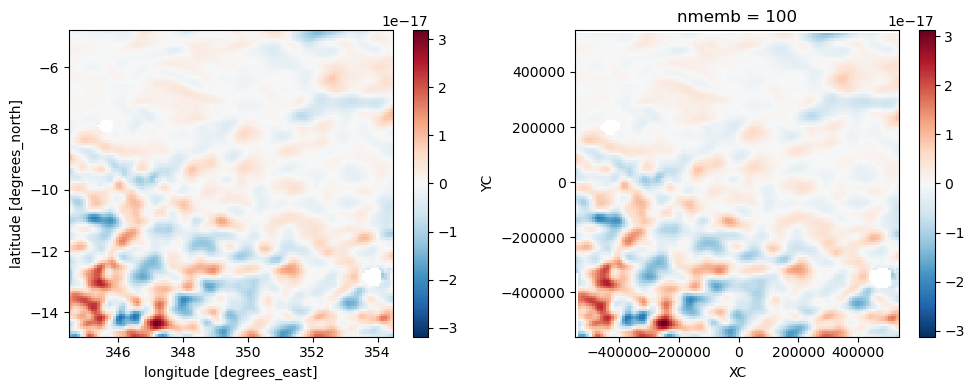

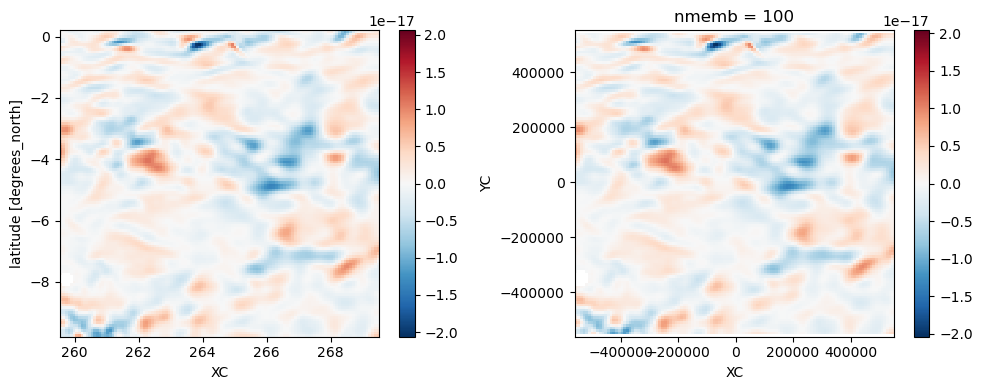

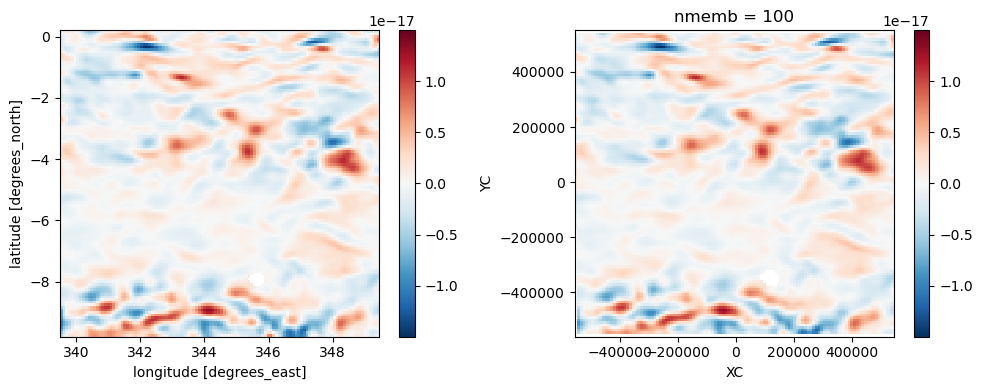

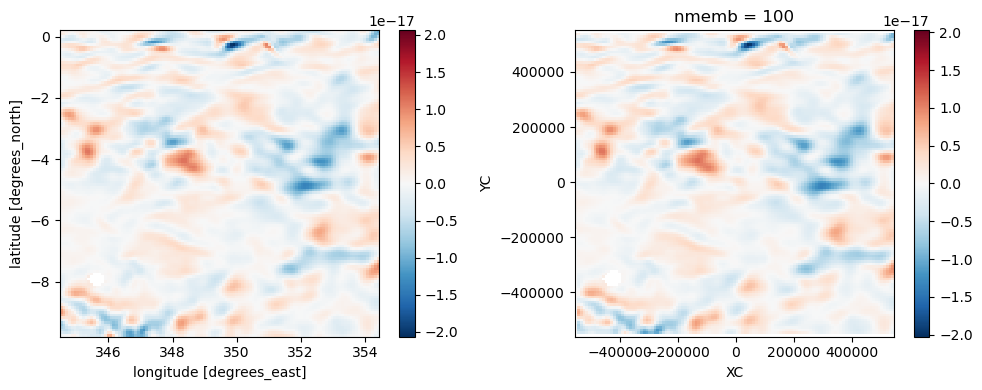

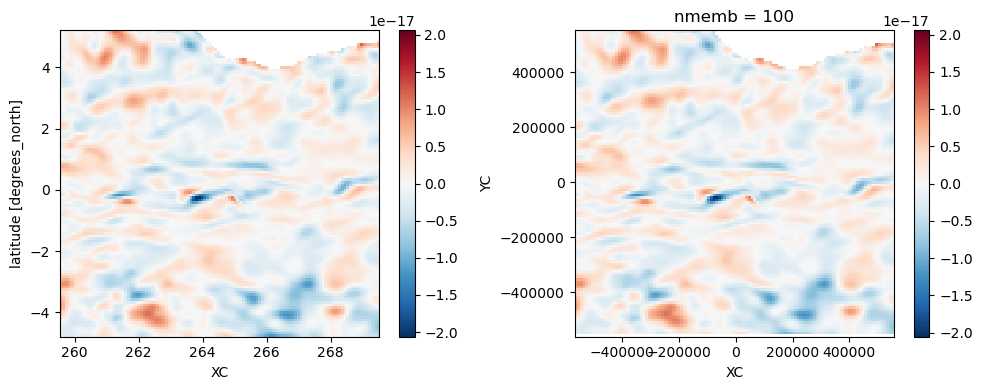

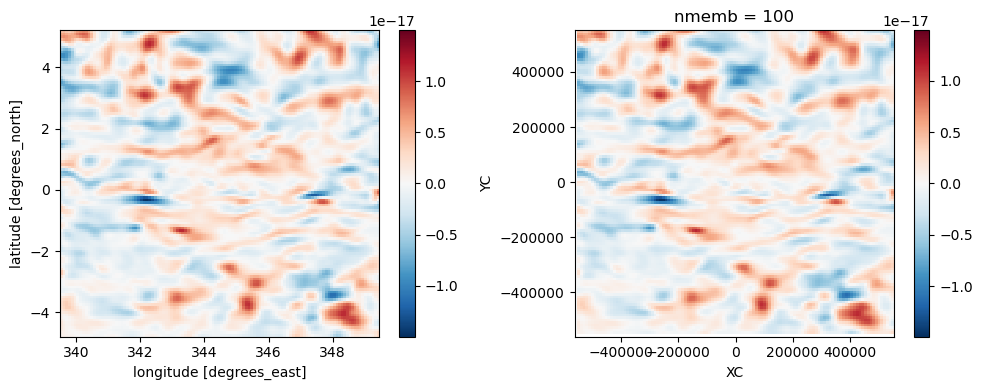

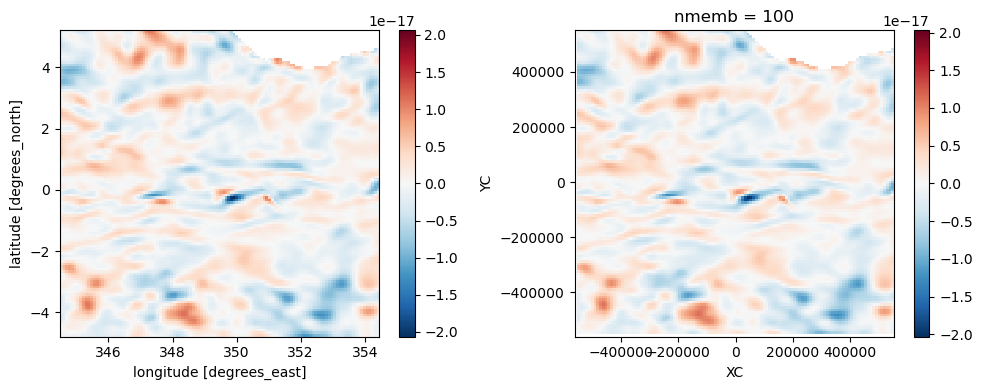

1419120


In [34]:
ystart = ySstart
nmembs = np.arange(100,148)

yys = yystart

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,dd:dd+1]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes:
        
        dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                                      % (year)), 
                              grid_dir=gdir,
                              prefix=['snap_diagOcn',], 
                              delta_t=2e2, iters=itime                              
                             ).isel(time=0
                                   ).chunk({'YC':ychunk,'YG':ychunk,
                                            'XC':xchunk,'XG':xchunk})
        
        for imemb in nmembs:
            if imemb == nmembs[0]:
                ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                             % (imemb,year)), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn',], 
                                     delta_t=2e2, iters=itime                              
                                    ).isel(time=0
                                          ).chunk({'YC':ychunk,'YG':ychunk,
                                                   'XC':xchunk,'XG':xchunk})
            else:
                ds = xr.concat([ds, open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' 
                                                            % (imemb,year)), 
                                                    grid_dir=gdir,
                                                    prefix=['snap_diagOcn',], 
                                                    delta_t=2e2, iters=itime                              
                                                   ).isel(time=0
                                                         ).chunk({'YC':ychunk,'YG':ychunk,
                                                                  'XC':xchunk,'XG':xchunk})
                               ], 'nmemb')
        coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",  "left" : "XG"},
        "Y": {"center": "YC",  "left" : "YG"},
        "Z": {"center": "Z" ,  "outer": "Zp1", 
              "left"  : "Zl",  "inner": "Zu"
             }
        }
        grid = Grid(ds, periodic=['X'],
                    coords=coords)
        
        dse = ds - dsm
        dse.coords['nmemb'] = nmembs
        
        dsq = xr.open_zarr(
            '/tank/topog/tuchida/Wavelet-spectrum/SnapErtelPV/%2dmembers/%010d.zarr'
                           % (len(nmembs),itime)
                          )
        PVb = (dsq.bEPVh + dsq.bEPVv)
        PVp = (dsq.pEPVh + dsq.pEPVv)
        
        XT = grid.cumsum(ds.dxC,'X')
        YT = grid.cumsum(ds.dyC,'Y',boundary='extend')
        
        xA = (ds.dyG * ds.drF).reset_coords(drop=True)
        yA = (ds.dxG * ds.drF).reset_coords(drop=True)

        utTrans = dse.UVEL.reset_coords(drop=True) * xA * ds.hFacW
        vtTrans = dse.VVEL.reset_coords(drop=True) * yA * ds.hFacS
        rtTrans = (dse.WVEL*ds.rA).reset_coords(drop=True)
        Auq = (utTrans
               * grid.interp(PVp,'X')
              )
        Avq = (vtTrans
               * grid.interp(PVp,'Y',boundary='extend')
              )
        Awq = (rtTrans
               * grid.interp(PVp,'Z',boundary='extend')
              )

        Aq = ((grid.diff(Auq,'X')
               + grid.diff(Avq,'Y',boundary='extend')
               - grid.diff(Awq,'Z',boundary='extend')
              ) / ds.drF/ds.rA/ds.hFacC
             ).isel(Z=18).compute()

        UtTrans = ds.UVEL.reset_coords(drop=True) * xA * ds.hFacW
        VtTrans = ds.VVEL.reset_coords(drop=True) * yA * ds.hFacS
        RtTrans = (ds.WVEL*ds.rA).reset_coords(drop=True)
        AUQ = (UtTrans
               * grid.interp((PVb+PVp),'X')
              )
        AVQ = (VtTrans
               * grid.interp((PVb+PVp),'Y',boundary='extend')
              )
        AWQ = (RtTrans
               * grid.interp((PVb+PVp),'Z',boundary='extend')
              )

        AQ = ((grid.diff(AUQ,'X')
               + grid.diff(AVQ,'Y',boundary='extend')
               - grid.diff(AWQ,'Z',boundary='extend')
              ) / ds.drF/ds.rA/ds.hFacC
             ).isel(Z=18)
        AQp = (AQ - AQ.mean('nmemb',skipna=True)).compute()
        
        for lat in np.arange(ystart,yend+5,5)[:4]:
            Q    = PVp.isel(Z=18).sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Qb   = PVb.isel(Z=18).sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            AQ   = AQp.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            AQb  = Aq.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            X    = XT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            Y    = YT.sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            mask = ds.maskC.isel(Z=18).sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            for lon in np.arange(ds.XC.min()-2.5,ds.XC.max(),5):        
                xend = lon + 10
                if lon < ds.XC.min():
                    dlon = ds.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(ds.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(lon,
                                                                           lon+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    crit = mmm.astype(float).sum()/np.array(mmm.shape).prod()
                    if crit > critt:
                        q   = Q.sel(XC=slice(None,xend))
                        aq  = AQ.sel(XC=slice(None,xend))
                        qb  = Qb.sel(XC=slice(None,xend))
                        aqb = AQb.sel(XC=slice(None,xend))
                        x   = X.sel(XC=slice(None,xend))
                        y   = Y.sel(XC=slice(None,xend))
                        ddx = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                        ).reset_coords(drop=True)
                        ddy = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                        ).reset_coords(drop=True)
                        a   = ds.rA.sel(YC=slice(lat,lat+10),
                                        XC=slice(None,xend)).reset_coords(drop=True)
                        qq  = Q.sel(XC=slice(ds.XC.max()-dlon,None))
                        aqq = AQ.sel(XC=slice(ds.XC.max()-dlon,None))
                        qqb = Qb.sel(XC=slice(ds.XC.max()-dlon,None))
                        aqqb= AQb.sel(XC=slice(ds.XC.max()-dlon,None))
                        xx  = (X.sel(XC=slice(ds.XC.max()-dlon,None))
                               - X.sel(XC=slice(ds.XC.max()-dlon,None)).isel(XC=0))
                        x   = x + xx.isel(XC=-1)
                        # x.plot()
                        # plt.show()
                        yy  = Y.sel(XC=slice(ds.XC.max()-dlon,None))
                        aa  = ds.rA.sel(YC=slice(lat,lat+10),
                                        XC=slice(ds.XC.max()-dlon,None)
                                       ).reset_coords(drop=True)
                        dddx = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,xend)
                                         ).reset_coords(drop=True)
                        dddy = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,xend)
                                         ).reset_coords(drop=True)
                        qqq = xr.concat([xr.DataArray(qq.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':Q.YC,
                                                              'XC':np.linspace(lon,
                                                                               lon+dlon,
                                                                               num=len(qq.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     ),
                                         q
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        aaqq = xr.concat([xr.DataArray(aqq.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':AQ.YC,
                                                              'XC':np.linspace(lon,
                                                                               lon+dlon,
                                                                               num=len(aqq.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     ),
                                          aq
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        qqqb = xr.concat([xr.DataArray(qqb.data, dims=['YC','XC'],
                                                      coords={'YC':Q.YC,
                                                              'XC':np.linspace(lon,
                                                                               lon+dlon,
                                                                               num=len(qq.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     ),
                                         qb
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        aaqqb = xr.concat([xr.DataArray(aqqb.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':AQ.YC,
                                                              'XC':np.linspace(lon,
                                                                               lon+dlon,
                                                                               num=len(aqq.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     ),
                                          aqb
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        xT = xr.concat([xr.DataArray(xx.data, dims=['YC','XC'],
                                                     coords={'YC':X.YC,
                                                             'XC':np.linspace(lon,
                                                                              lon+dlon,
                                                                              num=len(xx.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        x
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([xr.DataArray(yy.data, dims=['YC','XC'],
                                                     coords={'YC':Y.YC,
                                                             'XC':np.linspace(lon,
                                                                              lon+dlon,
                                                                              num=len(yy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        y
                                       ], 'XC').sortby('XC')
                        A = xr.concat([xr.DataArray(aa.data, dims=['YC','XC'],
                                                    coords={'YC':a.YC,
                                                            'XC':np.linspace(lon,
                                                                             lon+dlon,
                                                                             num=len(aa.XC)+1,
                                                                             endpoint=False)[1:]}
                                                   ),
                                       a
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([xr.DataArray(dddx.data, dims=['YC','XG'],
                                                     coords={'YC':ddx.YC,
                                                             'XG':np.linspace(ds.XG.min()-dlon,
                                                                              ds.XG.min(),
                                                                              num=len(dddx.XG)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        ddx
                                       ], 'XG').min().values
                        dy = xr.concat([xr.DataArray(dddy.data, dims=['YG','XC'],
                                                     coords={'YG':ddy.YG,
                                                             'XC':np.linspace(lon,
                                                                              lon+dlon,
                                                                              num=len(dddy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    ),
                                        ddy
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        Qterp = xr.DataArray(np.zeros_like(qqq), dims=qqq.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AQterp = xr.DataArray(np.zeros_like(aaqq), dims=aaqq.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        Qterb = xr.DataArray(np.zeros_like(qqqb), dims=qqqb.dims,
                                             coords={'YC':yy,
                                                     'XC':xx}
                                            )
                        AQterb = xr.DataArray(np.zeros_like(aaqqb), dims=aaqqb.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            Qterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (qqq.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AQterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aaqq.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AQterb[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aaqqb.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                        Qterb[:] = griddata((xT, yT), 
                                         (qqqb*A).values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Aterp[:] = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Qterp  = Qterp / Aterp
                        AQterp = AQterp / Aterp
                        Qterb  = Qterb / Aterp
                        AQterb = AQterb / Aterp
                        if itime == mtimes[0]:
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            aaqq.isel(nmemb=0).plot(ax=ax1)
                            AQterp.isel(nmemb=0).plot(ax=ax2)
                            plt.show()
                            
                elif xend > ds.XC.max():
                    dlon = -ds.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,ds.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(ds.XC.max(),
                                                                           ds.XC.max()+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    crit = mmm.astype(float).sum()/np.array(mmm.shape).prod()
                    if crit > critt:
                        q   = Q.sel(XC=slice(lon,None))
                        aq  = AQ.sel(XC=slice(lon,None))
                        qb  = Qb.sel(XC=slice(lon,None))
                        aqb = AQb.sel(XC=slice(lon,None))
                        x   = X.sel(XC=slice(lon,None))
                        y   = Y.sel(XC=slice(lon,None))
                        ddx = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,None)
                                        ).reset_coords(drop=True)
                        ddy = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,None)
                                        ).reset_coords(drop=True)
                        a   = ds.rA.sel(YC=slice(lat,lat+10),
                                        XC=slice(lon,None)).reset_coords(drop=True)
                        qq  = Q.sel(XC=slice(None,ds.XC.min()+dlon))
                        aqq = AQ.sel(XC=slice(None,ds.XC.min()+dlon))
                        qqb = Qb.sel(XC=slice(None,ds.XC.min()+dlon))
                        aqqb= AQb.sel(XC=slice(None,ds.XC.min()+dlon))
                        xx  = X.sel(XC=slice(None,ds.XC.min()+dlon))+X.isel(XC=-1)
                        yy  = Y.sel(XC=slice(None,ds.XC.min()+dlon))
                        aa  = ds.rA.sel(YC=slice(lat,lat+10),
                                        XC=slice(None,ds.XC.min()+dlon)
                                       ).reset_coords(drop=True)
                        dddx = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(None,ds.XG.min()+dlon)
                                         ).reset_coords(drop=True)
                        dddy = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(None,ds.XC.min()+dlon)
                                         ).reset_coords(drop=True)
                        qqq = xr.concat([q,
                                         xr.DataArray(qq.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':Q.YC,
                                                              'XC':np.linspace(ds.XC.max(),
                                                                               ds.XC.max()+dlon,
                                                                               num=len(qq.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     )
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        aaqq = xr.concat([aq,
                                         xr.DataArray(aqq.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':AQ.YC,
                                                              'XC':np.linspace(ds.XC.max(),
                                                                               ds.XC.max()+dlon,
                                                                               num=len(aqq.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     )
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        qqqb = xr.concat([qb,
                                         xr.DataArray(qqb.data, dims=['YC','XC'],
                                                      coords={'YC':Q.YC,
                                                              'XC':np.linspace(ds.XC.max(),
                                                                               ds.XC.max()+dlon,
                                                                               num=len(qq.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     )
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        aaqqb = xr.concat([aqb,
                                         xr.DataArray(aqqb.data, dims=['nmemb','YC','XC'],
                                                      coords={'YC':AQ.YC,
                                                              'XC':np.linspace(ds.XC.max(),
                                                                               ds.XC.max()+dlon,
                                                                               num=len(aqq.XC)+1,
                                                                               endpoint=False)[1:]}
                                                     )
                                        ], 'XC').sortby('XC').where(mmm!=0.)
                        xT = xr.concat([x,
                                        xr.DataArray(xx.data, dims=['YC','XC'],
                                                     coords={'YC':X.YC,
                                                             'XC':np.linspace(ds.XC.max(),
                                                                              ds.XC.max()+dlon,
                                                                              num=len(xx.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        yT = xr.concat([y,
                                        xr.DataArray(yy.data, dims=['YC','XC'],
                                                     coords={'YC':Y.YC,
                                                             'XC':np.linspace(ds.XC.max(),
                                                                              ds.XC.max()+dlon,
                                                                              num=len(yy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XC').sortby('XC')
                        A = xr.concat([a,
                                       xr.DataArray(aa.data, dims=['YC','XC'],
                                                    coords={'YC':a.YC,
                                                            'XC':np.linspace(ds.XC.max(),
                                                                             ds.XC.max()+dlon,
                                                                             num=len(aa.XC)+1,
                                                                             endpoint=False)[1:]}
                                                   )
                                      ], 'XC').sortby('XC')
                        ny, nx = xT.shape
                        xT = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx = xr.concat([ddx,
                                        xr.DataArray(dddx.data, dims=['YC','XG'],
                                                     coords={'YC':ddx.YC,
                                                             'XG':np.linspace(ds.XG.max(),
                                                                              ds.XG.max()+dlon,
                                                                              num=len(dddx.XG)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XG').min().values
                        dy = xr.concat([ddy,
                                        xr.DataArray(dddy.data, dims=['YG','XC'],
                                                     coords={'YG':ddy.YG,
                                                             'XC':np.linspace(ds.XC.max(),
                                                                              ds.XC.max()+dlon,
                                                                              num=len(dddy.XC)+1,
                                                                              endpoint=False)[1:]}
                                                    )
                                       ], 'XC').min().values
                        yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx = np.arange(-nx*dx/2,nx*dx/2,dx)
                        Qterp = xr.DataArray(np.zeros_like(qqq), dims=qqq.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AQterp = xr.DataArray(np.zeros_like(aaqq), dims=aaqq.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        Qterb = xr.DataArray(np.zeros_like(qqqb), dims=qqqb.dims,
                                             coords={'YC':yy,
                                                     'XC':xx}
                                            )
                        AQterb = xr.DataArray(np.zeros_like(aaqqb), dims=aaqqb.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            Qterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (qqq.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AQterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aaqq.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AQterb[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aaqqb.where(mmm!=0.)
                                                          * A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                        Qterb[:] = griddata((xT, yT), 
                                         (qqqb*A).values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Aterp[:] = griddata((xT, yT), 
                                         A.values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Qterp  = Qterp / Aterp
                        AQterp = AQterp / Aterp
                        Qterb  = Qterb / Aterp
                        AQterb = AQterb / Aterp
                        if itime == mtimes[0]:
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            aaqq.isel(nmemb=0).plot(ax=ax1)
                            AQterp.isel(nmemb=0).plot(ax=ax2)
                            plt.show()
                else:
                    mmm = mask.sel(XC=slice(lon,xend))
                    crit = mmm.astype(float).sum()/np.array(mmm.shape).prod()
                    if crit > critt:
                        qqq  = Q.sel(XC=slice(lon,xend)).where(mmm!=0.)
                        aaqq = AQ.sel(XC=slice(lon,xend)).where(mmm!=0.)
                        qqqb = Qb.sel(XC=slice(lon,xend)).where(mmm!=0.)
                        aaqqb= AQb.sel(XC=slice(lon,xend)).where(mmm!=0.)
                        xT   = X.sel(XC=slice(lon,xend))
                        yT   = Y.sel(XC=slice(lon,xend))
                        A    = ds.rA.sel(YC=slice(lat,lat+10),
                                         XC=slice(lon,xend)).where(mmm!=0.)
                        ny, nx = xT.shape
                        xT   = (xT - xT.isel(XC=nx//2)).values.flatten()
                        yT   = (yT - yT.isel(YC=ny//2)).values.flatten()
                        dx   = ds.dxC.sel(YC=slice(lat,lat+10),XG=slice(lon,xend)
                                         ).min().values
                        dy   = ds.dyC.sel(YG=slice(lat,lat+10),XC=slice(lon,xend)
                                         ).min().values
                        yy   = np.arange(-ny*dy/2,ny*dy/2,dy) 
                        xx   = np.arange(-nx*dx/2,nx*dx/2,dx)
                        Qterp = xr.DataArray(np.zeros_like(qqq), dims=qqq.dims,
                                             coords={'nmemb':nmembs,'YC':yy,
                                                     'XC':xx}
                                            )
                        AQterp = xr.DataArray(np.zeros_like(aaqq), dims=aaqq.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        Qterb = xr.DataArray(np.zeros_like(qqqb), dims=qqqb.dims,
                                             coords={'YC':yy,
                                                     'XC':xx}
                                            )
                        AQterb = xr.DataArray(np.zeros_like(aaqqb), dims=aaqqb.dims,
                                              coords={'nmemb':nmembs,'YC':yy,
                                                      'XC':xx}
                                             )
                        Aterp = xr.DataArray(np.zeros_like(A), 
                                             dims=A.dims,
                                             coords={'YC':yy,'XC':xx}
                                            )
                        xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
                        for nn in range(len(nmembs)):
                            Qterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (qqq*A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T 
                            AQterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aaqq*A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                            AQterb[dict(nmemb=nn)] = griddata((xT, yT), 
                                                         (aaqqb*A).isel(nmemb=nn).values.flatten(),
                                                         (xxx, yyy) 
                                                            ).T
                        Qterb[:] = griddata((xT, yT), 
                                         (qqqb*A).values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Aterp[:] = griddata((xT, yT), 
                                         ds.rA.sel(YC=slice(lat,lat+10),
                                                   XC=slice(lon,xend)).values.flatten(),
                                         (xxx, yyy) 
                                        ).T
                        Qterp  = Qterp / Aterp
                        AQterp = AQterp / Aterp
                        Qterb  = Qterb / Aterp
                        AQterb = AQterb / Aterp
                        if itime == mtimes[0] and lon == ds.XC.min():
                            fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
                            fig.set_tight_layout(True)
                            aaqqb.isel(nmemb=0).plot(ax=ax1)
                            AQterb.isel(nmemb=0).plot(ax=ax2)
                            plt.show()
                
                
                if crit > critt:
                    iso_csQf = xrft.isotropic_cross_spectrum(
                                Qterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                                AQterp.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                                dim=["YC", "XC"], window='hann', 
                                window_correction=True, true_amplitude=True, truncate=True
                    ) 
                    for im in range(len(nmembs)):
                        if im == 0:
                            iso_csQbf = xrft.isotropic_cross_spectrum(
                                Qterb.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                                AQterb.isel(nmemb=im).interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                                dim=["YC", "XC"], window='hann', 
                                window_correction=True, true_amplitude=True, truncate=True
                    ) 
                        else:
                            iso_csQbf = xr.concat([iso_csQbf, xrft.isotropic_cross_spectrum(
                                Qterb.interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                                AQterb.isel(nmemb=im).interpolate_na(dim='XC').interpolate_na(dim='YC').fillna(0.), 
                                dim=["YC", "XC"], window='hann', 
                                window_correction=True, true_amplitude=True, truncate=True
                    )], 'nmemb')
                    if itime == mtimes[0] and lon == ds.XC.min():
                        fig, ax = plt.subplots()
                        ax.plot(iso_csQf.freq_r*1e3, -(iso_csQf).mean('nmemb'))
                        ax.set_xscale('log')
                        plt.show()
                    dsave = iso_csQf.to_dataset(name='Ak')
                    dsave['MtEk'] = iso_csQbf
                    la = A.YC.mean().values
                    lo = A.XC.mean().values
                    if la < 0.:
                        fname = (
                        'Z0452/EPV/Snap/%010d/Fourier/CrossSpectra/Ak/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = (
                        'Z0452/EPV/Snap/%010d/Fourier/CrossSpectra/Ak/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()

                    ss = xr.DataArray(np.linspace(iso_csQf.freq_r[-1].data**-1,
                                                  iso_csQf.freq_r[0].data**-1,40
                                                 )/xo,
                                      dims=['scale'], 
                                      coords={'scale':np.linspace(iso_csQf.freq_r[-1].data**-1,
                                                                  iso_csQf.freq_r[0].data**-1,40
                                                                 )/xo}
                    )
                    ssf = xr.DataArray(iso_csQf.freq_r.data**-1/xo, dims=['scale'], 
                                       coords={'scale':iso_csQf.freq_r.data**-1/xo}
                                      )
                    ssh = xr.concat([ss.where(ss>50e3/xo).dropna('scale')[::-1],
                                     ssf.where(ssf<50e3/xo).dropna('scale')
                                    ], 'scale')
                    iso_csQw = xwavelet.wvlt_cross_spectrum(
                                    Qterp.chunk({'nmemb':1}), AQterp.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    ) 
                    iso_csQbw = xwavelet.wvlt_cross_spectrum(
                                    Qterb, AQterb.chunk({'nmemb':1}), 
                                    ssh, dim=["YC", "XC"], 
                                    xo=xo, ntheta=ntheta
                    ) 
                    if la < 0.:
                        fname = (
                        'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Ak/Lat-%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(np.abs(la)),np.floor(lo)))
                    else:
                        fname = (
                        'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Ak/Lat%03d_Lon%03d.zarr' 
                                 % (itime,np.floor(la),np.floor(lo)))
                    dsave = iso_csQw.to_dataset(name='Ak')
                    dsave['MtEk'] = iso_csQbw
                    dsave.attrs['Lat'] = la
                    dsave.attrs['Lon'] = lo
                    dsave.to_zarr(op.join(spec,fname), mode='w')
                    dsave.close()
        dsq.close()
        ds.close()
        print(itime)
    yys += 1

In [39]:
ystart = ySstart
nmembs = np.arange(100,148)

yys = yystart
dsm = open_mdsdataset(op.join(ddir,'ensm/run%4d/ocn/' 
                              % (years[yystart])), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn',], 
                      delta_t=2e2, iters=ntimes[0,0]                              
                     ).isel(time=0
                           ).chunk({'YC':ychunk,'YG':ychunk,
                                    'XC':xchunk,'XG':xchunk})
coords = {
        # "T": {"center": "time"},
        "X": {"center": "XC",     "left" : "XG"},
        "Y": {"center": "YC",     "left" : "YG"},
        "Z": {"center": "Z" ,     "outer": "Zp1", 
              "left"  : "Zl",     "inner": "Zu"}
        }
grid = Grid(dsm, periodic=['X'],
            coords=coords)
Ensflux_full = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
Ensflux = xr.DataArray(np.ones((len(np.arange(ystart+5,yend+10,5)),
                               len(np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5))
                              )), dims=['YC','XC'], 
                      coords={'YC':np.arange(ystart+5,yend+10,5),
                              'XC':np.arange(dsm.XC.min()+2.5,dsm.XC.max()+5,5)}
                     ) * np.nan
length = 400e3

for year in years[yystart:yystart+1]:
    if year == years[yystart]:
        mtimes = ntimes[yys,dd:dd+1]
    else:
        mtimes = ntimes[yys]
        
    for itime in mtimes:       
        iy = 0
        for lat in np.arange(ystart,yend+5,5):
            mask = dsm.maskC.isel(Z=18).sel(YC=slice(lat,lat+10)).reset_coords(drop=True)
            ix = 0
            for lon in np.arange(dsm.XC.min()-2.5,dsm.XC.max(),5):    
                xend = lon + 10
                if lon < dsm.XC.min():
                    dlon = dsm.XC.min() - lon
                    m = mask.sel(XC=slice(None,xend))
                    mm = mask.sel(XC=slice(dsm.XC.max()-dlon,None))
                    mmm = xr.concat([xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(lon,
                                                                           lon+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 ),
                                     m
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname = (
                            'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Ak/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname = (
                            'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Ak/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        try:
                            ds_trans = xr.open_zarr(op.join(spec,fname))
                            dks = xr.DataArray(np.abs(np.diff(ds_trans.scale**-1)).data, 
                                               dims='scale',
                                               coords={'scale':.5*(ds_trans.scale[1:].data 
                                                                   + ds_trans.scale[:-1].data)}
                                              ).interp(scale=ds_trans.scale, 
                                                       kwargs={"fill_value": "extrapolate"})

                            etaw = ((-(ds_trans.Ak + ds_trans.MtEk) 
                                     * dks).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                                   * np.diff(ds_trans.angle)[0]*2
                                  ).mean('nmemb')
                            if crit == 1.:
                                Ensflux_full[dict(YC=iy,XC=ix)] = etaw.sel(scale=slice(length+10e03,length-10e3)
                                                               ).mean('scale')
                            else:
                                Ensflux[dict(YC=iy,XC=ix)] = etaw.sel(scale=slice(length+10e03,length-10e3)
                                                               ).mean('scale')
                            ds_trans.close()
                        except:
                            pass
                elif xend > dsm.XC.max():
                    dlon = -dsm.XC.max() + xend
                    m = mask.sel(XC=slice(lon,None))
                    mm = mask.sel(XC=slice(None,dsm.XC.min()+dlon))
                    mmm = xr.concat([m,
                                     xr.DataArray(mm.data, dims=['YC','XC'],
                                                  coords={'YC':m.YC,
                                                          'XC':np.linspace(dsm.XC.max(),
                                                                           dsm.XC.max()+dlon,
                                                                           num=len(mm.XC)+1,
                                                                           endpoint=False)[1:]}
                                                 )
                                    ], 'XC').sortby('XC')
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname = (
                            'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Ak/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname = (
                            'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Ak/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        try:
                            ds_trans = xr.open_zarr(op.join(spec,fname))
                            dks = xr.DataArray(np.abs(np.diff(ds_trans.scale**-1)).data, 
                                               dims='scale',
                                               coords={'scale':.5*(ds_trans.scale[1:].data 
                                                                   + ds_trans.scale[:-1].data)}
                                              ).interp(scale=ds_trans.scale, 
                                                       kwargs={"fill_value": "extrapolate"})

                            etaw = ((-(ds_trans.Ak + ds_trans.MtEk) 
                                     * dks).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                                   * np.diff(ds_trans.angle)[0]*2
                                  ).mean('nmemb')
                            if crit == 1.:
                                Ensflux_full[dict(YC=iy,XC=ix)] = etaw.sel(scale=slice(length+10e03,length-10e3)
                                                               ).mean('scale')
                            else:
                                Ensflux[dict(YC=iy,XC=ix)] = etaw.sel(scale=slice(length+10e03,length-10e3)
                                                               ).mean('scale')
                            ds_trans.close()
                        except:
                            pass
                else:
                    mmm = mask.sel(XC=slice(lon,xend))
                    la = mmm.YC.mean()
                    lo = mmm.XC.mean()
                    crit = mmm.astype(float).sum().values/np.array(mmm.shape).prod()
                    if crit > critt:
                        if la < 0.:
                            fname = (
                            'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Ak/Lat-%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(np.abs(la)),np.floor(lo)))
                        else:
                            fname = (
                            'Z0452/EPV/Snap/%010d/Wavelet/CrossSpectra/Ak/Lat%03d_Lon%03d.zarr' 
                                     % (itime,np.floor(la),np.floor(lo)))
                        try:
                            ds_trans = xr.open_zarr(op.join(spec,fname))
                            dks = xr.DataArray(np.abs(np.diff(ds_trans.scale**-1)).data, 
                                               dims='scale',
                                               coords={'scale':.5*(ds_trans.scale[1:].data 
                                                                   + ds_trans.scale[:-1].data)}
                                              ).interp(scale=ds_trans.scale, 
                                                       kwargs={"fill_value": "extrapolate"})

                            etaw = ((-(ds_trans.Ak + ds_trans.MtEk) 
                                     * dks).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
                                   * np.diff(ds_trans.angle)[0]*2
                                  ).mean('nmemb')
                            if crit == 1.:
                                Ensflux_full[dict(YC=iy,XC=ix)] = etaw.sel(scale=slice(length+10e03,length-10e3)
                                                               ).mean('scale')
                            else:
                                Ensflux[dict(YC=iy,XC=ix)] = etaw.sel(scale=slice(length+10e03,length-10e3)
                                                               ).mean('scale')  
                            ds_trans.close()
                        except:
                            pass
                
                ix += 1
            iy += 1

        dsm.close()
        print(itime)
    yys += 1

# KEflux[dict(XC=0)] = KEflux.isel(XC=-1)
Ensflux

1419120


<xarray.DataArray (YC: 15, XC: 18)>
array([[ 7.14554180e-31,  6.94786194e-31,  8.07017359e-31,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
         3.01114625e-29,             nan,             nan,
                    nan,             nan,  6.79805546e-31],
       [ 1.56713991e-31,  2.15596083e-31,  9.90222331e-32,
         8.79911279e-31,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,  1.05250768e-30,             nan,
                    nan,  2.21078494e-31,  2.94367356e-31],
       [ 1.57328716e-31,  3.56968499e-31,  4.96412207e-31,
         6.01395907e-31,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,  1.68946682e-30,             nan,
                    nan, -5.33604746e-32,  1.17063202e-31],
       [ 7.50765083e-32,  4.77176743e-31,  7.52568015e-32,
         9.57643077e-32,             nan,             nan,
...
         9.57340451e-29,  1.97189047e-29,  8.28622587e-29,
         3.30767343e-29,  1.11272980e-29,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,  7.06216562e-28, -2.57161026e-28,
                    nan,             nan,             nan,
                    nan,  3.95549204e-29,  1.01761951e-29],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan, -2.25607423e-30, -1.90581674e-29,
                    nan,             nan,             nan,
                    nan, -3.85851329e-30,             nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan]])
Coordinates:
  * YC       (YC) float64 -14.8 -9.8 -4.8 0.2 5.2 ... 35.2 40.2 45.2 50.2 55.2
  * XC       (XC) float64 264.5 269.5 274.5 279.5 ... 334.5 339.5 344.5 349.5

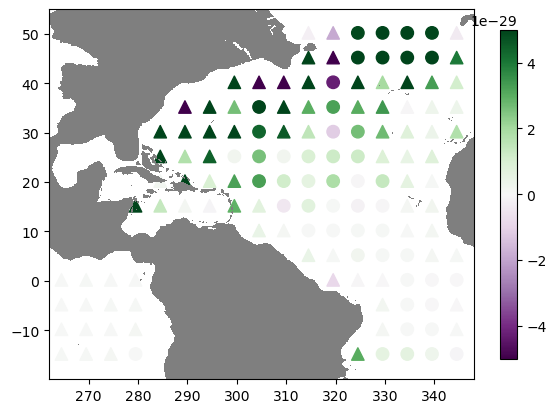

In [40]:
xx, yy = np.meshgrid(Ensflux.XC, Ensflux.YC.isel(YC=slice(None,-1)))
vlim = 1e-28*.5

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
# im = ax.pcolormesh(KEflux.XC, KEflux.YC.isel(YC=slice(None,-1)), 
#                    KEflux.isel(YC=slice(None,-1)), cmap='RdBu_r',
#               vmin=-1e-9, vmax=1e-9, rasterized=True
#              )
im = ax.scatter(xx, yy, 
                s=80, marker='^',
                c=Ensflux.isel(YC=slice(None,-1))*1e0, cmap='PRGn',
              vmin=-vlim, vmax=vlim, rasterized=True
             )
ax.scatter(xx, yy, 
                s=80,
                c=Ensflux_full.isel(YC=slice(None,-1))*1e0, cmap='PRGn',
              vmin=-vlim, vmax=vlim, rasterized=True
             )
ax.pcolormesh(dsm.XC, dsm.YC, dsm.maskC.where(dsm.maskC==0.).isel(Z=18),
              vmin=-2, vmax=2, cmap='binary', rasterized=True
             )
ax.set_xlim([dsm.XC.min(), dsm.XC.max()])
ax.set_ylim([dsm.YC.min(), dsm.YC.max()])
ax.set_aspect(True)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
plt.savefig(op.join(spec,'Figs/Enstotflux_Z0452_s=%03dkm_%010d.pdf' 
                    % (int(length*1e-3),ntimes[0,0])))